# Generating sequences by kinetic Monte-Carlo

Imports

In [1]:
import importlib
from pathlib import Path
import itertools

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mean_absolute_error

import numpy as np
import pandas as pd

from scipy.stats import pearsonr
import scipy.stats
import pyBigWig
import logomaker

from Modules import utils, plot_utils

2023-04-20 10:29:48.572890: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
importlib.reload(utils)
importlib.reload(plot_utils)
data_dir = '../shared_folder'
writing_dir = '../shared_folder'
# writing_dir='../'
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
def mywho():
    np.who({k: v for k, v in globals().items() if k[0]!= '_'})

Functions from MyModuleLibrary

In [4]:
def correlate(y_true, y_pred):
    """
		Calculate the correlation between the predictions and the labels.

		:Example:

		>>> model.compile(optimizer = 'adam', losses = correlate)
		>>> load_model('file', custom_objects = {'correlate : correlate})
	"""
    X = y_true - K.mean(y_true)
    Y = y_pred - K.mean(y_pred)
    
    sigma_XY = K.sum(X*Y)
    sigma_X = K.sqrt(K.sum(X*X))
    sigma_Y = K.sqrt(K.sum(Y*Y))
    
    return sigma_XY/(sigma_X*sigma_Y + K.epsilon())

def mae_cor(y_true, y_pred):
    """
	   Calculate the mean absolute error minus the correlation between
        predictions and  labels.

		:Example:

		>>> model.compile(optimizer = 'adam', losses = mae_cor)
		>>> load_model('file', custom_objects = {'mae_cor : mae_cor})
	"""
    X = y_true - K.mean(y_true)
    Y = y_pred - K.mean(y_pred)
    
    sigma_XY = K.sum(X*Y)
    sigma_X = K.sqrt(K.sum(X*X))
    sigma_Y = K.sqrt(K.sum(Y*Y))
    
    cor = sigma_XY/(sigma_X*sigma_Y + K.epsilon())
    mae = K.mean(K.abs(y_true - y_pred))
    
    return 1 + mae - cor

def rolling_window(array, window=(0,), asteps=None, wsteps=None, axes=None, toend=True):  
    """ 
        Take a numpy array and return a view of this array after applying a rolling window.

        This takes a numpy and cut it in several pieces with the size, the stride and the 
        axes asked as needed. You may want to use it in order to create a set of sequences
        from an array.

        :param array: The array we want to cut
        :param window: The length of the window
        :param asteps: The stride between two window applied
        :param wsteps: The stride whitin the window
        :param axes: The axe on which to apply the rolling window
        :param toend: Weither or not to finish the cut
        :type array: numpy array
        :type window: int or tuple
        :type asteps: int or tuple
        :type wsteps: int or tuple
        :type axes: int
        :type toend: boolean
        :return: The view of the array
        :rtype: numpy array

        :Example:

        >>> a = numpy.array([0,1,2,3,4,5])
        >>> rolling_window(a, window = 2, asteps = 2, wsteps = None)
        array([[0,1],
               [2,3],
               [4,5]])
        >>> rolling_window(a, window = 2, asteps = None, wsteps = 2)
        array([[0,2],
               [1,3],
               [2,4]
               [3,5]])
        >>> rolling_window(a, window = 5, asteps = 2, wsteps = None)
        array([[0,1,2,3,4]])

        .. warning:: Be carreful about the combination of window, wsteps and asteps that may raise 
                     ValueError. This function forces the window to be of the asked size and thus 
                     may stop the application of the window before the end.
    """        

    array = np.asarray(array)
    orig_shape = np.asarray(array.shape)
    window = np.atleast_1d(window).astype(int) # maybe crude to cast to int...

    if axes is not None:
        axes = np.atleast_1d(axes)
        w = np.zeros(array.ndim, dtype=int)
        for axis, size in zip(axes, window):
            w[axis] = size
        window = w

    # Check if window is legal:
    if window.ndim > 1:
        raise ValueError("`window` must be one-dimensional.")
    if np.any(window < 0):
        raise ValueError("All elements of `window` must be larger than 1.")
    if len(array.shape) < len(window):
        raise ValueError("`window` length must be less or equal `array` dimension.") 

    _asteps = np.ones_like(orig_shape)
    if asteps is not None:
        asteps = np.atleast_1d(asteps)
        if asteps.ndim != 1:
            raise ValueError("`asteps` must be either a scalar or one dimensional.")
        if len(asteps) > array.ndim:
            raise ValueError("`asteps` cannot be longer then the `array` dimension.")
        # does not enforce alignment, so that steps can be same as window too.
        _asteps[-len(asteps):] = asteps
        
        if np.any(asteps < 1):
             raise ValueError("All elements of `asteps` must be larger then 1.")
    asteps = _asteps

    _wsteps = np.ones_like(window)
    if wsteps is not None:
        wsteps = np.atleast_1d(wsteps)
        if wsteps.shape != window.shape:
            raise ValueError("`wsteps` must have the same shape as `window`.")
        if np.any(wsteps < 0):
             raise ValueError("All elements of `wsteps` must be larger then 0.")

        _wsteps[:] = wsteps
        _wsteps[window == 0] = 1 # make sure that steps are 1 for non-existing dims.
    wsteps = _wsteps

    # Check that the window would not be larger than the original:
    if np.any(orig_shape[-len(window):] < window * wsteps):
        raise ValueError("`window` * `wsteps` larger then `array` in at least one dimension.")

    new_shape = orig_shape # just renaming...

    # For calculating the new shape 0s must act like 1s:
    _window = window.copy()
    _window[_window==0] = 1

    new_shape[-len(window):] += wsteps - _window * wsteps
    new_shape = (new_shape + asteps - 1) // asteps
    # make sure the new_shape is at least 1 in any \"old\" dimension (ie. steps
    # is (too) large, but we do not care.
    new_shape[new_shape < 1] = 1
    shape = new_shape

    strides = np.asarray(array.strides)
    strides *= asteps
    new_strides = array.strides[-len(window):] * wsteps
    
    # The full new shape and strides:
    if toend:
        new_shape = np.concatenate((shape, window))
        new_strides = np.concatenate((strides, new_strides))
    else:
        _ = np.zeros_like(shape)
        _[-len(window):] = window
        _window = _.copy()
        _[-len(window):] = new_strides
        _new_strides = _
        
        new_shape = np.zeros(len(shape)*2, dtype=int)
        new_strides = np.zeros(len(shape)*2, dtypenucleotid=int)
        
        new_shape[::2] = shape
        new_strides[::2] = strides
        new_shape[1::2] = _window
        new_strides[1::2] = _new_strides
    
    new_strides = new_strides[new_shape != 0]
    new_shape = new_shape[new_shape != 0]
    
    return np.lib.stride_tricks.as_strided(array, shape=new_shape, strides=new_strides)

# Adaptation from Etienne's predict functions for each annotation
def predict(one_hot_chr, model, annotation_type, last_window=False):
    if annotation_type == 'nucleosome':
        WINDOW = 2001
        X = rolling_window(one_hot_chr, window=(WINDOW, 4))[:, 0, :, None,  :]
        pred = np.zeros(len(one_hot_chr), dtype='float32')
        pred[WINDOW//2:-(WINDOW//2)] = model.predict(X)[:, 0]
    else:
        if annotation_type == 'cohesine':
            WINDOW = 32768
        elif annotation_type == 'pol':
            WINDOW = 2048
        else:
            raise ValueError('annotation_type must be "nucleosome", "cohesine" or "pol"')
        if WINDOW > len(one_hot_chr):
            raise ValueError('sequence too small')
        X = rolling_window(one_hot_chr, window=(WINDOW, 4), asteps=(WINDOW, 4))[:, 0, :, :]
        pred = np.zeros((len(one_hot_chr),))
        y = model.predict(X)
        y = np.repeat(y.ravel(), 128)
        pred[:len(y)] = y
        if last_window:
            X = one_hot_chr[-WINDOW:].reshape((1, WINDOW, 4))
            y = model.predict(X)
            y = np.repeat(y.ravel(), 128)
            leftover = len(pred) % WINDOW
            if leftover != 0:
                pred[-leftover:] = y[-leftover:]
    return pred


Predict on random sequences

In [5]:
species = 'SCerevisiae'

In [6]:
one_hots_yeast = {}
with np.load(Path(data_dir, species, 'genome', 'W303', 'W303.npz')) as f:
    for chr_id in f.keys():
        if chr_id[:3] == 'chr':
            one_hots_yeast[chr_id] = f[chr_id]
with np.load(Path(data_dir, species, 'genome', 'bacterie', 'Mmm_Linear_740kb.npz')) as f:
    one_hot_myco = f['chr1']
with np.load(Path(data_dir, species, 'genome', 'bacterie', 'Pneu300.npz')) as f:
    one_hot_pneu = f['chr1']
print(one_hot_pneu.shape)

(817946, 4)


### Load and normalize labels

Load nucleosome labels

In [7]:
def log(x):
    x_ = np.copy(x)
    x_[np.isnan(x_)] = 0
    # My preferred way to deal with inf
    x_[np.isinf(x_)] = np.max(x_[np.isfinite(x_)])
    # Workaround Etienne's way to avoid inf in cohesine myco
    # x_[np.isinf(x_)] = np.percentile(x_, 98)
    # Etienne's way
    # x_[np.isinf(x_)] = np.percentile(x_, 99.5)
    # x_[np.isinf(x_)] = np.percentile(x_, 90)
    x_ = np.log2(x_ + 1)
    return x_

def load_yeast_bw(filename, bact='myco', romantoint=False, process=None):
    # Load bigwig
    labels = utils.load_bw(filename)
    # Change chromosome names
    if romantoint:
        for key in list(labels.keys()):
            if key[:3] == 'chr':
                new_key = 'chr' + format(utils.roman_to_int(key[3:]), '02d')
                labels[new_key] = labels.pop(key)
    if bact == 'myco':
        chr_id = list({'Mmm_Linear_740kb.fa', 'Mmmyco'}.intersection(labels.keys()))
        assert len(chr_id) == 1
        labels['myco'] = labels.pop(chr_id[0])
    elif bact == 'pneu':
        labels['pneu'] = labels.pop('Pneu300')
    # Remove unwanted chromosomes
    for key in list(labels.keys()):
        if key[:3] != 'chr' and key != bact:
            labels.pop(key)
    # Transform data
    if process is not None:
        if process == 'conv':
            process = lambda x: utils.moving_average(x, 21, keepsize=True)
        elif process == 'log':
            process = lambda x: np.log2(1 + x)
        for key, value in labels.items():
            labels[key] = process(value)
    # Normalize in CPM
    thres = sum(v.sum() for v in labels.values()) / 1e6
    for key, value in labels.items():
        labels[key] = value / thres
    return labels

def load_yeast_nuc(mycofile=None, pneufile=None, asdict=True, priority='myco', process='conv'):
    if mycofile is None:
        mycofile = '/home/alex/shared_folder/SCerevisiae/data/Data_etienne/Bacterial_genome_project/data/for_Julien/myco/coverage_RPKM_myco265.bw'
    if pneufile is None:
        pneufile = '/home/alex/shared_folder/SCerevisiae/data/Data_etienne/Bacterial_genome_project/data/for_Julien/pneumo/coverage_RPKM_pneumo205.bw'
    # Load bigwigs
    labels_myco = load_yeast_bw(mycofile, bact='myco', process=process)
    labels_pneu = load_yeast_bw(pneufile, bact='pneu', process=process)
    # Get labels from priority file
    labels = {}
    if priority == 'myco':
        for key, value in labels_myco.items():
            labels[key] = value
        labels['pneu'] = labels_pneu['pneu']
    else:
        for key, value in labels_pneu.items():
            labels[key] = value
        labels['myco'] = labels_myco['myco']
    # Return dictionary by chromosome, or an array per genome
    if asdict:
        return labels
    else:
        return (
            np.concatenate([v for k, v in labels.items() if k[:3] == 'chr']),
            labels['myco'],
            labels['pneu']
        )

def load_yeast_chip(labels_ipmyco, labels_ctrlmyco, labels_ippneu, labels_ctrlpneu,
                    asdict=True, priority='myco'):
    # Get log ratios
    labels_myco = {}
    for key, value in labels_ipmyco.items():
        labels_myco[key] = log(value / labels_ctrlmyco[key])
    thres_myco = sum(v.sum() for v in labels_myco.values()) / 1e6
    labels_pneu = {}
    for key, value in labels_ippneu.items():
        labels_pneu[key] = log(value / labels_ctrlpneu[key])
    thres_pneu = sum(v.sum() for v in labels_pneu.values()) / 1e6
    # Get labels from priority file, and normalize in CPM
    labels = {}
    if priority == 'myco':
        for key, value in labels_myco.items():
            labels[key] = value / thres_myco
        labels['pneu'] = labels_pneu['pneu'] / thres_pneu
    else:
        for key, value in labels_pneu.items():
            labels[key] = value / thres_pneu
        labels['myco'] = labels_myco['myco'] / thres_myco
    # Return dictionary by chromosome, or an array per genome
    if asdict:
        return labels
    else:
        return (
            np.concatenate([v for k, v in labels.items() if k[:3] == 'chr']),
            labels['myco'],
            labels['pneu']
        )

def load_yeast_coh(mycoipfile=None, mycoctrlfile=None, pneuipfile=None, pneuctrlfile=None,
                   asdict=True, priority='pneu'):
    if mycoipfile is None:
        mycoipfile = '/home/alex/shared_folder/SCerevisiae/data/Data_etienne/GSM6703630_Scc1_Mmyco_rep1.CPM.bw'
    if mycoctrlfile is None:
        mycoctrlfile = '/home/alex/shared_folder/SCerevisiae/data/Data_etienne/GSM6703631_Scc1-inp_Mmyco_rep1.CPM.bw'
    if pneuipfile is None:
        pneuipfile = '/home/alex/shared_folder/SCerevisiae/data/Data_etienne/Bacterial_genome_project/data/for_Julien/pneumo/coverage_RPKM219.bw'
    if pneuctrlfile is None:
        pneuctrlfile = '/home/alex/shared_folder/SCerevisiae/data/Data_etienne/Bacterial_genome_project/data/for_Julien/pneumo/coverage_RPKM220.bw'
    # Load bigwigs
    labels_ipmyco = load_yeast_bw(mycoipfile, bact='myco', romantoint=True)
    labels_ctrlmyco = load_yeast_bw(mycoctrlfile, bact='myco', romantoint=True)
    labels_ippneu = load_yeast_bw(pneuipfile, bact='pneu')
    labels_ctrlpneu = load_yeast_bw(pneuctrlfile, bact='pneu')
    return load_yeast_chip(labels_ipmyco, labels_ctrlmyco, labels_ippneu, labels_ctrlpneu,
                           asdict=asdict, priority=priority)

def load_yeast_pol(mycoipfile=None, mycoctrlfile=None, pneuipfile=None, pneuctrlfile=None,
                   asdict=True, priority='myco'):
    if mycoipfile is None:
        mycoipfile = '/home/alex/shared_folder/SCerevisiae/data/Data_etienne/Bacterial_genome_project/data/for_Julien/myco/coverage_RPKM102.bw'
    if mycoctrlfile is None:
        mycoctrlfile = '/home/alex/shared_folder/SCerevisiae/data/Data_etienne/Bacterial_genome_project/data/for_Julien/myco/coverage_RPKM105.bw'
    if pneuipfile is None:
        pneuipfile = '/home/alex/shared_folder/SCerevisiae/data/Data_etienne/Bacterial_genome_project/data/for_Julien/pneumo/coverage_RPKM154.bw'
    if pneuctrlfile is None:
        pneuctrlfile = '/home/alex/shared_folder/SCerevisiae/data/Data_etienne/Bacterial_genome_project/data/for_Julien/pneumo/coverage_RPKM155.bw'
    # Load bigwigs
    labels_ipmyco = load_yeast_bw(mycoipfile, bact='myco')
    labels_ctrlmyco = load_yeast_bw(mycoctrlfile, bact='myco')
    labels_ippneu = load_yeast_bw(pneuipfile, bact='pneu')
    labels_ctrlpneu = load_yeast_bw(pneuctrlfile, bact='pneu')
    return load_yeast_chip(labels_ipmyco, labels_ctrlmyco, labels_ippneu, labels_ctrlpneu,
                           asdict=asdict, priority=priority)

# labels_nuc_yeast, labels_nuc_myco, labels_nuc_pneu = load_yeast_nuc(asdict=False, process=None)
# labels_coh_yeast, labels_coh_myco, labels_coh_pneu = load_yeast_coh(asdict=False)
# labels_pol_yeast, labels_pol_myco, labels_pol_pneu = load_yeast_pol(asdict=False)
labels_nuc = load_yeast_nuc()
labels_coh = load_yeast_coh()
labels_pol = load_yeast_pol()

/tmp/ipykernel_1348875/180740096.py:80: RuntimeWarning: divide by zero encountered in true_divide
  labels_myco[key] = log(value / labels_ctrlmyco[key])
/tmp/ipykernel_1348875/180740096.py:80: RuntimeWarning: invalid value encountered in true_divide
  labels_myco[key] = log(value / labels_ctrlmyco[key])
/tmp/ipykernel_1348875/180740096.py:84: RuntimeWarning: divide by zero encountered in true_divide
  labels_pneu[key] = log(value / labels_ctrlpneu[key])
/tmp/ipykernel_1348875/180740096.py:84: RuntimeWarning: invalid value encountered in true_divide
  labels_pneu[key] = log(value / labels_ctrlpneu[key])


Compute GC content

In [7]:
species = 'SCerevisiae'
with np.load(Path(data_dir, species, 'genome', 'W303', 'W303.npz')) as f:
    gc_yeast = utils.GC_content(np.concatenate(([v for k, v in f.items() if k[:3]=='chr'])).reshape(1, -1, 4))
with np.load(Path(data_dir, species, 'genome', 'bacterie', 'Mmm_Linear_740kb.npz')) as f:
    gc_myco = utils.GC_content(f['chr1'].reshape(1, -1, 4))
with np.load(Path(data_dir, species, 'genome', 'bacterie', 'Pneu300.npz')) as f:
    gc_pneu = utils.GC_content(f['chr1'].reshape(1, -1, 4))
print(gc_yeast, gc_myco, gc_pneu)

[0.3833779] [0.2415605] [0.40010954]


Load predictions of first model

In [8]:
preds_nuc = {}
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_rep1_on_W303.npz')) as f:
    for chr_id in f.keys():
        if chr_id[:3] == 'chr':
            preds_nuc[chr_id] = f[chr_id]
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_rep1_on_Mmm_Linear_740kb.npz')) as f:
    preds_nuc['myco'] = f['chr1']
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_rep1_on_Pneu300.npz')) as f:
    preds_nuc['pneu'] = f['chr1']
thres_pred_nm = sum([np.sum(v) for k, v in preds_nuc.items() if k!='pneu']) / 1e6
print(thres_pred_nm)

preds_nuc2 = {}
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_nucleosome_myco_rep2_on_W303.npz')) as f:
    for chr_id in f.keys():
        if chr_id[:3] == 'chr':
            preds_nuc2[chr_id] = f[chr_id]
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_nucleosome_myco_rep2_on_Mmm_Linear_740kb.npz')) as f:
    preds_nuc2['myco'] = f['chr1']
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_nucleosome_myco_rep2_on_Pneu300.npz')) as f:
    preds_nuc2['pneu'] = f['chr1']
thres_pred2_nm = sum([np.sum(v) for k, v in preds_nuc2.items() if k!='pneu']) / 1e6
print(thres_pred2_nm)

preds_nuc3 = {}
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_nucleosome_myco_rep3_on_W303.npz')) as f:
    for chr_id in f.keys():
        if chr_id[:3] == 'chr':
            preds_nuc3[chr_id] = f[chr_id]
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_nucleosome_myco_rep3_on_Mmm_Linear_740kb.npz')) as f:
    preds_nuc3['myco'] = f['chr1']
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_nucleosome_myco_rep3_on_Pneu300.npz')) as f:
    preds_nuc3['pneu'] = f['chr1']
thres_pred3_nm = sum([np.sum(v) for k, v in preds_nuc3.items() if k!='pneu']) / 1e6
print(thres_pred3_nm)

2.4999501792400705
2.4288635174474864
2.511639808070898


In [9]:
preds_coh = {}
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_rep1_cohesine_on_W303.npz')) as f:
    for chr_id in f.keys():
        if chr_id[:3] == 'chr':
            preds_coh[chr_id] = f[chr_id]
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_rep1_cohesine_on_Mmm_Linear_740kb.npz')) as f:
    preds_coh['myco'] = f['chr1']
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_rep1_cohesine_on_Pneu300.npz')) as f:
    preds_coh['pneu'] = f['chr1']
thres_pred_cm = sum([np.sum(v) for k, v in preds_coh.items() if k!='pneu']) / 1e6
print(thres_pred_cm)

preds_coh2 = {}
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_rep1_cohesine_2_on_W303.npz')) as f:
    for chr_id in f.keys():
        if chr_id[:3] == 'chr':
            preds_coh2[chr_id] = f[chr_id]
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_rep1_cohesine_2_on_Mmm_Linear_740kb.npz')) as f:
    preds_coh2['myco'] = f['chr1']
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_rep1_cohesine_2_on_Pneu300.npz')) as f:
    preds_coh2['pneu'] = f['chr1']
thres_pred2_cm = sum([np.sum(v) for k, v in preds_coh2.items() if k!='pneu']) / 1e6
print(thres_pred2_cm)

preds_coh3 = {}
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_rep1_cohesine_3_on_W303.npz')) as f:
    for chr_id in f.keys():
        if chr_id[:3] == 'chr':
            preds_coh3[chr_id] = f[chr_id]
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_rep1_cohesine_3_on_Mmm_Linear_740kb.npz')) as f:
    preds_coh3['myco'] = f['chr1']
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_rep1_cohesine_3_on_Pneu300.npz')) as f:
    preds_coh3['pneu'] = f['chr1']
thres_pred3_cm = sum([np.sum(v) for k, v in preds_coh3.items() if k!='pneu']) / 1e6
print(thres_pred3_cm)

14.900761329948425
13.782405389259338
14.714640640129089


In [10]:
preds_pol = {}
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_pol2_2048_16_on_W303.npz')) as f:
    for chr_id in f.keys():
        if chr_id[:3] == 'chr':
            preds_pol[chr_id] = f[chr_id]
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_pol2_2048_16_on_Mmm_Linear_740kb.npz')) as f:
    preds_pol['myco'] = f['chr1']
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_pol2_2048_16_on_Pneu300.npz')) as f:
    preds_pol['pneu'] = f['chr1']
thres_pred_pm = sum([np.sum(v) for k, v in preds_pol.items() if k!='pneu']) / 1e6
print(thres_pred_pm)

preds_pol2 = {}
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_pol2_2048_16_2_on_W303.npz')) as f:
    for chr_id in f.keys():
        if chr_id[:3] == 'chr':
            preds_pol2[chr_id] = f[chr_id]
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_pol2_2048_16_2_on_Mmm_Linear_740kb.npz')) as f:
    preds_pol2['myco'] = f['chr1']
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_pol2_2048_16_2_on_Pneu300.npz')) as f:
    preds_pol2['pneu'] = f['chr1']
thres_pred2_pm = sum([np.sum(v) for k, v in preds_pol2.items() if k!='pneu']) / 1e6
print(thres_pred2_pm)

preds_pol3 = {}
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_pol2_2048_16_3_on_W303.npz')) as f:
    for chr_id in f.keys():
        if chr_id[:3] == 'chr':
            preds_pol3[chr_id] = f[chr_id]
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_pol2_2048_16_3_on_Mmm_Linear_740kb.npz')) as f:
    preds_pol3['myco'] = f['chr1']
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_pol2_2048_16_3_on_Pneu300.npz')) as f:
    preds_pol3['pneu'] = f['chr1']
thres_pred3_pm = sum([np.sum(v) for k, v in preds_pol3.items() if k!='pneu']) / 1e6
print(thres_pred3_pm)

7.687648562885284
9.267423528263093
9.620498055236816


Computing kmer occurences in reference genomes

In [6]:
nucs = pd.concat(
    [utils.kmer_counts(one_hots_yeast, k=1, includeN=False),
     utils.kmer_counts(one_hot_myco, k=1, includeN=False),
     utils.kmer_counts(one_hot_pneu, k=1, includeN=False)],
    axis=1
).rename(columns={i: v for i, v in enumerate(['yeast', 'myco', 'pneu'])})
nucs

,yeast,myco,pneu
A,3797485,459397,249640
C,2354919,148404,163170
G,2358899,146831,164098
T,3784184,467567,241038


In [7]:
dinucs = pd.concat(
    [utils.kmer_counts(one_hots_yeast, k=2, includeN=False),
     utils.kmer_counts(one_hot_myco, k=2, includeN=False),
     utils.kmer_counts(one_hot_pneu, k=2, includeN=False)],
    axis=1
).rename(columns={i: v for i, v in enumerate(['yeast', 'myco', 'pneu'])})
dinucs

yeast    myco   pneu
A A  1328434  198698  98619
  C   650916   49220  50860
  G   720466   59338  48030
  T  1097616  152141  52131
C A   799225   62471  53154
  C   478979   18985  36740
  G   361794    6460  26768
  T   714897   60488  46508
G A   769308   55940  40971
  C   461044   22661  37190
  G   479363   18352  36868
  T   649134   49877  49068
T A   900468  142288  56896
  C   763937   57537  38379
  G   797248   62681  52432
  T  1322466  205061  93331

In [ ]:
trinucs = pd.concat(
    [utils.kmer_counts(one_hots_yeast, k=3, includeN=False),
     utils.kmer_counts(one_hot_myco, k=3, includeN=False),
     utils.kmer_counts(one_hot_pneu, k=3, includeN=False)],
    axis=1
).rename(columns={i: v for i, v in enumerate(['yeast', 'myco', 'pneu'])})
trinucs

Convert to frequencies and compare with expected frequencies with specific gc

In [8]:
freqs_ref = dinucs / dinucs.sum(axis=0)
for col in nucs.columns:
    freqs_ref[f'rand_nuc_{col}'] = utils.ref_kmer_frequencies(nucs[col], k=2)
freqs_ref

yeast      myco      pneu  rand_nuc_yeast  rand_nuc_myco  \
A A  0.108044  0.162574  0.120569        0.095390       0.141284   
  C  0.052940  0.040272  0.062180        0.059154       0.045640   
  G  0.058597  0.048550  0.058720        0.059253       0.045157   
  T  0.089271  0.124481  0.063734        0.095055       0.143796   
C A  0.065003  0.051114  0.064985        0.059154       0.045640   
  C  0.038956  0.015533  0.044917        0.036683       0.014744   
  G  0.029425  0.005286  0.032726        0.036745       0.014587   
  T  0.058144  0.049491  0.056860        0.058946       0.046452   
G A  0.062569  0.045770  0.050090        0.059253       0.045157   
  C  0.037498  0.018541  0.045468        0.036745       0.014587   
  G  0.038988  0.015016  0.045074        0.036807       0.014433   
  T  0.052795  0.040809  0.059989        0.059046       0.045960   
T A  0.073237  0.116420  0.069560        0.095055       0.143796   
  C  0.062132  0.047077  0.046921        0.058946       0.046452   
  G  0.064842  0.051285  0.064102        0.059046       0.045960   
  T  0.107559  0.167781  0.114104        0.094722       0.146354   

     rand_nuc_pneu  
A A       0.093149  
  C       0.060884  
  G       0.061231  
  T       0.089939  
C A       0.060884  
  C       0.039795  
  G       0.040022  
  T       0.058786  
G A       0.061231  
  C       0.040022  
  G       0.040249  
  T       0.059121  
T A       0.089939  
  C       0.058786  
  G       0.059121  
  T       0.086840

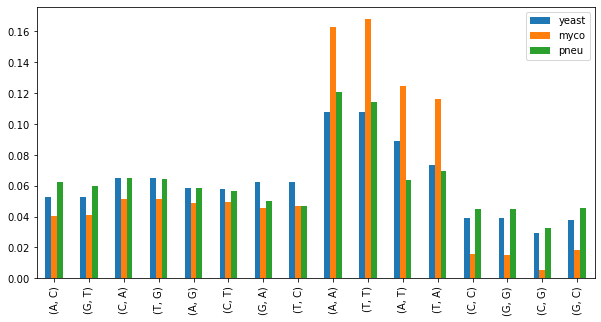

In [9]:
plot_utils.plot_2mer_df(freqs_ref, columns=['yeast', 'myco', 'pneu'])

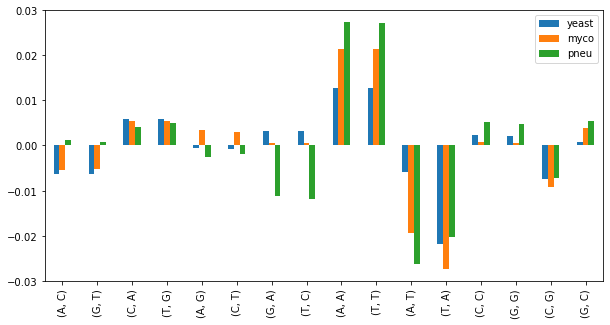

In [10]:
freqs_diff = freqs_ref.loc[:, 'yeast':'pneu'] - freqs_ref.loc[:, 'rand_nuc_yeast':'rand_nuc_pneu'].rename({freqs_ref.columns[i+3]: freqs_ref.columns[i] for i in range(3)}, axis=1)
plot_utils.plot_2mer_df(freqs_diff, columns=['yeast', 'myco', 'pneu'])

Generate sequences with specific kmer frequencies and test it

In [ ]:
n_seqs = 32
seq_length = 32768
reference = 'myco'
seqs = utils.random_sequences(n_seqs, seq_length, nucs.loc[:, reference], dinucs.loc[:, reference])
freqs = utils.kmer_counts(utils.one_hot_encoding(seqs, seq_length), k=2, includeN=False)
freqs /= freqs.sum()
freqs

In [ ]:
freqs_ref.loc[:, 'myco'] - freqs

In [131]:
# Generate genomes with same length and content as yeast
one_hots = {}
with np.load(Path(data_dir, species, 'genome', 'W303', 'W303.npz')) as f:
    for chr_id in f.keys():
        if chr_id[:3] == 'chr':
            one_hots[chr_id] = utils.random_shuffles(f[chr_id], 1)[0]
np.savez(Path(data_dir, species, 'results', 'models_etienne', 'random_seqs', 'random_genome_as_yeast1.npz'), **one_hots)

In [32]:
# Predict on genomes with same length and content as yeast
annotation_type = 'pol'
if annotation_type == 'nucleosome':
    model_files = [Path(data_dir, species, 'models_etienne', 'weights_myco_rep1.hdf5'),
                   Path(data_dir, species, 'models_etienne', 'weights_nucleosome_myco_rep2.hdf5'),
                   Path(data_dir, species, 'models_etienne', 'weights_nucleosome_myco_rep3.hdf5')]
    custom_objects = {'correlate' : correlate, 'mae_cor' : mae_cor}
elif annotation_type == 'cohesine':
    model_files = [Path(data_dir, species, 'models_etienne', 'weights_myco_rep1_cohesine.hdf5'),
                    Path(data_dir, species, 'models_etienne', 'weights_myco_rep1_cohesine_2.hdf5'),
                    Path(data_dir, species, 'models_etienne', 'weights_myco_rep1_cohesine_3.hdf5')]
    custom_objects = {'correlate' : correlate}
elif annotation_type == 'pol':
    model_files = [Path(data_dir, species, 'models_etienne', 'weights_myco_pol2_2048_16.hdf5'),
                    Path(data_dir, species, 'models_etienne', 'weights_myco_pol2_2048_16_2.hdf5'),
                    Path(data_dir, species, 'models_etienne', 'weights_myco_pol2_2048_16_3.hdf5')]
    custom_objects = {'correlate' : correlate}
else:
    raise ValueError('annotation_type must be "nucleosome", "cohesine" or "pol"')

one_hots = {}
preds = {}
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'random_seqs', 'random_genome_as_yeast1.npz')) as f:
    for chr_id in f.keys():
        one_hots[chr_id] = f[chr_id]
        preds[chr_id] = np.empty((len(one_hots[chr_id]), 3), dtype='float32')

for model_idx, model_file in enumerate(model_files):
    print('model', model_idx)
    for chr_id, one_hot in one_hots.items():
        model = tf.keras.models.load_model(model_file, custom_objects=custom_objects)
        preds[chr_id][:, model_idx] = predict(one_hot, model, annotation_type)
    del model
np.who(preds)
np.savez(Path(data_dir, species, 'results', 'models_etienne', 'random_seqs', f'preds_all_reps_myco_{annotation_type}_on_random_genome_as_yeast1.npz'),
         **preds)


model 0
model 1
model 2
Name            Shape             Bytes            Type

chr01           252221 x 3        3026652          float32
chr02           844051 x 3        10128612         float32
chr03           341087 x 3        4093044          float32
chr04           1575129 x 3       18901548         float32
chr05           572496 x 3        6869952          float32
chr06           277781 x 3        3333372          float32
chr07           1092105 x 3       13105260         float32
chr08           564939 x 3        6779268          float32
chr09           430780 x 3        5169360          float32
chr10           762303 x 3        9147636          float32
chr11           683383 x 3        8200596          float32
chr12           1084257 x 3       13011084         float32
chr13           929095 x 3        11149140         float32
chr14           793416 x 3        9520992          float32
chr15           1108329 x 3       13299948         float32
chr16           986200 x 3        

In [15]:
# Generate sequences with similar 2mer distributions
annotation_type = 'pol'
if annotation_type == 'nucleosome':
    order = 'ATGC'
    n_seqs = 1000
    WINDOW = 2001
    shape = (-1, WINDOW, 1, 4)
    model_files = [Path(data_dir, species, 'models_etienne', 'weights_myco_rep1.hdf5'),
                   Path(data_dir, species, 'models_etienne', 'weights_nucleosome_myco_rep2.hdf5'),
                   Path(data_dir, species, 'models_etienne', 'weights_nucleosome_myco_rep3.hdf5')]
    custom_objects = {'correlate' : correlate, 'mae_cor' : mae_cor}
else:
    if annotation_type == 'cohesine':
        order = 'ACGT'
        n_seqs = 32
        WINDOW = 32768
        shape = (-1, WINDOW, 4)
        model_files = [Path(data_dir, species, 'models_etienne', 'weights_myco_rep1_cohesine.hdf5'),
                       Path(data_dir, species, 'models_etienne', 'weights_myco_rep1_cohesine_2.hdf5'),
                       Path(data_dir, species, 'models_etienne', 'weights_myco_rep1_cohesine_3.hdf5')]
        custom_objects = {'correlate' : correlate}
    elif annotation_type == 'pol':
        order = 'ACGT'
        n_seqs = 32
        WINDOW = 2048
        shape = (-1, WINDOW, 4)
        model_files = [Path(data_dir, species, 'models_etienne', 'weights_myco_pol2_2048_16.hdf5'),
                       Path(data_dir, species, 'models_etienne', 'weights_myco_pol2_2048_16_2.hdf5'),
                       Path(data_dir, species, 'models_etienne', 'weights_myco_pol2_2048_16_3.hdf5')]
        custom_objects = {'correlate' : correlate}
    else:
        raise ValueError('annotation_type must be "nucleosome", "cohesine" or "pol"')

refs = ['yeast', 'myco', 'pneu']
seqs = []
for ref in refs:
    seqs.append(utils.random_sequences(n_seqs, WINDOW, nucs.loc[:, ref], dinucs.loc[:, ref]))
seqs = np.concatenate(seqs, axis=0)
one_hots = utils.one_hot_encoding(seqs, read_length=WINDOW, one_hot_type=int, order=order).reshape(shape)
preds = []
for model_file in model_files:
    model = tf.keras.models.load_model(model_file, custom_objects=custom_objects)
    pred = model.predict(one_hots).reshape(len(refs), -1)
    del model
    preds.append(pred)
preds = np.concatenate(preds, axis=1)
# np.save(Path(data_dir, species, 'results', 'models_etienne', 'random_seqs', f'preds_all_reps_myco_{annotation_type}_random_2mer_as_refs_indep_{n_seqs}.npy'), preds)

In [37]:
# Generate independent windows for different gc
annotation_type = 'nucleosome'
if annotation_type == 'nucleosome':
    order = 'ATGC'
    n_seqs = 10000
    WINDOW = 2001
    shape = (-1, WINDOW, 1, 4)
    model_files = [Path(data_dir, species, 'models_etienne', 'weights_myco_rep1.hdf5'),
                   Path(data_dir, species, 'models_etienne', 'weights_nucleosome_myco_rep2.hdf5'),
                   Path(data_dir, species, 'models_etienne', 'weights_nucleosome_myco_rep3.hdf5')]
    custom_objects = {'correlate' : correlate, 'mae_cor' : mae_cor}
else:
    if annotation_type == 'cohesine':
        order = 'ACGT'
        n_seqs = 32
        WINDOW = 32768
        shape = (-1, WINDOW, 4)
        model_files = [Path(data_dir, species, 'models_etienne', 'weights_myco_rep1_cohesine.hdf5'),
                       Path(data_dir, species, 'models_etienne', 'weights_myco_rep1_cohesine_2.hdf5'),
                       Path(data_dir, species, 'models_etienne', 'weights_myco_rep1_cohesine_3.hdf5')]
        custom_objects = {'correlate' : correlate}
    elif annotation_type == 'pol':
        order = 'ACGT'
        n_seqs = 32
        WINDOW = 2048
        shape = (-1, WINDOW, 4)
        model_files = [Path(data_dir, species, 'models_etienne', 'weights_myco_pol2_2048_16.hdf5'),
                       Path(data_dir, species, 'models_etienne', 'weights_myco_pol2_2048_16_2.hdf5'),
                       Path(data_dir, species, 'models_etienne', 'weights_myco_pol2_2048_16_3.hdf5')]
        custom_objects = {'correlate' : correlate}
    else:
        raise ValueError('annotation_type must be "nucleosome", "cohesine" or "pol"')

n_gcs = 21
gcs = np.linspace(0, 1, n_gcs)
seqs = []
for gc in gcs:
    seqs.append(utils.random_seq_strict_GC(n_seqs, WINDOW, gc))
seqs = np.concatenate(seqs, axis=0)
one_hots = utils.one_hot_encoding(seqs, read_length=WINDOW, one_hot_type=int, order=order).reshape(shape)
np.save(Path(data_dir, species, 'results', 'models_etienne', 'random_seqs', f'seqs_all_reps_myco_{annotation_type}_random_strictGCrange_indep_{n_seqs}.npy'), one_hots)
preds = []
for model_file in model_files:
    model = tf.keras.models.load_model(model_file, custom_objects=custom_objects)
    pred = model.predict(one_hots).reshape(n_gcs, -1)
    del model
    preds.append(pred)
preds = np.concatenate(preds, axis=1)
np.save(Path(data_dir, species, 'results', 'models_etienne', 'random_seqs', f'preds_all_reps_myco_{annotation_type}_random_strictGCrange_indep_{n_seqs}.npy'), preds)

2023-04-03 14:17:55.691914: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 13446720000 exceeds 10% of free system memory.
2023-04-03 14:18:08.338724: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 13446720000 exceeds 10% of free system memory.
2023-04-03 14:18:20.933234: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 13446720000 exceeds 10% of free system memory.


In [84]:
# Generate a sequence and change to ployA in the middle
annotation_type = 'nucleosome'
if annotation_type == 'nucleosome':
    n_windows = 10_000
    WINDOW = 2001
    model_file = Path(data_dir, species, 'models_etienne', 'weights_myco_rep1.hdf5')
    model = tf.keras.models.load_model(model_file, custom_objects={'correlate' : correlate, 'mae_cor' : mae_cor})
    order = 'ATGC'
    buffer = WINDOW // 2
    seq_length = buffer*2 + n_windows
else:
    if annotation_type == 'cohesine':
        WINDOW = 32768
        n_windows = 10
        model_file = Path(data_dir, species, 'models_etienne', 'weights_myco_rep1_cohesine.hdf5')
    elif annotation_type == 'pol':
        WINDOW = 2048
        n_windows = 100
        model_file = Path(data_dir, species, 'models_etienne', 'weights_myco_pol2_2048_16.hdf5')
    else:
        raise ValueError('annotation_type must be "nucleosome", "cohesine" or "pol"')
    model = tf.keras.models.load_model(model_file, custom_objects={'correlate' : correlate})
    order = 'ACGT'
    buffer = 0
    seq_length = WINDOW * n_windows

n_seqs = 100
n_As = 6
seq_length = 2001*2 + n_As - 2
n_gcs = 1 # 21
gcs = [0.38] # np.linspace(0, 1, n_gcs)
preds = []
preds_save = []
for gc in gcs:
    p = [(1-gc)/2, gc/2, gc/2, (1-gc)/2]
    seqs = np.random.choice(['A', 'C', 'G', 'T'], (n_seqs, seq_length), p=p)
    seqs_save = seqs.copy()
    seqs[:, seq_length//2 - n_As//2 : seq_length//2 + n_As//2] = 'A'
    one_hots_save = utils.one_hot_encoding(seqs_save, read_length=seq_length, one_hot_type=int, order=order)
    one_hots = utils.one_hot_encoding(seqs, read_length=seq_length, one_hot_type=int, order=order)
    for one_hot in one_hots:
        pred = predict(one_hot, model, annotation_type, last_window=True)
        preds.append(pred[buffer:len(pred)-buffer])
    for one_hot in one_hots_save:
        pred = predict(one_hot, model, annotation_type, last_window=True)
        preds_save.append(pred[buffer:len(pred)-buffer])
del model
preds = np.array(preds)
preds_save = np.array(preds_save)
print(preds.shape)
np.save(Path(data_dir, species, 'results', 'models_etienne', 'random_seqs', f'preds_{model_file.stem}_randomGC0.38_{n_seqs}seqs_len{seq_length}_with{n_As}As.npy'), preds)
np.save(Path(data_dir, species, 'results', 'models_etienne', 'random_seqs', f'preds_{model_file.stem}_randomGC0.38_{n_seqs}seqs_len{seq_length}_without{n_As}As.npy'), preds_save)

(100, 2006)


Load predictions on random sequences

In [248]:
WINDOW = 2001
one_hots = np.load(Path(data_dir, species, 'results', 'models_etienne', 'random_seqs', 'seqs_all_reps_myco_nucleosome_random_strictGCrange_indep_10000.npy'))
one_hots = one_hots.reshape(21, -1, WINDOW, 4)
preds = np.load(Path(data_dir, species, 'results', 'models_etienne', 'random_seqs', 'preds_all_reps_myco_nucleosome_random_strictGCrange_indep_10000.npy'))
preds = preds.reshape(21, 3, -1)
one_hots.shape, preds.shape

((21, 10000, 2001, 4), (21, 3, 10000))

In [253]:
gc_eff = utils.GC_content(one_hots[8], order='ATGC')
len(np.unique(gc_eff))

1

1000 1000


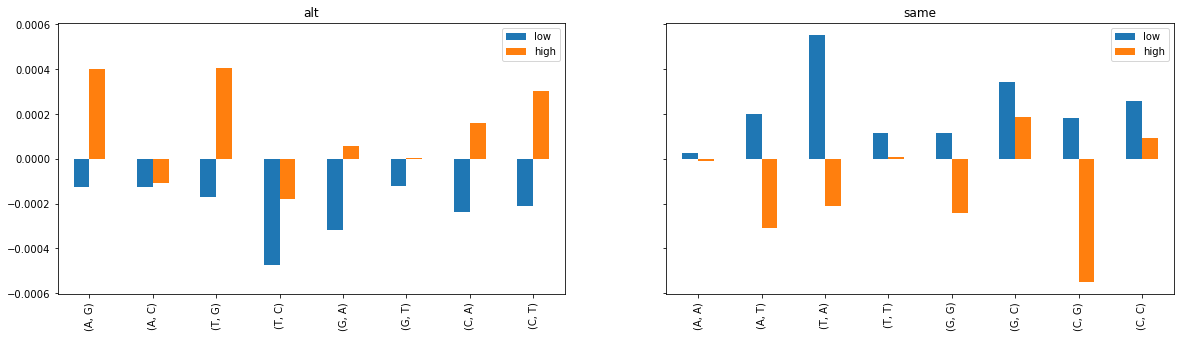

In [83]:
gc_idx = 8
preds_gc = preds.mean(axis=1)[gc_idx]
q10, q45, q55, q90 = np.quantile(preds_gc, [0.1, 0.45, 0.55, 0.9])
low_idx = np.where(preds_gc < q10)[0]
lows = one_hots[gc_idx, low_idx]
mid_idx = np.where((q45 < preds_gc) & (preds_gc < q55))[0]
mids = one_hots[gc_idx, mid_idx]
high_idx = np.where(preds_gc > q90)[0]
highs = one_hots[gc_idx, high_idx]
print(len(low_idx), len(mid_idx), len(high_idx))

df = pd.concat({
    'low': utils.kmer_counts(lows, k=2, order='ATGC', includeN=False),
    'mid': utils.kmer_counts(mids, k=2, order='ATGC', includeN=False),
    'high': utils.kmer_counts(highs, k=2, order='ATGC', includeN=False),
    }, axis=1)
df /= df.sum(axis=0)
diffs = df - df['mid'].values[:, None]
diffs['nextgc'] = ['same', 'same', 'alt', 'alt']*2 + ['alt', 'alt', 'same', 'same']*2

fig, axes = plt.subplots(1, 2, sharey='row', figsize=(20, 5), facecolor='w')
for (key, grp), ax in zip(diffs.groupby('nextgc'), axes.flatten()):
    grp.plot(kind='bar', y=['low', 'high'], ax=ax, title=key)

In [120]:
start_idx = 4
stop_idx = 11
preds_gc = preds[start_idx:stop_idx, 0]
q50 = np.quantile(preds_gc, 0.5, axis=1, keepdims=True)
low_gc_idx, low_pred_idx = (preds_gc < q50).nonzero()
lows = one_hots[start_idx + low_gc_idx, low_pred_idx].reshape(stop_idx - start_idx, -1, WINDOW, 4)
high_gc_idx, high_pred_idx = (preds_gc > q50).nonzero()
highs = one_hots[start_idx + high_gc_idx, high_pred_idx].reshape(stop_idx - start_idx, -1, WINDOW, 4)
print(highs.shape)
df_dict = {}
for i in range(stop_idx-start_idx):
    serh = utils.kmer_counts(highs[i], k=2, order='ATGC', includeN=False)
    serh /= serh.sum(axis=0)
    serl = utils.kmer_counts(lows[i], k=2, order='ATGC', includeN=False)
    serl /= serl.sum(axis=0)
    df_dict[f'gc{round(0.05*(start_idx + i), 2)}'] = serh -serl
df = pd.concat(df_dict, axis=1)
df['nextgc'] = ['same', 'same', 'alt', 'alt']*2 + ['alt', 'alt', 'same', 'same']*2
df

(7, 5000, 2001, 4)


gc0.2    gc0.25         gc0.3    gc0.35     gc0.4    gc0.45     gc0.5  \
A A  0.000033  0.000105  7.710000e-05  0.000111  0.000148 -0.000263 -0.000285   
  T -0.000168 -0.000174 -3.824000e-04 -0.000248 -0.000410 -0.000142 -0.000129   
  G -0.000019  0.000051  1.764000e-04  0.000131  0.000124  0.000324  0.000277   
  C  0.000161  0.000014  1.282000e-04  0.000006  0.000137  0.000080  0.000134   
T A -0.000282 -0.000013 -1.820000e-04 -0.000413 -0.000251 -0.000054 -0.000085   
  T  0.000155 -0.000064  1.545000e-04 -0.000014  0.000033 -0.000150 -0.000144   
  G  0.000128  0.000080  8.340000e-05  0.000241  0.000215  0.000133  0.000239   
  C -0.000008 -0.000001 -5.330000e-05  0.000187 -0.000004  0.000071  0.000004   
G A -0.000016 -0.000057 -1.000000e-07  0.000256  0.000010  0.000224  0.000169   
  T  0.000057  0.000158  8.010000e-05  0.000021  0.000106 -0.000022  0.000054   
  G -0.000023 -0.000066 -1.906000e-04 -0.000195 -0.000081 -0.000158 -0.000142   
  C -0.000020 -0.000037  1.094000e-04 -0.000081 -0.000035 -0.000045 -0.000092   
C A  0.000264 -0.000037  9.600000e-05  0.000046  0.000091  0.000091  0.000201   
  T -0.000045  0.000075  1.480000e-04  0.000242  0.000279  0.000313  0.000209   
  G -0.000084 -0.000061 -6.770000e-05 -0.000176 -0.000259 -0.000298 -0.000367   
  C -0.000132  0.000027 -1.770000e-04 -0.000113 -0.000105 -0.000103 -0.000043   

    nextgc  
A A   same  
  T   same  
  G    alt  
  C    alt  
T A   same  
  T   same  
  G    alt  
  C    alt  
G A    alt  
  T    alt  
  G   same  
  C   same  
C A    alt  
  T    alt  
  G   same  
  C   same

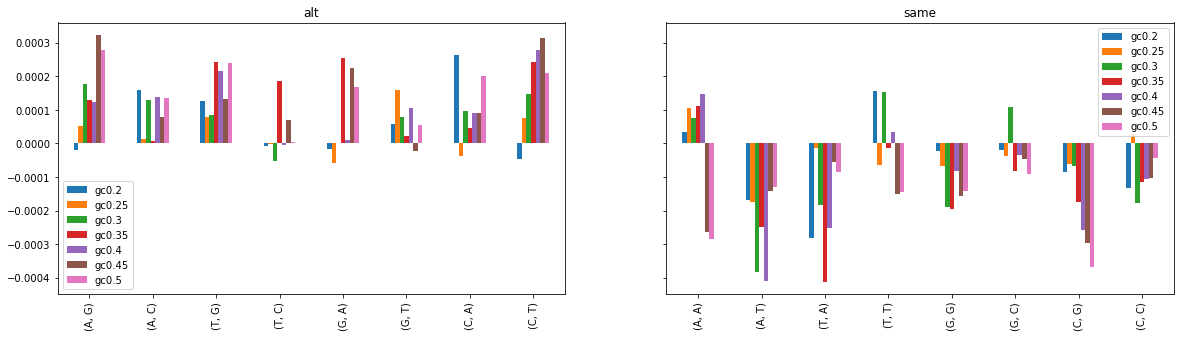

In [121]:
fig, axes = plt.subplots(1, 2, sharey='row', figsize=(20, 5), facecolor='w')
for (key, grp), ax in zip(df.groupby('nextgc'), axes.flatten()):
    grp.plot(kind='bar', ax=ax, title=key)

5000 5000


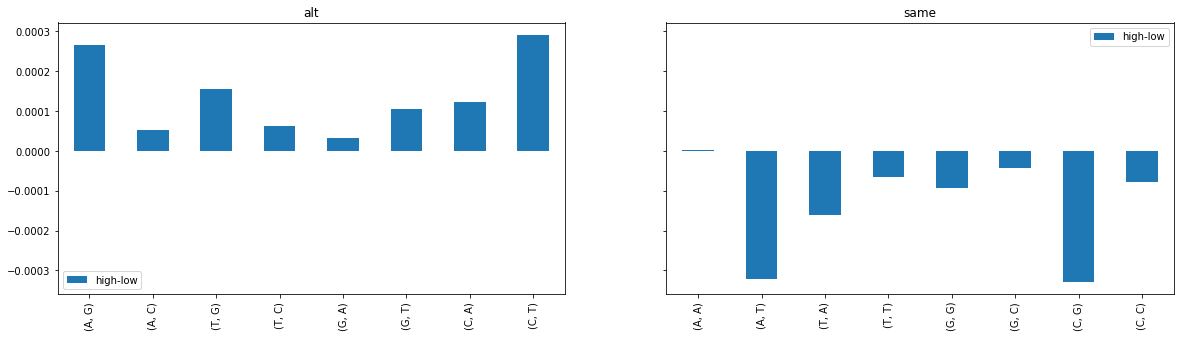

In [254]:
gc_idx = 8
preds_gc = preds.mean(axis=1)[gc_idx]
q50 = np.quantile(preds_gc, 0.5)
low_idx = np.where(preds_gc < q50)[0]
lows = one_hots[gc_idx, low_idx]
high_idx = np.where(preds_gc > q50)[0]
highs = one_hots[gc_idx, high_idx]
print(len(low_idx), len(high_idx))

df = pd.concat({
    'low': utils.kmer_counts(lows, k=2, order='ATGC', includeN=False),
    'high': utils.kmer_counts(highs, k=2, order='ATGC', includeN=False),
    }, axis=1)
df /= df.sum(axis=0)
df['high-low'] = df.loc[:, 'high'] - df.loc[:, 'low']
df['nextgc'] = ['same', 'same', 'alt', 'alt']*2 + ['alt', 'alt', 'same', 'same']*2

fig, axes = plt.subplots(1, 2, sharey='row', figsize=(20, 5), facecolor='w')
for (key, grp), ax in zip(df.groupby('nextgc'), axes.flatten()):
    grp.plot(kind='bar', y=['high-low'], ax=ax, title=key)

In [256]:
df1 = pd.concat({
    'lows': utils.kmer_counts(lows, k=1, order='ATGC', includeN=False),
    # 'mids': utils.kmer_counts(mids, k=1, order='ATGC', includeN=False),
    'highs': utils.kmer_counts(highs, k=1, order='ATGC', includeN=False),
    }, axis=1)
df1

,lows,highs
A,3005000,3005000
T,3000000,3000000
G,2000000,2000000
C,2000000,2000000


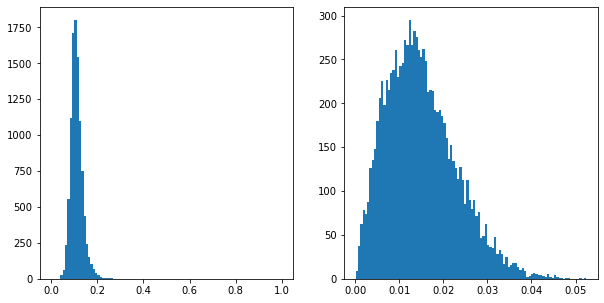

In [72]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.hist(preds.mean(axis=1)[gc_idx], bins=100, range=(0, 1))
plt.subplot(122)
plt.hist(preds.std(axis=1)[gc_idx], bins=100)
plt.show()
plt.close()

Making plot for Romain with predictions on random sequences, labels and predictions

In [6]:
preds_nuc_rand_sim = np.load(Path(data_dir, species, 'results', 'models_etienne', 'random_seqs', 'preds_all_reps_myco_nucleosome_random_2mer_as_refs_indep_1000.npy'))
preds_coh_rand_sim = np.load(Path(data_dir, species, 'results', 'models_etienne', 'random_seqs', 'preds_all_reps_myco_cohesine_random_2mer_as_refs_indep_32.npy'))
preds_pol_rand_sim = np.load(Path(data_dir, species, 'results', 'models_etienne', 'random_seqs', 'preds_all_reps_myco_pol_random_2mer_as_refs_indep_32.npy'))
preds_nuc_rand_sim.shape, preds_coh_rand_sim.shape, preds_pol_rand_sim.shape

((3, 3000), (3, 24576), (3, 1536))

In [7]:
# Random preds for original plot
preds_nuc_rand2 = np.load(Path(data_dir, species, 'results', 'models_etienne', 'random_seqs', 'preds_all_reps_myco_nucleosome_randomGC_indep_10000.npy'))
preds_coh_rand2 = np.load(Path(data_dir, species, 'results', 'models_etienne', 'random_seqs', 'preds_all_reps_myco_cohesine_randomGC_indep_32.npy'))
preds_pol_rand2 = np.load(Path(data_dir, species, 'results', 'models_etienne', 'random_seqs', 'preds_all_reps_myco_pol_randomGC_indep_32.npy'))

preds_nuc_rand = np.load(Path(data_dir, species, 'results', 'models_etienne', 'random_seqs', 'preds_all_reps_myco_nucleosome_random_strictGCrange_indep_10000.npy'))
preds_coh_rand = np.load(Path(data_dir, species, 'results', 'models_etienne', 'random_seqs', 'preds_all_reps_myco_cohesine_random_strictGCrange_indep_32.npy'))
preds_pol_rand = np.load(Path(data_dir, species, 'results', 'models_etienne', 'random_seqs', 'preds_all_reps_myco_pol_random_strictGCrange_indep_32.npy'))
preds_nuc_rand.shape, preds_coh_rand.shape, preds_pol_rand.shape

((21, 30000), (21, 24576), (21, 1536))

Plot predictions vs GC content on random and true sequences

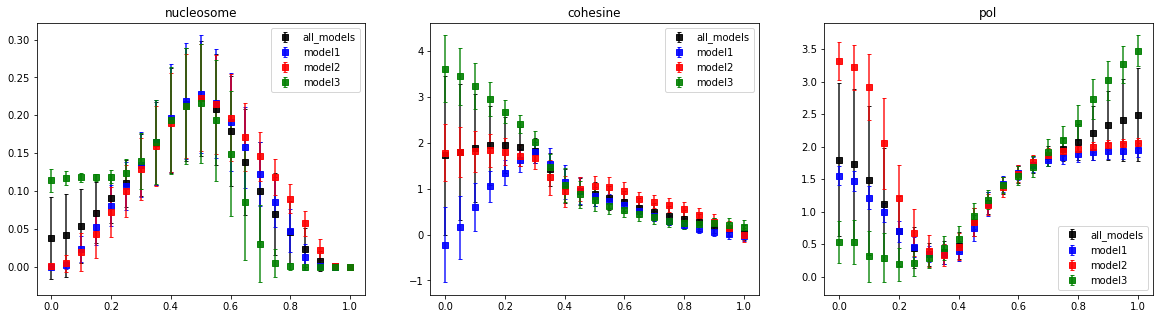

In [196]:
n_gcs = len(preds_nuc_rand)
gcs = np.linspace(0, 1, n_gcs)
q_min, q_max = 0.1, 0.9
plt.figure(figsize=(20, 5))
plt.subplot(131)
plt.title('nucleosome')
mean_nuc_rand = preds_nuc_rand.mean(axis=1)
plt.errorbar(gcs, y=mean_nuc_rand, yerr=preds_nuc_rand.std(axis=1), fmt='ks', alpha=0.9, label='all_models', capsize=2)
means_nuc_rand = preds_nuc_rand.reshape(n_gcs, 3, -1).mean(axis=2)
stds_nuc_rand = preds_nuc_rand.reshape(n_gcs, 3, -1).std(axis=2)
fmts = ['bs', 'rs', 'gs']
for i in range(3):
    plt.errorbar(gcs, y=means_nuc_rand[:, i], yerr=stds_nuc_rand[:, i], fmt=fmts[i], alpha=0.9, label=f'model{i+1}', capsize=2)
plt.legend()

plt.subplot(132)
plt.title('cohesine')
mean_coh_rand = preds_coh_rand.mean(axis=1)
plt.errorbar(gcs, y=mean_coh_rand, yerr=preds_coh_rand.std(axis=1), fmt='ks', alpha=0.9, label='all_models', capsize=2)
# plt.errorbar(gcs, y=preds_coh_rand.reshape(n_gcs, 3, -1)[:, :2, :].mean(axis=(1, 2)), yerr=preds_coh_rand.reshape(n_gcs, 3, -1)[:, :2, :].std(axis=(1, 2)), fmt='ks', alpha=0.9, label='all_models', capsize=2)
means_coh_rand = preds_coh_rand.reshape(n_gcs, 3, -1).mean(axis=2)
stds_coh_rand = preds_coh_rand.reshape(n_gcs, 3, -1).std(axis=2)
fmts = ['bs', 'rs', 'gs']
for i in range(3):
    plt.errorbar(gcs, y=means_coh_rand[:, i], yerr=stds_coh_rand[:, i], fmt=fmts[i], alpha=0.9, label=f'model{i+1}', capsize=2)
plt.legend()

plt.subplot(133)
plt.title('pol')
mean_pol_rand = preds_pol_rand.mean(axis=1)
plt.errorbar(gcs, y=mean_pol_rand, yerr=preds_pol_rand.std(axis=1), fmt='ks', alpha=0.9, label='all_models', capsize=2)
means_pol_rand = preds_pol_rand.reshape(n_gcs, 3, -1).mean(axis=2)
stds_pol_rand = preds_pol_rand.reshape(n_gcs, 3, -1).std(axis=2)
fmts = ['bs', 'rs', 'gs']
for i in range(3):
    plt.errorbar(gcs, y=means_pol_rand[:, i], yerr=stds_pol_rand[:, i], fmt=fmts[i], alpha=0.9, label=f'model{i+1}', capsize=2)
plt.legend()

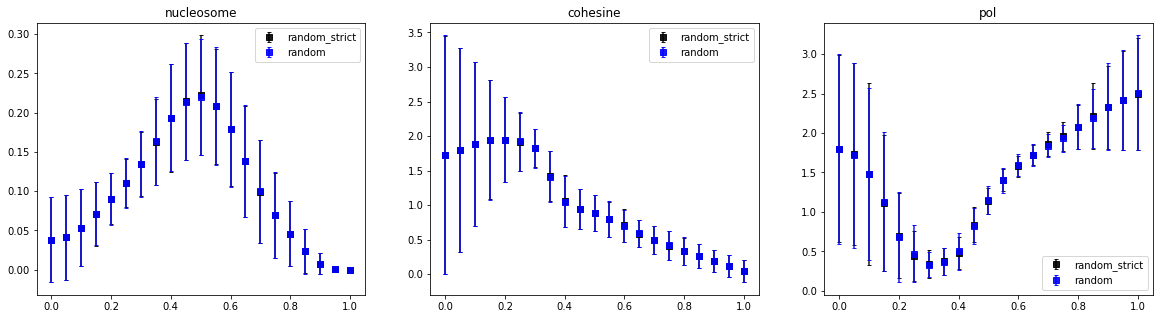

In [197]:
n_gcs = len(preds_nuc_rand)
gcs = np.linspace(0, 1, n_gcs)
plt.figure(figsize=(20, 5))
plt.subplot(131)
plt.title('nucleosome')
plt.errorbar(gcs, y=preds_nuc_rand.mean(axis=1), yerr=preds_nuc_rand.std(axis=1), fmt='ks', alpha=0.9, label='random_strict', capsize=2)
plt.errorbar(gcs, y=preds_nuc_rand2.mean(axis=1), yerr=preds_nuc_rand2.std(axis=1), fmt='bs', alpha=0.9, label='random', capsize=2)
plt.legend()

plt.subplot(132)
plt.title('cohesine')
plt.errorbar(gcs, y=preds_coh_rand.mean(axis=1), yerr=preds_coh_rand.std(axis=1), fmt='ks', alpha=0.9, label='random_strict', capsize=2)
plt.errorbar(gcs, y=preds_coh_rand2.mean(axis=1), yerr=preds_coh_rand2.std(axis=1), fmt='bs', alpha=0.9, label='random', capsize=2)
plt.legend()

plt.subplot(133)
plt.title('pol')
plt.errorbar(gcs, y=preds_pol_rand.mean(axis=1), yerr=preds_pol_rand.std(axis=1), fmt='ks', alpha=0.9, label='random_strict', capsize=2)
plt.errorbar(gcs, y=preds_pol_rand2.mean(axis=1), yerr=preds_pol_rand2.std(axis=1), fmt='bs', alpha=0.9, label='random', capsize=2)
plt.legend()

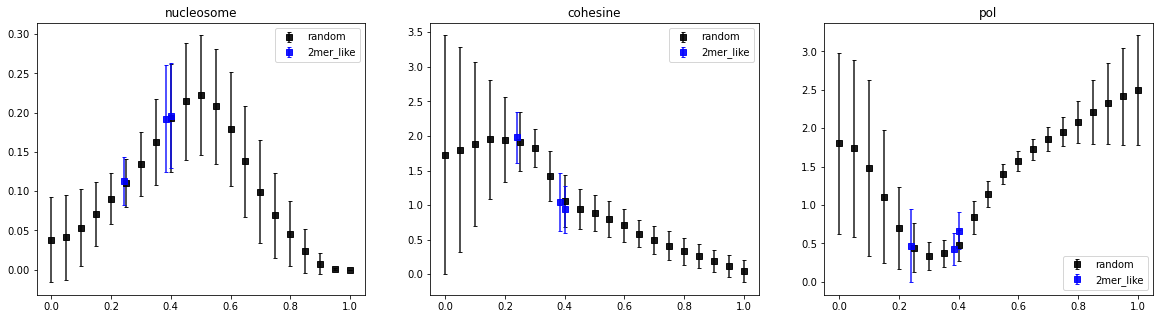

In [198]:
n_gcs = len(preds_nuc_rand)
gcs = np.linspace(0, 1, n_gcs)
gc_refs = np.concatenate([gc_yeast, gc_myco, gc_pneu])
plt.figure(figsize=(20, 5))
plt.subplot(131)
plt.title('nucleosome')
plt.errorbar(gcs, y=preds_nuc_rand.mean(axis=1), yerr=preds_nuc_rand.std(axis=1), fmt='ks', alpha=0.9, label='random', capsize=2)
plt.errorbar(gc_refs, y=preds_nuc_rand_sim.mean(axis=1), yerr=preds_nuc_rand_sim.std(axis=1), fmt='bs', alpha=0.9, label='2mer_like', capsize=2)
plt.legend()

plt.subplot(132)
plt.title('cohesine')
plt.errorbar(gcs, y=preds_coh_rand.mean(axis=1), yerr=preds_coh_rand.std(axis=1), fmt='ks', alpha=0.9, label='random', capsize=2)
plt.errorbar(gc_refs, y=preds_coh_rand_sim.mean(axis=1), yerr=preds_coh_rand_sim.std(axis=1), fmt='bs', alpha=0.9, label='2mer_like', capsize=2)
plt.legend()

plt.subplot(133)
plt.title('pol')
plt.errorbar(gcs, y=preds_pol_rand.mean(axis=1), yerr=preds_pol_rand.std(axis=1), fmt='ks', alpha=0.9, label='random', capsize=2)
plt.errorbar(gc_refs, y=preds_pol_rand_sim.mean(axis=1), yerr=preds_pol_rand_sim.std(axis=1), fmt='bs', alpha=0.9, label='2mer_like', capsize=2)
plt.legend()

Compute sliding GC content on all windows

In [49]:
window_gc_full = {}
with np.load(Path(data_dir, species, 'genome', 'W303', 'W303.npz')) as f:
    for chr_id in f.keys():
        window_gc_full[chr_id] = utils.sliding_GC(f[chr_id], 2000)

with np.load(Path(data_dir, species, 'genome', 'bacterie', 'Mmm_Linear_740kb.npz')) as f:
    window_gc_full['myco'] = utils.sliding_GC(f['chr1'], 2000)

with np.load(Path(data_dir, species, 'genome', 'bacterie', 'Pneu300.npz')) as f:
    window_gc_full['pneu'] = utils.sliding_GC(f['chr1'], 2000)

In [70]:
window_gc = {}
with np.load(Path(data_dir, species, 'genome', 'W303', 'W303.npz')) as f:
    for chr_id in f.keys():
        window_gc[chr_id] = utils.GC_content(utils.chunk_regions(f[chr_id],  2000))
window_gc_yeast = np.concatenate([v for k, v in window_gc.items() if k[:3]=='chr'])

with np.load(Path(data_dir, species, 'genome', 'bacterie', 'Mmm_Linear_740kb.npz')) as f:
    window_gc['myco'] = utils.GC_content(utils.chunk_regions(f['chr1'],  2000))

with np.load(Path(data_dir, species, 'genome', 'bacterie', 'Pneu300.npz')) as f:
    window_gc['pneu'] = utils.GC_content(utils.chunk_regions(f['chr1'],  2000))

In [11]:
window_gc_r = {}
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'random_seqs', 'random_genome_as_yeast1.npz')) as f:
    for chr_id in f.keys():
        window_gc_r[chr_id] = utils.GC_content(utils.chunk_regions(f[chr_id],  2000))
window_gc_rand = np.concatenate(list(window_gc_r.values()))

In [12]:
window_labels = {}
for key in labels_nuc.keys():
    window_labels[key] = np.mean(
        utils.chunk_regions(
            np.concatenate(
                [arr.reshape(-1, 1) for arr in (labels_nuc[key], labels_coh[key], labels_pol[key])],
                axis=1),
            2000),
        axis=1)
window_labels_yeast = np.concatenate([v for k, v in window_labels.items() if k[:3]=='chr'])

In [13]:
window_preds = {}
for key in preds_nuc.keys():
    window_preds[key] = np.mean(
        utils.chunk_regions(
            np.concatenate(
                [arr.reshape(-1, 1) for arr in (preds_nuc[key] / thres_pred_nm, preds_coh[key] / thres_pred_cm, preds_pol[key] / thres_pred_pm)],
                axis=1),
            2000),
        axis=1)
window_preds_yeast = np.concatenate([v for k, v in window_preds.items() if k[:3]=='chr'])

Concatenate yeast chromosomes

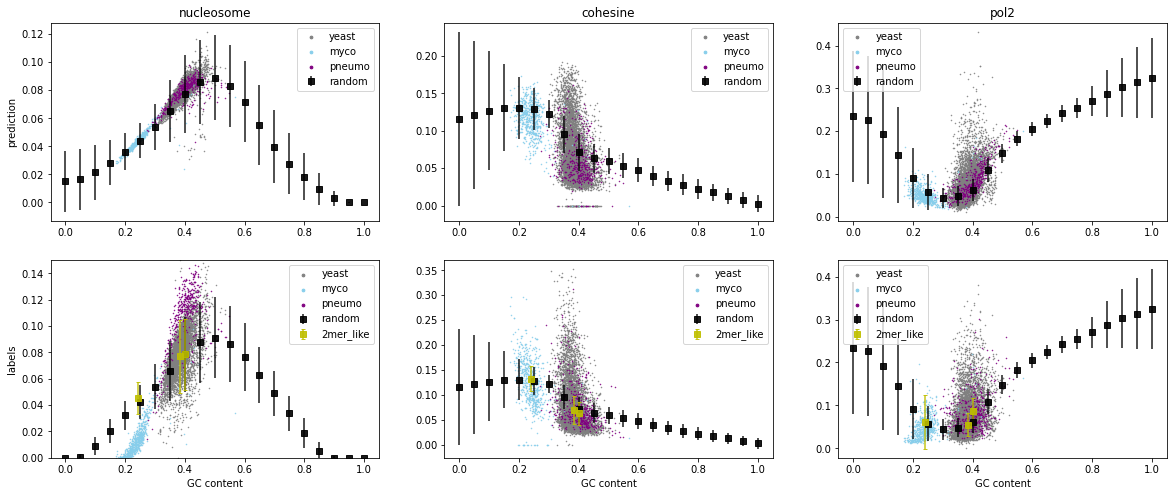

In [76]:
n_gcs = len(preds_nuc_rand)
gcs = np.linspace(0, 1, n_gcs)
gc_refs = np.concatenate([gc_yeast, gc_myco, gc_pneu])
plt.figure(figsize=(20, 8))
titles = ['nucleosome', 'cohesine', 'pol2']
s = 1
s_yeast = 1
for i in range(3):
    plt.subplot(231+i)
    plt.title(titles[i])
    if i == 0:
        plt.errorbar(gcs, y=(preds_nuc_rand / thres_pred_nm).mean(axis=1), yerr=(preds_nuc_rand / thres_pred_nm).std(axis=1), fmt='ks', alpha=0.9, label='random')
        # plt.errorbar(gc_refs, y=(preds_nuc_rand_sim / thres_pred_nm).mean(axis=1), yerr=(preds_nuc_rand_sim / thres_pred_nm).std(axis=1), fmt='ys', alpha=0.9, label='2mer_like', capsize=2)
    elif i == 1:
        plt.errorbar(gcs, y=(preds_coh_rand / thres_pred_cm).mean(axis=1), yerr=(preds_coh_rand / thres_pred_cm).std(axis=1), fmt='ks', alpha=0.9, label='random')
        # plt.errorbar(gc_refs, y=(preds_coh_rand_sim / thres_pred_cm).mean(axis=1), yerr=(preds_coh_rand_sim / thres_pred_cm).std(axis=1), fmt='ys', alpha=0.9, label='2mer_like', capsize=2)
    else:
        plt.errorbar(gcs, y=(preds_pol_rand / thres_pred_pm).mean(axis=1), yerr=(preds_pol_rand / thres_pred_pm).std(axis=1), fmt='ks', alpha=0.9, label='random')
        # plt.errorbar(gc_refs, y=(preds_pol_rand_sim / thres_pred_pm).mean(axis=1), yerr=(preds_pol_rand_sim / thres_pred_pm).std(axis=1), fmt='ys', alpha=0.9, label='2mer_like', capsize=2)
    plt.scatter(window_gc_yeast, window_preds_yeast[:, i], marker='.', color='gray', label='yeast', s=s_yeast)
    plt.scatter(window_gc['myco'], window_preds['myco'][:, i], marker='.', color='skyblue', label='myco', s=s)
    plt.scatter(window_gc['pneu'], window_preds['pneu'][:, i], marker='.', color='purple', label='pneumo', s=s)
    if i == 0:
        plt.ylabel('prediction')
    leg = plt.legend()
    for legh in leg.legendHandles[:3]:
        legh.set_sizes([30])
for i in range(3):
    plt.subplot(234+i)
    if i == 0:
        plt.errorbar(gcs, y=(preds_nuc_rand / thres_pred_nm).reshape(n_gcs, 3, -1).mean(axis=2)[:, 0], yerr=(preds_nuc_rand / thres_pred_nm).reshape(n_gcs, 3, -1).std(axis=2)[:, 0], fmt='ks', alpha=0.9, label='random')
        plt.errorbar(gc_refs, y=(preds_nuc_rand_sim / thres_pred_nm).mean(axis=1), yerr=(preds_nuc_rand_sim / thres_pred_nm).std(axis=1), fmt='ys', alpha=0.9, label='2mer_like', capsize=2)
    elif i == 1:
        plt.errorbar(gcs, y=(preds_coh_rand / thres_pred_cm).mean(axis=1), yerr=(preds_coh_rand / thres_pred_cm).std(axis=1), fmt='ks', alpha=0.9, label='random')
        plt.errorbar(gc_refs, y=(preds_coh_rand_sim / thres_pred_cm).mean(axis=1), yerr=(preds_coh_rand_sim / thres_pred_cm).std(axis=1), fmt='ys', alpha=0.9, label='2mer_like', capsize=2)
    else:
        plt.errorbar(gcs, y=(preds_pol_rand / thres_pred_pm).mean(axis=1), yerr=(preds_pol_rand / thres_pred_pm).std(axis=1), fmt='ks', alpha=0.9, label='random')
        plt.errorbar(gc_refs, y=(preds_pol_rand_sim / thres_pred_pm).mean(axis=1), yerr=(preds_pol_rand_sim / thres_pred_pm).std(axis=1), fmt='ys', alpha=0.9, label='2mer_like', capsize=2)
    plt.scatter(window_gc_yeast, window_labels_yeast[:, i], marker='.', color='gray', label='yeast', s=s_yeast)
    plt.scatter(window_gc['myco'], window_labels['myco'][:, i], marker='.', color='skyblue', label='myco', s=s)
    plt.scatter(window_gc['pneu'], window_labels['pneu'][:, i], marker='.', color='purple', label='pneumo', s=s)
    if i == 0:
        plt.ylabel('labels')
        plt.ylim((0, 0.15))
    plt.xlabel('GC content')
    leg = plt.legend()
    for legh in leg.legendHandles[:3]:
        legh.set_sizes([30])
plt.show()
plt.close()


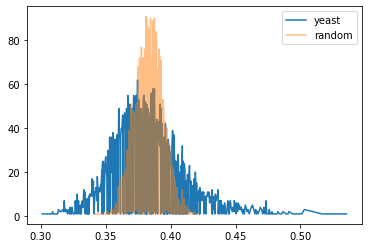

In [14]:
gcs, counts = np.unique(window_gc_yeast, return_counts=True)
gcs_r, counts_r = np.unique(window_gc_rand, return_counts=True)
plt.plot(gcs, counts, label='yeast')
plt.plot(gcs_r, counts_r, alpha=0.5, label='random')
plt.legend()
plt.show()
plt.close()

(0.0, 0.2)

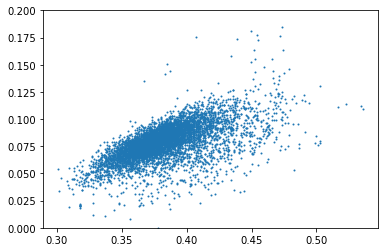

In [15]:
plt.scatter(window_gc_yeast, window_labels_yeast[:, 0], s=1)
plt.ylim((0, 0.2))

In [16]:
np.sum(counts // 2)

2921

kmer analysis by bin on true sequences

In [248]:
binsize = 100

window_one_hot = {}
with np.load(Path(data_dir, species, 'genome', 'W303', 'W303.npz')) as f:
    for chr_id in f.keys():
        window_one_hot[chr_id] = utils.chunk_regions(f[chr_id], binsize)
window_one_hot_yeast = np.concatenate([v for k, v in window_one_hot.items() if k[:3]=='chr'], axis=0)
window_gc_yeast = utils.GC_content(window_one_hot_yeast)
noN_mask = np.sum(window_one_hot_yeast, axis=(1, 2)) == binsize

with np.load(Path(data_dir, species, 'genome', 'bacterie', 'Mmm_Linear_740kb.npz')) as f:
    window_one_hot_myco = utils.chunk_regions(f['chr1'], binsize)
window_gc_myco = utils.GC_content(window_one_hot_myco)

with np.load(Path(data_dir, species, 'genome', 'bacterie', 'Pneu300.npz')) as f:
    window_one_hot_pneu = utils.chunk_regions(f['chr1'], binsize)
window_gc_pneu = utils.GC_content(window_one_hot_pneu)

window_labels = {}
for key in labels_nuc.keys():
    window_labels[key] = np.mean(
        utils.chunk_regions(
            np.concatenate(
                [arr.reshape(-1, 1) for arr in (labels_nuc[key], labels_coh[key], labels_pol[key])],
                axis=1),
            binsize),
        axis=1)
window_labels_yeast = np.concatenate([v for k, v in window_labels.items() if k[:3]=='chr'])

window_preds = {}
for key in preds_nuc.keys():
    window_preds[key] = np.mean(
        utils.chunk_regions(
            np.concatenate(
                [arr.reshape(-1, 1) for arr in (preds_nuc[key] / thres_pred_nm, preds_coh[key] / thres_pred_cm, preds_pol[key] / thres_pred_pm)],
                axis=1),
            binsize),
        axis=1)
window_preds_yeast = np.concatenate([v for k, v in window_preds.items() if k[:3]=='chr'])


# window_one_hot_r = {}
# with np.load(Path(data_dir, species, 'results', 'models_etienne', 'random_seqs', 'random_genome_as_yeast1.npz')) as f:
#     for chr_id in f.keys():
#         window_one_hot_r[chr_id] = utils.chunk_regions(f[chr_id],  binsize)
# window_one_hot_rand = np.concatenate(list(window_one_hot_r.values()))
# window_gc_rand = utils.GC_content(window_one_hot_rand)
# noN_mask_r = np.sum(window_one_hot_rand, axis=(1, 2)) == binsize

# window_preds_rand = {}
# fnuc = np.load(Path(data_dir, species, 'results', 'models_etienne', 'random_seqs', 'preds_all_reps_myco_nucleosome_on_random_genome_as_yeast1.npz'))
# fcoh = np.load(Path(data_dir, species, 'results', 'models_etienne', 'random_seqs', 'preds_all_reps_myco_cohesine_on_random_genome_as_yeast1.npz'))
# fpol = np.load(Path(data_dir, species, 'results', 'models_etienne', 'random_seqs', 'preds_all_reps_myco_pol_on_random_genome_as_yeast1.npz'))
# for key in fnuc.keys():
#     window_preds_rand[key] = np.mean(
#         utils.chunk_regions(
#             np.concatenate(
#                 [arr.reshape(-1, 1) for arr in (fnuc[key][:, 0] / thres_pred_nm, fcoh[key][:, 0] / thres_pred_cm, fpol[key][:, 0] / thres_pred_pm)],
#                 axis=1),
#             binsize),
#     axis=1)
# fnuc.close()
# fcoh.close()
# fpol.close()
# window_preds_rand = np.concatenate(list(window_preds_rand.values()))

In [249]:
window_yeast = pd.concat(
    [pd.DataFrame(window_labels_yeast, columns=['lab_nuc', 'lab_coh', 'lab_pol']),
     pd.DataFrame(window_preds_yeast, columns=['pred_nuc', 'pred_coh', 'pred_pol'])],
    axis=1)
window_yeast['gc'] = window_gc_yeast

window_myco = pd.concat(
    [pd.DataFrame(window_labels['myco'], columns=['lab_nuc', 'lab_coh', 'lab_pol']),
     pd.DataFrame(window_preds['myco'], columns=['pred_nuc', 'pred_coh', 'pred_pol'])],
    axis=1)
window_myco['gc'] = window_gc_myco

window_pneu = pd.concat(
    [pd.DataFrame(window_labels['pneu'], columns=['lab_nuc', 'lab_coh', 'lab_pol']),
     pd.DataFrame(window_preds['pneu'], columns=['pred_nuc', 'pred_coh', 'pred_pol'])],
    axis=1)
window_pneu['gc'] = window_gc_pneu

# window_rand = pd.DataFrame(window_preds_rand, columns=['pred_nuc_rand', 'pred_coh_rand', 'pred_pol_rand'])
# window_rand['gc_rand'] = window_gc_rand

window_yeast

,lab_nuc,lab_coh,lab_pol,pred_nuc,pred_coh,pred_pol,gc
0,0.000824,0.023280,0.062996,0.0,0.126754,0.164728,0.65
1,0.053242,0.019793,0.129147,0.0,0.121158,0.162809,0.63
2,0.033742,0.032933,0.000000,0.0,0.127759,0.156182,0.60
3,0.021519,0.083983,0.001428,0.0,0.138286,0.149134,0.52
4,0.156942,0.104781,0.017680,0.0,0.134914,0.151423,0.51
...,...,...,...,...,...,...,...
113101,0.045912,0.073153,0.014400,0.0,0.000000,0.032853,0.35
113102,0.123964,0.042143,0.053675,0.0,0.000000,0.021988,0.49
113103,0.074759,0.036083,0.064225,0.0,0.000000,0.000000,0.49
113104,0.070352,0.065475,0.062268,0.0,0.000000,0.000000,0.36


In [250]:
def seperate_low_high(window_gc, window_values, div=2):
    # Sort values by pred value
    sort_idx = np.argsort(window_values)
    sorted_gc = window_gc[sort_idx]
    # Create mask of values to take as low or high
    low_mask = np.zeros(len(sorted_gc), dtype=bool)
    high_mask = np.zeros(len(sorted_gc), dtype=bool)
    for gc, count in zip(*np.unique(window_gc, return_counts=True)):
        if count < div:
            continue
        gc_idxes = (sorted_gc == gc).nonzero()[0]
        low_mask[gc_idxes[:count // div]] = 1
        high_mask[gc_idxes[-(count // div):]] = 1
    # Reverse sort the mask
    revsort_idx = sort_idx.argsort()
    return low_mask[revsort_idx], high_mask[revsort_idx]

def seperate_3(window_gc, window_values):
    # Sort values by pred value
    sort_idx = np.argsort(window_values)
    sorted_gc = window_gc[sort_idx]
    # Create mask of values to take as low or high
    low_mask = np.zeros(len(sorted_gc), dtype=bool)
    mid_mask = np.zeros(len(sorted_gc), dtype=bool)
    high_mask = np.zeros(len(sorted_gc), dtype=bool)
    for gc, count in zip(*np.unique(window_gc, return_counts=True)):
        if count < 3:
            continue
        gc_idxes = (sorted_gc == gc).nonzero()[0]
        low_mask[gc_idxes[:count // 3]] = 1
        mid_mask[gc_idxes[count // 3 : -(count // 3)]] = 1
        high_mask[gc_idxes[-(count // 3):]] = 1
    # Reverse sort the mask
    revsort_idx = sort_idx.argsort()
    return low_mask[revsort_idx], mid_mask[revsort_idx], high_mask[revsort_idx]

div = 3
seps = np.array(['discarded', 'low', 'high', 'mid'])
window_yeast_seps = {}
window_myco_seps = {}
window_pneu_seps = {}
for part1 in ['lab', 'pred']:
    for part2 in ['nuc', 'coh', 'pol']:
        annot = f'{part1}_{part2}'
        window_yeast_seps[f'sep_{annot}'] = np.array(['discarded']*len(window_yeast))
        # low_mask, high_mask = seperate_low_high(window_yeast.loc[noN_mask, 'gc'].to_numpy(), window_yeast.loc[noN_mask, annot].to_numpy(), div=div)
        # window_yeast_seps[f'sep_{annot}'][noN_mask] = seps[2*high_mask.astype(int) + low_mask.astype(int)]
        low_mask, mid_mask, high_mask = seperate_3(window_yeast.loc[noN_mask, 'gc'].to_numpy(), window_yeast.loc[noN_mask, annot].to_numpy())
        window_yeast_seps[f'sep_{annot}'][noN_mask] = seps[3*mid_mask.astype(int) + 2*high_mask.astype(int) + low_mask.astype(int)]

        window_myco_seps[f'sep_{annot}'] = np.array(['discarded']*len(window_myco))
        low_mask, mid_mask, high_mask = seperate_3(window_myco['gc'].to_numpy(), window_myco[annot].to_numpy())
        window_myco_seps[f'sep_{annot}'] = seps[3*mid_mask.astype(int) + 2*high_mask.astype(int) + low_mask.astype(int)]

        window_pneu_seps[f'sep_{annot}'] = np.array(['discarded']*len(window_pneu))
        low_mask, mid_mask, high_mask = seperate_3(window_pneu['gc'].to_numpy(), window_pneu[annot].to_numpy())
        window_pneu_seps[f'sep_{annot}'] = seps[3*mid_mask.astype(int) + 2*high_mask.astype(int) + low_mask.astype(int)]
        
try:
    window_yeast = window_yeast.join(pd.DataFrame(window_yeast_seps))
    window_myco = window_myco.join(pd.DataFrame(window_myco_seps))
    window_pneu = window_pneu.join(pd.DataFrame(window_pneu_seps))
except ValueError:
    window_yeast.loc[:, list(window_yeast_seps.keys())] = pd.DataFrame(window_yeast_seps)
    window_myco.loc[:, list(window_myco_seps.keys())] = pd.DataFrame(window_myco_seps)
    window_pneu.loc[:, list(window_pneu_seps.keys())] = pd.DataFrame(window_pneu_seps)

# window_rand_seps = {}
# for part1 in ['pred']:
#     for part2 in ['nuc', 'coh', 'pol']:
#         annot = f'{part1}_{part2}_rand'
#         low_mask, high_mask = seperate_low_high(window_rand.loc[noN_mask_r, 'gc_rand'].to_numpy(), window_rand.loc[noN_mask_r, annot].to_numpy())
#         window_rand_seps[f'sep_{annot}'] = np.array(['discarded']*len(window_rand))
#         window_rand_seps[f'sep_{annot}'][noN_mask_r] = seps[2*high_mask.astype(int) + low_mask.astype(int)]
# try:
#     window_rand = window_rand.join(pd.DataFrame(window_rand_seps))
# except ValueError:
#     window_rand.loc[:, list(window_rand_seps.keys())] = pd.DataFrame(window_rand_seps)

window_myco

,lab_nuc,lab_coh,lab_pol,pred_nuc,pred_coh,pred_pol,gc,sep_lab_nuc,sep_lab_coh,sep_lab_pol,sep_pred_nuc,sep_pred_coh,sep_pred_pol
0,0.000938,0.000000,0.386370,0.0,0.133187,0.193619,0.65,discarded,discarded,discarded,discarded,discarded,discarded
1,0.039967,0.003946,0.442234,0.0,0.132014,0.193458,0.64,high,low,high,low,high,mid
2,0.014242,0.023046,0.304641,0.0,0.133875,0.198033,0.56,low,mid,high,low,high,high
3,0.018818,0.024939,0.288592,0.0,0.136497,0.202508,0.61,discarded,discarded,discarded,discarded,discarded,discarded
4,0.014782,0.019081,0.261509,0.0,0.134783,0.195022,0.63,discarded,discarded,discarded,discarded,discarded,discarded
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12216,0.011774,0.039552,0.144252,0.0,0.000000,0.000000,0.32,low,low,high,low,low,low
12217,0.022269,0.029823,0.140397,0.0,0.000000,0.000000,0.46,low,low,high,low,low,low
12218,0.060888,0.024592,0.115924,0.0,0.000000,0.000000,0.46,low,low,high,low,mid,low
12219,0.035711,0.024724,0.128370,0.0,0.000000,0.000000,0.54,mid,mid,mid,low,low,low


In [251]:
window_pneu.loc[window_pneu['sep_lab_nuc'] == 'high', 'lab_nuc']

3       0.150443
6       0.107299
10      0.157500
13      0.156473
17      0.110978
          ...   
8165    0.148536
8167    0.147530
8170    0.169052
8174    0.056368
8175    0.202116
Name: lab_nuc, Length: 2708, dtype: float32

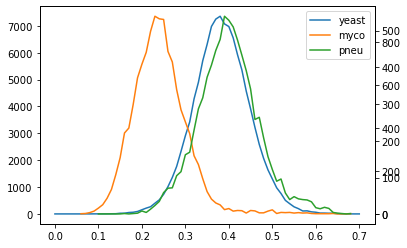

In [260]:
gcs, counts = np.unique(window_yeast.loc[noN_mask, 'gc'], return_counts=True)
fig, ax = plt.subplots(1, 1)
ax.plot(gcs, counts, label='yeast')
gcs, counts = np.unique(window_myco['gc'], return_counts=True)
ax1 = ax.twinx()
ax1.plot(gcs, counts, color=colors[1], label='myco')
gcs, counts = np.unique(window_pneu['gc'], return_counts=True)
ax2 = ax.twinx()
ax2.plot(gcs, counts, color=colors[2], label='pneu')
plt.legend(*plot_utils.add_legend([ax, ax1, ax2]))
# high_gcs = gcs[counts >= 1000]
# print(high_gcs)
# print(np.where(~np.isclose(np.diff(high_gcs), 0.01)))


In [228]:
# Random preds for original plot
preds_nuc_rand = np.load(Path(data_dir, species, 'results', 'models_etienne', 'random_seqs', 'preds_all_reps_myco_nucleosome_random_strictGCrange_indep_10000.npy'))
preds_coh_rand = np.load(Path(data_dir, species, 'results', 'models_etienne', 'random_seqs', 'preds_all_reps_myco_cohesine_random_strictGCrange_indep_32.npy'))
preds_pol_rand = np.load(Path(data_dir, species, 'results', 'models_etienne', 'random_seqs', 'preds_all_reps_myco_pol_random_strictGCrange_indep_32.npy'))
all_gcs = np.linspace(0, 1, 21)
preds_nuc_rand.shape, preds_coh_rand.shape, preds_pol_rand.shape

((21, 30000), (21, 24576), (21, 1536))

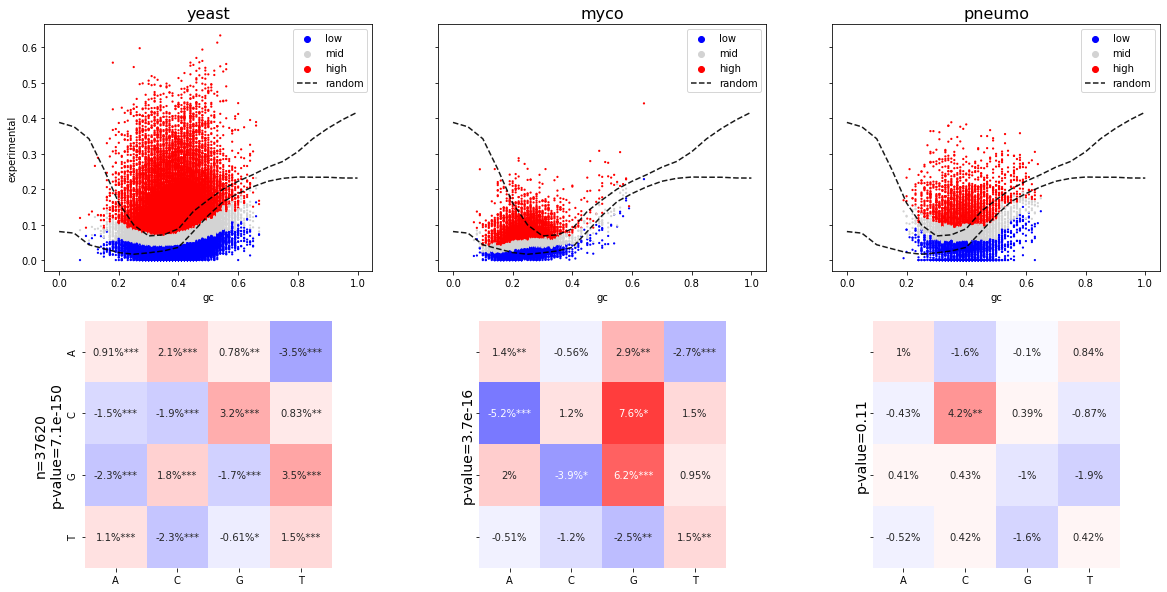

In [267]:
annot = 'lab_pol'
k = 2
stars_thres = np.array([0.05, 1e-2, 1e-3, -1]).reshape(1, 1, -1)
fig, axes = plt.subplots(2, 3, sharey='row', figsize=(20, 10), facecolor='w')
if annot == 'lab_nuc':
    rand_preds = (preds_nuc_rand / thres_pred_nm)
elif annot == 'lab_coh':
    rand_preds = (preds_coh_rand / thres_pred_cm)
else:
    rand_preds = (preds_pol_rand / thres_pred_pm)
titles = ['yeast', 'myco', 'pneumo']
for j, title in enumerate(titles):
    axes[0, j].set_title(title, fontsize=16)
for j, (window_df, window_one_hot) in enumerate([(window_yeast.loc[noN_mask, :], window_one_hot_yeast[noN_mask]),
                                                 (window_myco, window_one_hot_myco),
                                                 (window_pneu, window_one_hot_pneu)]):
    sns.scatterplot(ax=axes[0, j], data=window_df.loc[window_df[f'sep_{annot}'] != 'discarded'], x='gc', y=annot,
                    hue=f'sep_{annot}', hue_order=['low', 'mid', 'high'], palette=['b', 'lightgray', 'r'],
                    ec=None, s=5)
    axes[0, j].plot(all_gcs, rand_preds.mean(axis=1)-rand_preds.std(axis=1), color='k', linestyle='--', alpha=0.9, label='random')
    axes[0, j].plot(all_gcs, rand_preds.mean(axis=1)+rand_preds.std(axis=1), color='k', linestyle='--', alpha=0.9)
    axes[0, j].legend().set_title('')

    low_mask = window_df.loc[:, f'sep_{annot}'] == 'low'
    high_mask = window_df.loc[:, f'sep_{annot}'] == 'high'
    df_low = utils.kmer_counts_by_seq(window_one_hot[low_mask], k, includeN=False)
    df_high = utils.kmer_counts_by_seq(window_one_hot[high_mask], k, includeN=False)
    df_pvals = pd.Series(
        0.,
        index=df_low.index)
    for kmer in df_low.index:
        df_pvals.loc[kmer] = scipy.stats.chi2_contingency(
            [[df_high.loc[kmer, :].sum(), df_high.loc[df_high.index!=kmer, :].sum().sum()],
                [df_low.loc[kmer, :].sum(), df_low.loc[df_low.index!=kmer, :].sum().sum()]]
        )[1]
    global_pval = scipy.stats.chi2_contingency(pd.concat([df_high.sum(axis=1), df_low.sum(axis=1)], axis=1))[1]
    df_pvals2D = df_pvals.sort_index().unstack()
    
    df_ref = df_low.mean(axis=1)
    df_percdiff = (df_high.mean(axis=1)- df_ref) / df_ref * 100
    df_percdiff2D = df_percdiff.sort_index().unstack()

    stars = np.argmax(df_pvals2D.to_numpy().reshape(4, 4, 1) > stars_thres, axis=2)
    annotation = [[f"{format(v, '.2g')}%" + "*"*s for v, s in zip(*row)] for row in zip(df_percdiff2D.values, stars)]
    sns.heatmap(df_percdiff2D, cmap='seismic', annot=annotation, fmt='', ax=axes[1, j], center=0, vmax=20, cbar=False, square=True)
    lab = f'p-value={format(global_pval, ".2g")}'
    if j == 0:
        lab = f'n={low_mask.sum()}\n' + lab
    axes[1, j].set_ylabel(lab, fontsize=14)
if annot == 'lab_nuc':
    axes[0, 1].set_ylim(bottom=-0.01, top=0.4)
axes[0, 0].set_ylabel('experimental')
plt.savefig(Path(data_dir, species, 'results', 'models_etienne', 'kmers',
                 f'composite_scatter_heatmap_2merpercdiff&pvalue_label{annot[-3:]}_in{binsize}bpall.png'),
            bbox_inches='tight')

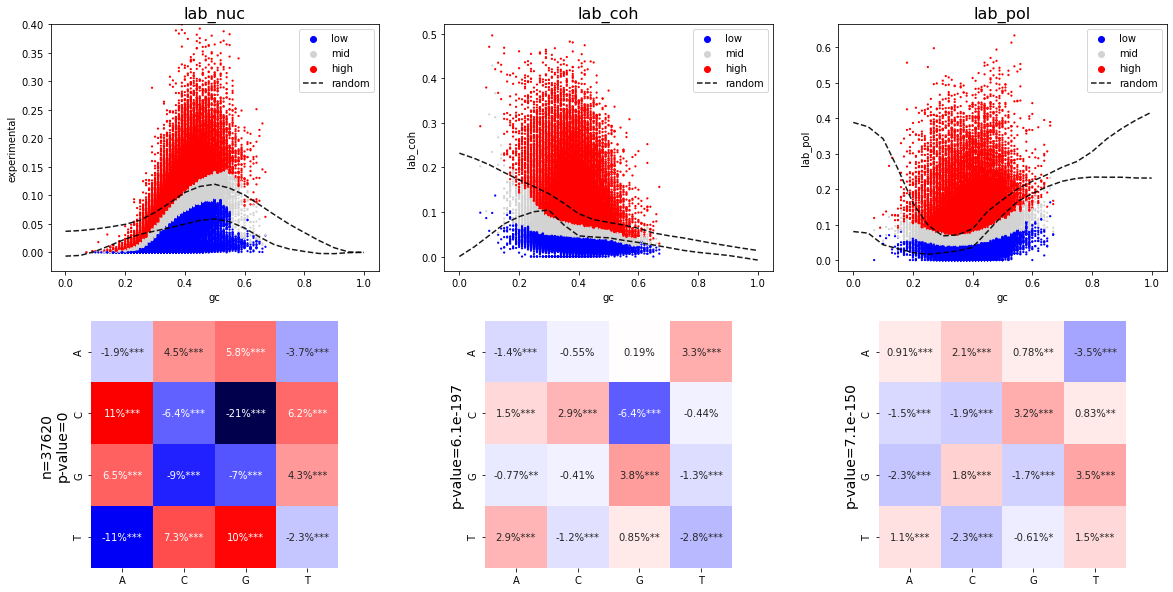

In [235]:
k = 2
stars_thres = np.array([0.05, 1e-2, 1e-3, -1]).reshape(1, 1, -1)
# count_thres = 1000
# gcs, counts = np.unique(window_yeast.loc[noN_mask, 'gc'], return_counts=True)
# high_gcs = gcs[counts >= count_thres]
fig, axes = plt.subplots(2, 3, figsize=(20, 10), facecolor='w')
titles = ['lab_nuc', 'lab_coh', 'lab_pol']
for j, title in enumerate(titles):
    axes[0, j].set_title(title, fontsize=16)
for j, annot in enumerate(titles):
    sns.scatterplot(ax=axes[0, j], data=window_yeast.loc[window_yeast[f'sep_{annot}'] != 'discarded'], x='gc', y=annot,
                    hue=f'sep_{annot}', hue_order=['low', 'mid', 'high'], palette=['b', 'lightgray', 'r'],
                    ec=None, s=5)
    if j == 0:
        rand_preds = (preds_nuc_rand / thres_pred_nm).mean(axis=1)
        rand_preds_std = (preds_nuc_rand / thres_pred_nm).std(axis=1)
    elif j == 1:
        rand_preds = (preds_coh_rand / thres_pred_cm).mean(axis=1)
        rand_preds_std = (preds_coh_rand / thres_pred_cm).std(axis=1)
    else:
        rand_preds = (preds_pol_rand / thres_pred_pm).mean(axis=1)
        rand_preds_std = (preds_pol_rand / thres_pred_pm).std(axis=1)
    axes[0, j].plot(all_gcs, rand_preds-rand_preds_std, color='k', linestyle='--', alpha=0.9, label='random')
    axes[0, j].plot(all_gcs, rand_preds+rand_preds_std, color='k', linestyle='--', alpha=0.9)
    # axes[0, j].axvline(x=high_gcs[0], color='gray', linestyle='--', alpha=0.9)
    # axes[0, j].axvline(x=high_gcs[-1], color='gray', linestyle='--', alpha=0.9)
    axes[0, j].legend().set_title('')

    gc_mask = noN_mask# & (window_yeast['gc'] >= high_gcs[0]) & (window_yeast['gc'] <= high_gcs[-1] + 0.005)
    low_mask = window_yeast.loc[gc_mask, f'sep_{annot}'] == 'low'
    high_mask = window_yeast.loc[gc_mask, f'sep_{annot}'] == 'high'
    df_low = utils.kmer_counts_by_seq(window_one_hot_yeast[gc_mask][low_mask], k, includeN=False)
    df_high = utils.kmer_counts_by_seq(window_one_hot_yeast[gc_mask][high_mask], k, includeN=False)
    df_pvals = pd.Series(
        0.,
        index=df_low.index)
    for kmer in df_low.index:
        df_pvals.loc[kmer] = scipy.stats.chi2_contingency(
            [[df_high.loc[kmer, :].sum(), df_high.loc[df_high.index!=kmer, :].sum().sum()],
                [df_low.loc[kmer, :].sum(), df_low.loc[df_low.index!=kmer, :].sum().sum()]]
        )[1]
    global_pval = scipy.stats.chi2_contingency(pd.concat([df_high.sum(axis=1), df_low.sum(axis=1)], axis=1))[1]
    df_pvals2D = df_pvals.sort_index().unstack()
    
    df_ref = df_low.mean(axis=1)
    df_percdiff = (df_high.mean(axis=1)- df_ref) / df_ref * 100
    df_percdiff2D = df_percdiff.sort_index().unstack()

    stars = np.argmax(df_pvals2D.to_numpy().reshape(4, 4, 1) > stars_thres, axis=2)
    annotation = [[f"{format(v, '.2g')}%" + "*"*s for v, s in zip(*row)] for row in zip(df_percdiff2D.values, stars)]
    sns.heatmap(df_percdiff2D, cmap='seismic', annot=annotation, fmt='', ax=axes[1, j], center=0, vmax=20, cbar=False, square=True)
    lab = f'p-value={format(global_pval, ".2g")}'
    if j == 0:
        lab = f'n={low_mask.sum()}\n' + lab
        # lab = f'gc in [{high_gcs[0]}, {high_gcs[-1]}], n={low_mask.sum()}\n' + lab
    axes[1, j].set_ylabel(lab, fontsize=14)
axes[0, 0].set_ylim(bottom=axes[0, 1].get_ylim()[0], top=0.4)
axes[0, 0].set_ylabel('experimental')
plt.savefig(Path(data_dir, species, 'results', 'models_etienne', 'kmers',
                 f'composite_scatter_heatmap_2merpercdiff&pvalue_labelall_in{binsize}bpyeast.png'),#_gc{high_gcs[0]}-{high_gcs[-1]}
            bbox_inches='tight')

0.36
0.37
0.38
0.39
0.4


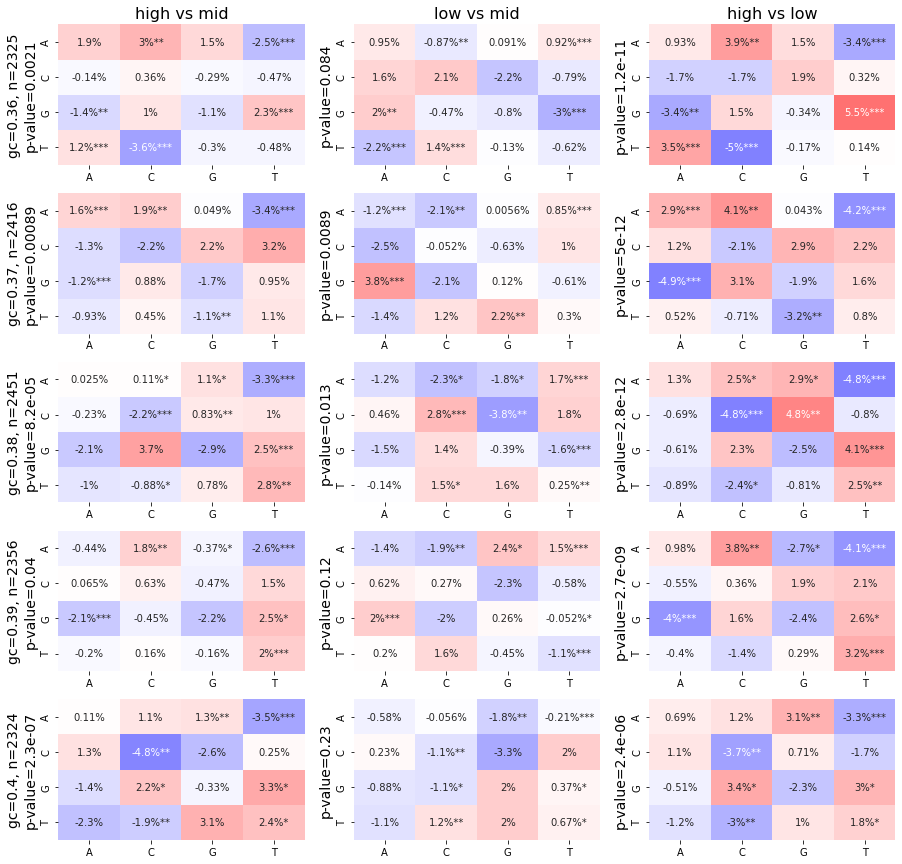

In [162]:
k = 2
annot = 'lab_pol'
gcs = np.arange(0.36, 0.405, 0.01).round(2) # np.arange(0.26, 0.505, 0.04).round(2) #
stars_thres = np.array([0.05, 1e-2, 1e-3, -1]).reshape(1, 1, -1)
fig, axes = plt.subplots(len(gcs), 3, figsize=(15, 3*len(gcs)), facecolor='w')
titles = ['high vs mid', 'low vs mid', 'high vs low']
for j, title in enumerate(titles):
    axes[0, j].set_title(title, fontsize=16)
for i, gc in enumerate(gcs):
    print(gc)
    gc_mask = noN_mask & (window_yeast['gc'] == gc)
    low_mask = window_yeast.loc[gc_mask, f'sep_{annot}'] == 'low'
    mid_mask = window_yeast.loc[gc_mask, f'sep_{annot}'] == 'mid'
    high_mask = window_yeast.loc[gc_mask, f'sep_{annot}'] == 'high'
    df_low = utils.kmer_counts_by_seq(window_one_hot_yeast[gc_mask][low_mask], k, includeN=False)
    df_mid = utils.kmer_counts_by_seq(window_one_hot_yeast[gc_mask][mid_mask], k, includeN=False)
    df_high = utils.kmer_counts_by_seq(window_one_hot_yeast[gc_mask][high_mask], k, includeN=False)
    df_pvals = pd.DataFrame(
        0.,
        index=df_low.index,
        columns=titles)
    for kmer in df_low.index:
        df_pvals.loc[kmer, :] = [
            scipy.stats.chi2_contingency(
                [[df_high.loc[kmer, :].sum(), df_high.loc[df_high.index!=kmer, :].sum().sum()],
                 [df_mid.loc[kmer, :].sum(), df_mid.loc[df_mid.index!=kmer, :].sum().sum()]]
            )[1],
            scipy.stats.chi2_contingency(
                [[df_low.loc[kmer, :].sum(), df_low.loc[df_low.index!=kmer, :].sum().sum()],
                 [df_mid.loc[kmer, :].sum(), df_mid.loc[df_mid.index!=kmer, :].sum().sum()]]
            )[1],
            scipy.stats.chi2_contingency(
                [[df_high.loc[kmer, :].sum(), df_high.loc[df_high.index!=kmer, :].sum().sum()],
                 [df_low.loc[kmer, :].sum(), df_low.loc[df_low.index!=kmer, :].sum().sum()]]
            )[1]
        ]
        df_pvals.loc[kmer] = scipy.stats.chi2_contingency(
                [[df_high.loc[kmer, :].sum(), df_high.loc[df_high.index!=kmer, :].sum().sum()],
                 [df_low.loc[kmer, :].sum(), df_low.loc[df_low.index!=kmer, :].sum().sum()]]
            )[1]
    global_pvals = [
        scipy.stats.chi2_contingency(pd.concat([df_high.sum(axis=1), df_mid.sum(axis=1)], axis=1))[1],
        scipy.stats.chi2_contingency(pd.concat([df_low.sum(axis=1), df_mid.sum(axis=1)], axis=1))[1],
        scipy.stats.chi2_contingency(pd.concat([df_high.sum(axis=1), df_low.sum(axis=1)], axis=1))[1]]
    df_pvals2D = df_pvals.sort_index().unstack()
    
    # mid_mean = df_mid.mean(axis=1).values.reshape(-1, 1)
    df_percdiff = pd.concat(
        {'high vs mid': df_high.mean(axis=1),
         'low vs mid': df_low.mean(axis=1),
         'high vs low': df_high.mean(axis=1)},
        axis=1)
    df_ref = pd.concat(
        {'high vs mid': df_mid.mean(axis=1),
         'low vs mid': df_mid.mean(axis=1),
         'high vs low': df_low.mean(axis=1)},
        axis=1)
    df_percdiff = (df_percdiff - df_ref) / df_ref * 100
    df_percdiff2D = df_percdiff.sort_index().unstack()

    for j, key in enumerate(titles):
        stars = np.argmax(df_pvals2D[key].to_numpy().reshape(4, 4, 1) > stars_thres, axis=2)
        annotation = [[f'{format(v, ".2g")}%' + "*"*s for v, s in zip(*row)] for row in zip(df_percdiff2D[key].values, stars)]
        sns.heatmap(df_percdiff2D[key], cmap='seismic', annot=annotation, fmt='', ax=axes[i, j], center=0, vmax=20, cbar=False)
        lab = f'p-value={format(global_pvals[j], ".2g")}'
        if j == 0:
            lab = f'gc={gc}, n={low_mask.sum()}\n' + lab
        axes[i, j].set_ylabel(lab, fontsize=14)
plt.savefig(Path(data_dir, species, 'results', 'models_etienne', 'kmers',
                 f'heatmap_2merpercdiff&pvalue_label{annot[-3:]}_in{binsize}bpyeast_highmidlow_vs_gc{gcs[0]}-{gcs[-1]}.png'),
            bbox_inches='tight')

0.36
0.37
0.38
0.39
0.4


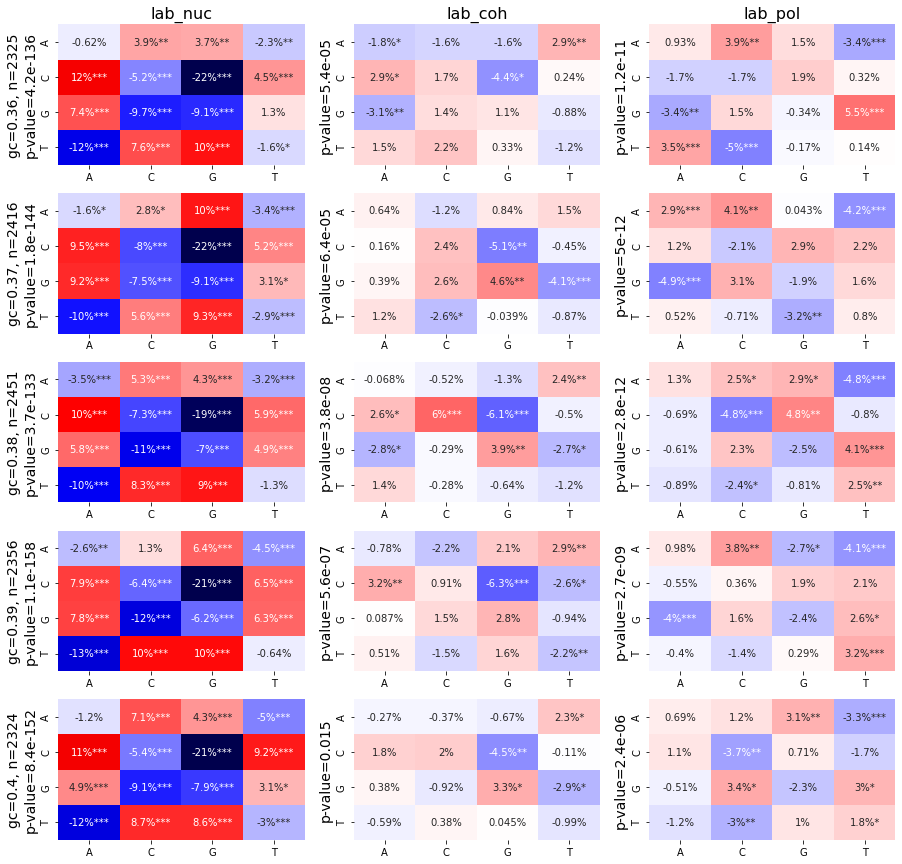

In [165]:
k = 2
gcs = np.arange(0.36, 0.405, 0.01).round(2) # np.arange(0.26, 0.505, 0.04).round(2) #
stars_thres = np.array([0.05, 1e-2, 1e-3, -1]).reshape(1, 1, -1)
fig, axes = plt.subplots(len(gcs), 3, figsize=(15, 3*len(gcs)), facecolor='w')
titles = ['lab_nuc', 'lab_coh', 'lab_pol']
for j, title in enumerate(titles):
    axes[0, j].set_title(title, fontsize=16)
for i, gc in enumerate(gcs):
    print(gc)
    for j, annot in enumerate(titles):
        gc_mask = noN_mask & (window_yeast['gc'] == gc)
        low_mask = window_yeast.loc[gc_mask, f'sep_{annot}'] == 'low'
        high_mask = window_yeast.loc[gc_mask, f'sep_{annot}'] == 'high'
        df_low = utils.kmer_counts_by_seq(window_one_hot_yeast[gc_mask][low_mask], k, includeN=False)
        df_high = utils.kmer_counts_by_seq(window_one_hot_yeast[gc_mask][high_mask], k, includeN=False)
        df_pvals = pd.Series(
            0.,
            index=df_low.index)
        for kmer in df_low.index:
            df_pvals.loc[kmer] = scipy.stats.chi2_contingency(
                [[df_high.loc[kmer, :].sum(), df_high.loc[df_high.index!=kmer, :].sum().sum()],
                 [df_low.loc[kmer, :].sum(), df_low.loc[df_low.index!=kmer, :].sum().sum()]]
            )[1]
        global_pval = scipy.stats.chi2_contingency(pd.concat([df_high.sum(axis=1), df_low.sum(axis=1)], axis=1))[1]
        df_pvals2D = df_pvals.sort_index().unstack()
        
        df_ref = df_low.mean(axis=1)
        df_percdiff = (df_high.mean(axis=1)- df_ref) / df_ref * 100
        df_percdiff2D = df_percdiff.sort_index().unstack()

        stars = np.argmax(df_pvals2D.to_numpy().reshape(4, 4, 1) > stars_thres, axis=2)
        annotation = [[f"{format(v, '.2g')}%" + "*"*s for v, s in zip(*row)] for row in zip(df_percdiff2D.values, stars)]
        sns.heatmap(df_percdiff2D, cmap='seismic', annot=annotation, fmt='', ax=axes[i, j], center=0, vmax=20, cbar=False)
        lab = f'p-value={format(global_pval, ".2g")}'
        if j == 0:
            lab = f'gc={gc}, n={low_mask.sum()}\n' + lab
        axes[i, j].set_ylabel(lab, fontsize=14)
plt.savefig(Path(data_dir, species, 'results', 'models_etienne', 'kmers',
                 f'heatmap_2merpercdiff&pvalue_labelall_in{binsize}bpyeast_high-low_vs_gc{gcs[0]}-{gcs[-1]}.png'),
            bbox_inches='tight')

In [ ]:
def kmer_summary_by_seq(one_hots, k, includeN=False):
    df = utils.kmer_counts_by_seq(one_hots, k, includeN=includeN)
    return pd.concat({'mean': df.mean(axis=1), 'std': df.std(axis=1)}, axis=1)

In [155]:
annot = 'lab_nuc'
gc = 0.38
gc_mask = noN_mask & (window_yeast['gc'] == gc)
# gc_mask = noN_mask & (window_yeast['gc'] >= 0.31) & (window_yeast['gc'] <= 0.46)
low_mask = window_yeast.loc[gc_mask, f'sep_{annot}'] == 'low'
mid_mask = window_yeast.loc[gc_mask, f'sep_{annot}'] == 'mid'
high_mask = window_yeast.loc[gc_mask, f'sep_{annot}'] == 'high'
print(np.sum(low_mask), np.sum(mid_mask), np.sum(high_mask))
df = pd.concat(
    [kmer_summary_by_seq(window_one_hot_yeast[gc_mask][low_mask], k=1),
     kmer_summary_by_seq(window_one_hot_yeast[gc_mask][mid_mask], k=1),
     kmer_summary_by_seq(window_one_hot_yeast[gc_mask][high_mask], k=1)],
    axis=1
)
df.columns = [f'{pre}_{annot}_{suf}' for suf in ['low', 'mid', 'high'] for pre in ['mean', 'std']]
df2 = pd.concat(
    [kmer_summary_by_seq(window_one_hot_yeast[gc_mask][low_mask], k=2),
     kmer_summary_by_seq(window_one_hot_yeast[gc_mask][mid_mask], k=2),
     kmer_summary_by_seq(window_one_hot_yeast[gc_mask][high_mask], k=2)],
    axis=1
)
df2.columns = [f'{pre}_{annot}_{suf}' for suf in ['low', 'mid', 'high'] for pre in ['mean', 'std']]
df_reldiff = (df.loc[:, f'mean_{annot}_high'] - df.loc[:, f'mean_{annot}_low']) * 2 / df.sum(axis=1)
df_diff = (df.loc[:, f'mean_{annot}_high'] - df.loc[:, f'mean_{annot}_low']) / df.sum(axis=0).iloc[0]

df2_reldiff = (df2.loc[:, f'mean_{annot}_high'] - df2.loc[:, f'mean_{annot}_low']) * 2 / df2.sum(axis=1)
df2_diff = (df2.loc[:, f'mean_{annot}_high'] - df2.loc[:, f'mean_{annot}_low']) / df2.sum(axis=0).iloc[0]
df

2451 2453 2451


,mean_lab_nuc_low,std_lab_nuc_low,mean_lab_nuc_mid,std_lab_nuc_mid,mean_lab_nuc_high,std_lab_nuc_high
A,31.071399,6.193628,30.927028,5.83025,30.922481,6.210040
C,19.054672,3.896763,18.980840,3.83670,19.126479,3.859935
G,18.945328,3.896763,19.019160,3.83670,18.873521,3.859935
T,30.928601,6.193628,31.072972,5.83025,31.077519,6.210040


(<Figure size 1440x360 with 1 Axes>, <AxesSubplot:>)

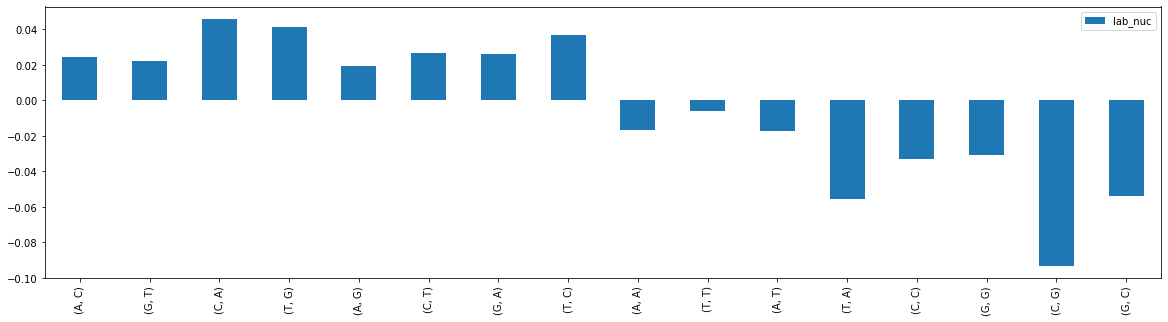

In [96]:
plot_utils.plot_2mer_df(pd.DataFrame(df2_reldiff, columns=[annot]))

<AxesSubplot:>

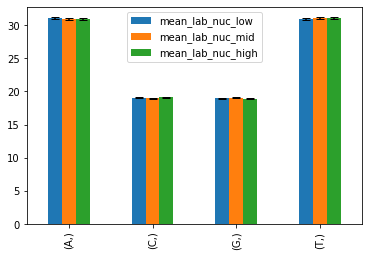

In [308]:
errors = df.loc[list('ACGT'), [f'std_{annot}_{suf}' for suf in ['low', 'mid', 'high']]] / np.array([np.sqrt(m.sum()) for m in [low_mask, mid_mask, high_mask]])
errors.columns = [f'mean_{annot}_{suf}' for suf in ['low', 'mid', 'high']]
df.loc[list('ACGT'), [f'mean_{annot}_{suf}' for suf in ['low', 'mid', 'high']]].plot(kind='bar', yerr=errors, capsize=4)

<AxesSubplot:>

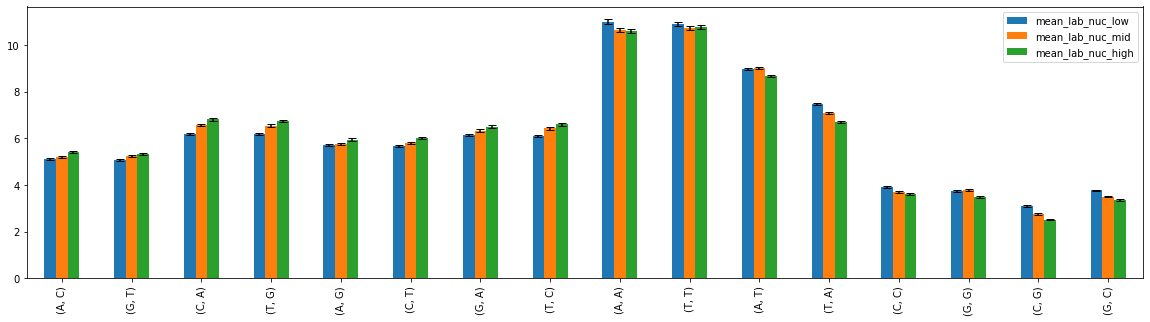

In [309]:
df2 = plot_utils.order_2mer_df(df2)
errors = df2[[f'std_{annot}_{suf}' for suf in ['low', 'mid', 'high']]] / np.array([np.sqrt(m.sum()) for m in [low_mask, mid_mask, high_mask]])
errors.columns = [f'mean_{annot}_{suf}' for suf in ['low', 'mid', 'high']]
fig, axes = plt.subplots(1, 1, figsize=(20, 5), facecolor='w')
df2.plot(kind='bar', y=[f'mean_{annot}_{suf}' for suf in ['low', 'mid', 'high']], yerr=errors, ax=axes, capsize=4)

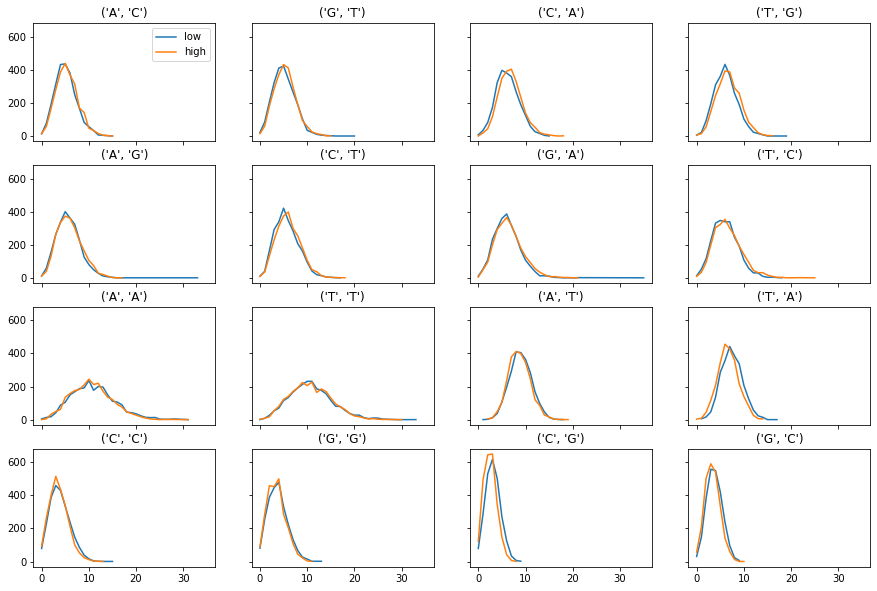

In [156]:
k = 2
df_low = utils.kmer_counts_by_seq(window_one_hot_yeast[gc_mask][low_mask], k, includeN=False)
df_mid = utils.kmer_counts_by_seq(window_one_hot_yeast[gc_mask][mid_mask], k, includeN=False)
df_high = utils.kmer_counts_by_seq(window_one_hot_yeast[gc_mask][high_mask], k, includeN=False)
if k == 2:
    df_low = plot_utils.order_2mer_df(df_low)
    df_mid = plot_utils.order_2mer_df(df_mid)
    df_high = plot_utils.order_2mer_df(df_high)
# fig, axes = plt.subplots(1, len(df_low.index), sharey=True, sharex=True, figsize=(30, 2), facecolor='w')
fig, axes = plt.subplots(4, 4, sharey=True, sharex=True, figsize=(15, 10), facecolor='w')
for kmer, ax in zip(df_low.index, axes.flatten()):
    ax.set_title(kmer)
    ax.plot(*np.unique(df_low.loc[kmer, :], return_counts=True), label='low')
    ax.plot(*np.unique(df_high.loc[kmer, :], return_counts=True), label='high')
axes.flatten()[0].legend()

In [37]:
scipy.__version__

'1.7.3'

In [149]:
from scipy.stats import distributions

def poisson_means_test(k1, n1, k2, n2, *, diff=0, alternative='two-sided'):
    r"""
    Performs the Poisson means test, AKA the "E-test".
    This is a test of the null hypothesis that the difference between means of
    two Poisson distributions is `diff`. The samples are provided as the
    number of events `k1` and `k2` observed within measurement intervals
    (e.g. of time, space, number of observations) of sizes `n1` and `n2`.
    Parameters
    ----------
    k1 : int
        Number of events observed from distribution 1.
    n1: float
        Size of sample from distribution 1.
    k2 : int
        Number of events observed from distribution 2.
    n2 : float
        Size of sample from distribution 2.
    diff : float, default=0
        The hypothesized difference in means between the distributions
        underlying the samples.
    alternative : {'two-sided', 'less', 'greater'}, optional
        Defines the alternative hypothesis.
        The following options are available (default is 'two-sided'):
          * 'two-sided': the difference between distribution means is not
            equal to `diff`
          * 'less': the difference between distribution means is less than
            `diff`
          * 'greater': the difference between distribution means is greater
            than `diff`
    Returns
    -------
    statistic : float
        The test statistic (see [1]_ equation 3.3).
    pvalue : float
        The probability of achieving such an extreme value of the test
        statistic under the null hypothesis.
    Notes
    -----
    Let:
    .. math:: X_1 \sim \mbox{Poisson}(\mathtt{n1}\lambda_1)
    be a random variable independent of
    .. math:: X_2  \sim \mbox{Poisson}(\mathtt{n2}\lambda_2)
    and let ``k1`` and ``k2`` be the observed values of :math:`X_1`
    and :math:`X_2`, respectively. Then `poisson_means_test` uses the number
    of observed events ``k1`` and ``k2`` from samples of size ``n1`` and
    ``n2``, respectively, to test the null hypothesis that
    .. math::
       H_0: \lambda_1 - \lambda_2 = \mathtt{diff}
    A benefit of the E-test is that it has good power for small sample sizes,
    which can reduce sampling costs [1]_. It has been evaluated and determined
    to be more powerful than the comparable C-test, sometimes referred to as
    the Poisson exact test.
    References
    ----------
    .. [1]  Krishnamoorthy, K., & Thomson, J. (2004). A more powerful test for
       comparing two Poisson means. Journal of Statistical Planning and
       Inference, 119(1), 23-35.
    .. [2]  Przyborowski, J., & Wilenski, H. (1940). Homogeneity of results in
       testing samples from Poisson series: With an application to testing
       clover seed for dodder. Biometrika, 31(3/4), 313-323.
    Examples
    --------
    Suppose that a gardener wishes to test the number of dodder (weed) seeds
    in a sack of clover seeds that they buy from a seed company. It has
    previously been established that the number of dodder seeds in clover
    follows the Poisson distribution.
    A 100 gram sample is drawn from the sack before being shipped to the
    gardener. The sample is analyzed, and it is found to contain no dodder
    seeds; that is, `k1` is 0. However, upon arrival, the gardener draws
    another 100 gram sample from the sack. This time, three dodder seeds are
    found in the sample; that is, `k2` is 3. The gardener would like to
    know if the difference is significant and not due to chance. The
    null hypothesis is that the difference between the two samples is merely
    due to chance, or that :math:`\lambda_1 - \lambda_2 = \mathtt{diff}`
    where :math:`\mathtt{diff} = 0`. The alternative hypothesis is that the
    difference is not due to chance, or :math:`\lambda_1 - \lambda_2 \ne 0`.
    The gardener selects a significance level of 5% to reject the null
    hypothesis in favor of the alternative [2]_.
    >>> import scipy.stats as stats
    >>> res = stats.poisson_means_test(0, 100, 3, 100)
    >>> res.statistic, res.pvalue
    (-1.7320508075688772, 0.08837900929018157)
    The p-value is .088, indicating a near 9% chance of observing a value of
    the test statistic under the null hypothesis. This exceeds 5%, so the
    gardener does not reject the null hypothesis as the difference cannot be
    regarded as significant at this level.
    """

    _poisson_means_test_iv(k1, n1, k2, n2, diff, alternative)

    # "for a given k_1 and k_2, an estimate of \lambda_2 is given by" [1] (3.4)
    lmbd_hat2 = ((k1 + k2) / (n1 + n2) - diff * n1 / (n1 + n2))

    # "\hat{\lambda_{2k}} may be less than or equal to zero ... and in this
    # case the null hypothesis cannot be rejected ... [and] it is not necessary
    # to compute the p-value". [1] page 26 below eq. (3.6).
    if lmbd_hat2 <= 0:
        return (0, 1)

    # The unbiased variance estimate [1] (3.2)
    var = k1 / (n1 ** 2) + k2 / (n2 ** 2)

    # The _observed_ pivot statistic from the input. It follows the
    # unnumbered equation following equation (3.3) This is used later in
    # comparison with the computed pivot statistics in an indicator function.
    t_k1k2 = (k1 / n1 - k2 / n2 - diff) / np.sqrt(var)

    # Equation (3.5) of [1] is lengthy, so it is broken into several parts,
    # beginning here. Note that the probability mass function of poisson is
    # exp^(-\mu)*\mu^k/k!, so and this is called with shape \mu, here noted
    # here as nlmbd_hat*. The strategy for evaluating the double summation in
    # (3.5) is to create two arrays of the values of the two products inside
    # the summation and then broadcast them together into a matrix, and then
    # sum across the entire matrix.

    # Compute constants (as seen in the first and second separated products in
    # (3.5).). (This is the shape (\mu) parameter of the poisson distribution.)
    nlmbd_hat1 = n1 * (lmbd_hat2 + diff)
    nlmbd_hat2 = n2 * lmbd_hat2

    # Determine summation bounds for tail ends of distribution rather than
    # summing to infinity. `x1*` is for the outer sum and `x2*` is the inner
    # sum.
    x1_lb, x1_ub = distributions.poisson.ppf([1e-10, 1 - 1e-16], nlmbd_hat1)
    x2_lb, x2_ub = distributions.poisson.ppf([1e-10, 1 - 1e-16], nlmbd_hat2)

    # Construct arrays to function as the x_1 and x_2 counters on the summation
    # in (3.5). `x1` is in columns and `x2` is in rows to allow for
    # broadcasting.
    x1 = np.arange(x1_lb, x1_ub + 1)
    x2 = np.arange(x2_lb, x2_ub + 1)[:, None]

    # These are the two products in equation (3.5) with `prob_x1` being the
    # first (left side) and `prob_x2` being the second (right side). (To
    # make as clear as possible: the 1st contains a "+ d" term, the 2nd does
    # not.)
    prob_x1 = distributions.poisson.pmf(x1, nlmbd_hat1)
    prob_x2 = distributions.poisson.pmf(x2, nlmbd_hat2)

    # compute constants for use in the "pivot statistic" per the
    # unnumbered equation following (3.3).
    lmbd_x1 = x1 / n1
    lmbd_x2 = x2 / n2
    lmbds_diff = lmbd_x1 - lmbd_x2 - diff
    var_x1x2 = lmbd_x1 / n1 + lmbd_x2 / n2

    # This is the 'pivot statistic' for use in the indicator of the summation
    # (left side of "I[.]").
    with np.errstate(invalid='ignore', divide='ignore'):
        t_x1x2 = lmbds_diff / np.sqrt(var_x1x2)

    # `[indicator]` implements the "I[.] ... the indicator function" per
    # the paragraph following equation (3.5).
    if alternative == 'two-sided':
        indicator = np.abs(t_x1x2) >= np.abs(t_k1k2)
    elif alternative == 'less':
        indicator = t_x1x2 <= t_k1k2
    else:
        indicator = t_x1x2 >= t_k1k2

    # Multiply all combinations of the products together, exclude terms
    # based on the `indicator` and then sum. (3.5)
    pvalue = np.sum((prob_x1 * prob_x2)[indicator])
    return (t_k1k2, pvalue)

def _poisson_means_test_iv(k1, n1, k2, n2, diff, alternative):
    # """check for valid types and values of input to `poisson_mean_test`."""
    if k1 != int(k1) or k2 != int(k2):
        raise TypeError('`k1` and `k2` must be integers.')

    count_err = '`k1` and `k2` must be greater than or equal to 0.'
    if k1 < 0 or k2 < 0:
        raise ValueError(count_err)

    if n1 <= 0 or n2 <= 0:
        raise ValueError('`n1` and `n2` must be greater than 0.')

    if diff < 0:
        raise ValueError('diff must be greater than or equal to 0.')

    alternatives = {'two-sided', 'less', 'greater'}
    if alternative.lower() not in alternatives:
        raise ValueError(f"Alternative must be one of '{alternatives}'.")

In [150]:
pd.concat([df_low.sum(axis=1), df_high.sum(axis=1)], axis=1)

,,0,1
A,C,12551,13220
G,T,12456,13072
C,A,15171,16685
T,G,15142,16509
A,G,13977,14573
C,T,13912,14732
G,A,15049,15928
T,C,14923,16162
A,A,26948,26003
T,T,26701,26356


In [131]:
scipy.stats.chi2_contingency(
    pd.concat([df_low.sum(axis=1), df_mid.sum(axis=1)], axis=1)
)[1]

1.2819366811775319e-39

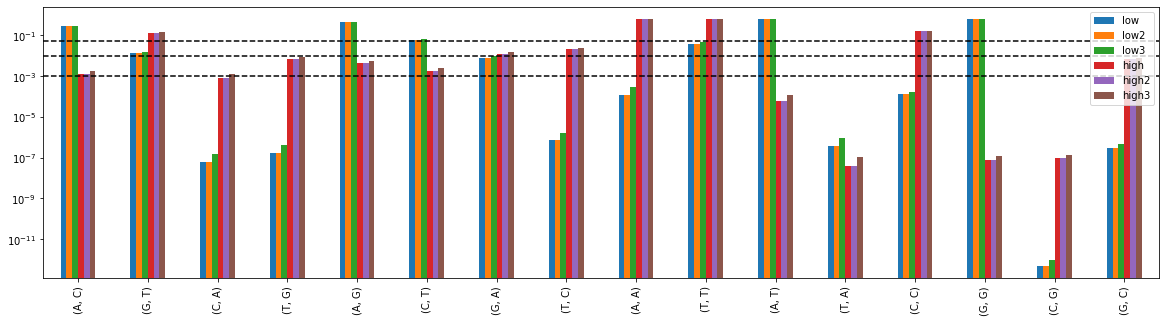

In [157]:
df_pvals = pd.DataFrame(
    0.,
    index=df_low.index,
    columns=[
        'low',
        'low2',
        'low3',
        'high',
        'high2',
        'high3',
    ])
for kmer in df_low.index:
    df_pvals.loc[kmer, :] = [
        scipy.stats.chi2_contingency(
            [[df_low.loc[kmer, :].sum(), df_low.loc[df_low.index!=kmer, :].sum().sum()],
             [df_mid.loc[kmer, :].sum(), df_mid.loc[df_mid.index!=kmer, :].sum().sum()]],
            correction=True
        )[1],
        # scipy.stats.ttest_ind(df_low.loc[kmer, :], df_mid.loc[kmer, :]).pvalue,
        scipy.stats.chi2_contingency(
            [[df_low.loc[kmer, :].sum(), df_low.loc[df_low.index!=kmer, :].sum().sum()],
             [df_mid.loc[kmer, :].sum(), df_mid.loc[df_mid.index!=kmer, :].sum().sum()]]
        )[1],
        poisson_means_test(df_low.loc[kmer, :].sum(), (binsize-1)*low_mask.sum(), df_mid.loc[kmer, :].sum(), (binsize-1)*mid_mask.sum())[1],
        scipy.stats.chi2_contingency(
            [[df_high.loc[kmer, :].sum(), df_high.loc[df_high.index!=kmer, :].sum().sum()],
             [df_mid.loc[kmer, :].sum(), df_mid.loc[df_mid.index!=kmer, :].sum().sum()]],
            correction=True
        )[1],
        scipy.stats.chi2_contingency(
            [[df_high.loc[kmer, :].sum(), df_high.loc[df_high.index!=kmer, :].sum().sum()],
             [df_mid.loc[kmer, :].sum(), df_mid.loc[df_mid.index!=kmer, :].sum().sum()]]
        )[1],
        # scipy.stats.ttest_ind(df_high.loc[kmer, :], df_mid.loc[kmer, :]).pvalue,
        poisson_means_test(df_high.loc[kmer, :].sum(), (binsize-1)*high_mask.sum(), df_mid.loc[kmer, :].sum(), (binsize-1)*mid_mask.sum())[1],
    ]
if k == 2:
    df_pvals = plot_utils.order_2mer_df(df_pvals)
ax = df_pvals.plot(kind='bar', figsize=(20, 5))
ax.set_yscale('log')
ax.axhline(y=0.05, color='k', linestyle='--')
ax.axhline(y=0.01, color='k', linestyle='--')
ax.axhline(y=0.001, color='k', linestyle='--')

In [320]:
df_pvals2D = df_pvals.sort_index().unstack()
df_pvals2D['high']

,A,C,G,T
A,0.652841,0.966121,0.590189,0.000008
C,0.921278,0.308307,0.772115,0.282129
G,0.197911,0.011413,0.096619,0.044428
T,0.075965,0.697375,0.261029,0.042636


<AxesSubplot:>

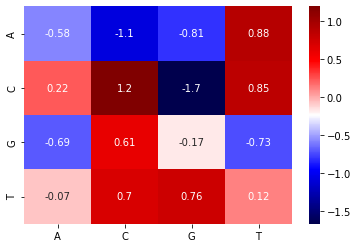

In [321]:
df2_reldiff = (df2.loc[:, f'mean_{annot}_low'] - df2.loc[:, f'mean_{annot}_mid']) * 2 / df2.sum(axis=1) * 100
df2_reldiff2D = df2_reldiff.sort_index().unstack()
sns.heatmap(df2_reldiff2D, cmap='seismic', annot=True)

<AxesSubplot:>

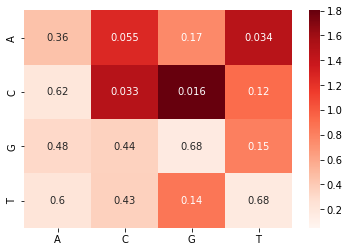

In [322]:
sns.heatmap(-np.log10(df_pvals2D['low']), cmap='Reds', annot=df_pvals2D['low'], vmin=0.05)

<AxesSubplot:>

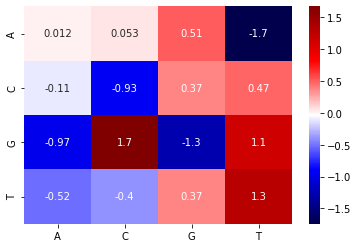

In [323]:
df2_reldiff = (df2.loc[:, f'mean_{annot}_high'] - df2.loc[:, f'mean_{annot}_mid']) * 2 / df2.sum(axis=1) * 100
df2_reldiff2D = df2_reldiff.sort_index().unstack()
sns.heatmap(df2_reldiff2D, cmap='seismic', annot=True)

<AxesSubplot:>

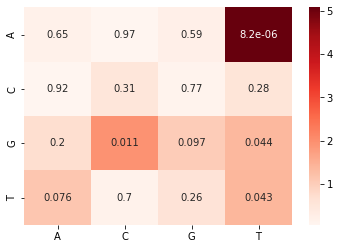

In [324]:
sns.heatmap(-np.log10(df_pvals2D['high']), cmap='Reds', annot=df_pvals2D['high'], vmin=0.05)

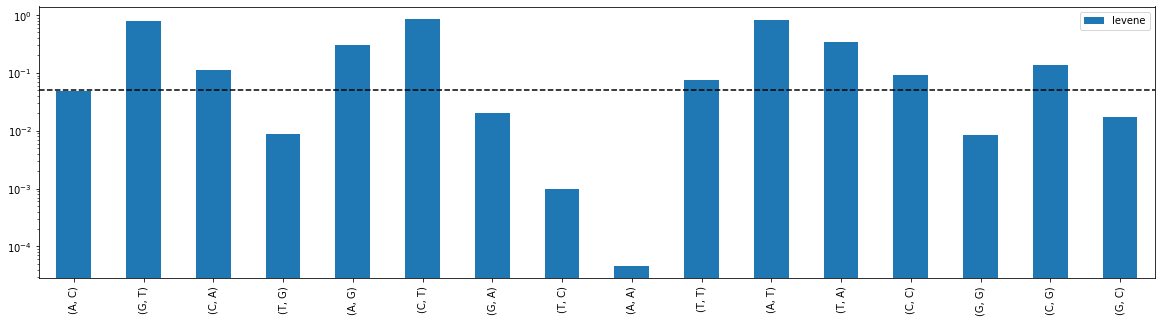

In [182]:
df_test = pd.DataFrame(
    index=df_low.index,
    columns=[
        'levene',
    ])
for kmer in df_low.index:
    df_test.loc[kmer, :] = [
        scipy.stats.levene(df_low.loc[kmer, :], df_high.loc[kmer, :]).pvalue
    ]
if k == 2:
    df_test = plot_utils.order_2mer_df(df_test)
ax = df_test.plot(kind='bar', figsize=(20, 5))
ax.set_yscale('log')
ax.axhline(y=0.05, color='k', linestyle='--')

In [271]:
annot = 'lab_nuc'
gc = 0.38
high_mask = window_yeast.loc[noN_mask & (window_yeast['gc'] == gc), f'sep_{annot}'] == 'high'
low_mask = window_yeast.loc[noN_mask & (window_yeast['gc'] == gc), f'sep_{annot}'] == 'low'
df = pd.concat(
    [utils.kmer_counts(window_one_hot_yeast[noN_mask & (window_yeast['gc'] == gc)][low_mask], k=1, includeN=False),
     utils.kmer_counts(window_one_hot_yeast[noN_mask & (window_yeast['gc'] == gc)][high_mask], k=1, includeN=False)],
    axis=1).rename(columns={0: f'{annot}_low', 1: f'{annot}_high'})
df_reldiff = (df.loc[:, f'{annot}_high'] - df.loc[:, f'{annot}_low']) * 2 / df.sum(axis=1)
df_diff = (df.loc[:, f'{annot}_high'] - df.loc[:, f'{annot}_low']) / df.sum(axis=0).iloc[0]
df2 = pd.concat(
    [utils.kmer_counts(window_one_hot_yeast[noN_mask & (window_yeast['gc'] == gc)][low_mask], k=2, includeN=False),
     utils.kmer_counts(window_one_hot_yeast[noN_mask & (window_yeast['gc'] == gc)][high_mask], k=2, includeN=False)],
    axis=1).rename(columns={0: f'{annot}_low', 1: f'{annot}_high'})
df2_reldiff = (df2.loc[:, f'{annot}_high'] - df2.loc[:, f'{annot}_low']) * 2 / df2.sum(axis=1)
df2_diff = (df2.loc[:, f'{annot}_high'] - df2.loc[:, f'{annot}_low']) / df2.sum(axis=0).iloc[0]
df

,lab_nuc_low,lab_nuc_high
A,113972,113812
C,69912,70211
G,69814,69515
T,114002,114162


In [297]:
df['ref'] = utils.kmer_counts(window_one_hot_yeast[noN_mask & (window_yeast['gc'] == gc)], k=1, includeN=False)
df

,lab_nuc_low,lab_nuc_high,ref
A,113972,113812,227811
C,69912,70211,140142
G,69814,69515,139348
T,114002,114162,228199


In [298]:
df2['ref'] = utils.kmer_counts(window_one_hot_yeast[noN_mask & (window_yeast['gc'] == gc)], k=2, includeN=False)
df2

lab_nuc_low  lab_nuc_high    ref
A A        40023         39052  79083
  C        18812         19679  38496
  G        20991         21669  42667
  T        32996         32278  65281
C A        23154         24808  47969
  C        14046         13358  27407
  G        11060          9464  20528
  T        20973         21895  42873
G A        22727         23755  46488
  C        13557         12470  26030
  G        13933         13125  27062
  T        18905         19466  38377
T A        26974         25017  51997
  C        22821         24031  46860
  G        23104         24593  47701
  T        39947         39363  79326

In [299]:
freq_nuc = df / df.sum(axis=0)
freq_nuc

,lab_nuc_low,lab_nuc_high,ref
A,0.309959,0.309524,0.309736
C,0.190133,0.190946,0.190540
G,0.189867,0.189054,0.189460
T,0.310041,0.310476,0.310264


In [300]:
freq_dinuc = df2 / df2.sum(axis=0)
freq_dinuc

lab_nuc_low  lab_nuc_high       ref
A A     0.109946      0.107279  0.108609
  C     0.051678      0.054060  0.052869
  G     0.057664      0.059526  0.058597
  T     0.090643      0.088670  0.089654
C A     0.063606      0.068150  0.065878
  C     0.038585      0.036695  0.037639
  G     0.030383      0.025998  0.028192
  T     0.057614      0.060147  0.058880
G A     0.062433      0.065257  0.063844
  C     0.037242      0.034256  0.035748
  G     0.038275      0.036055  0.037166
  T     0.051934      0.053475  0.052705
T A     0.074100      0.068724  0.071410
  C     0.062691      0.066015  0.064355
  G     0.063469      0.067559  0.065510
  T     0.109738      0.108133  0.108943

In [272]:
df2_reldiff

A  A   -0.024559
   C    0.045049
   G    0.031786
   T   -0.022000
C  A    0.068971
   C   -0.050212
   G   -0.155525
   T    0.043016
G  A    0.044232
   C   -0.083529
   G   -0.059724
   T    0.029241
T  A   -0.075282
   C    0.051652
   G    0.062436
   T   -0.014727
dtype: float64

In [283]:
from scipy.stats import chisquare
pval_nuc = chisquare(df.loc[:, f'{annot}_high'], df.loc[:, f'{annot}_low']).pvalue
pval_dinuc = chisquare(df2.loc[:, f'{annot}_high'], df2.loc[:, f'{annot}_low']).pvalue
print('nuc pvalue:', pval_nuc)
print('dinuc pvalue:', pval_dinuc)

nuc pvalue: 0.39031672328754863
dinuc pvalue: 2.3453937020653208e-210


<AxesSubplot:>

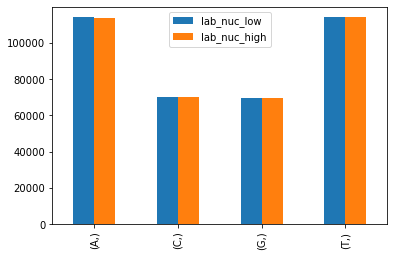

In [278]:
df.loc[list('ACGT')].plot(kind='bar')

(<Figure size 1440x360 with 1 Axes>, <AxesSubplot:>)

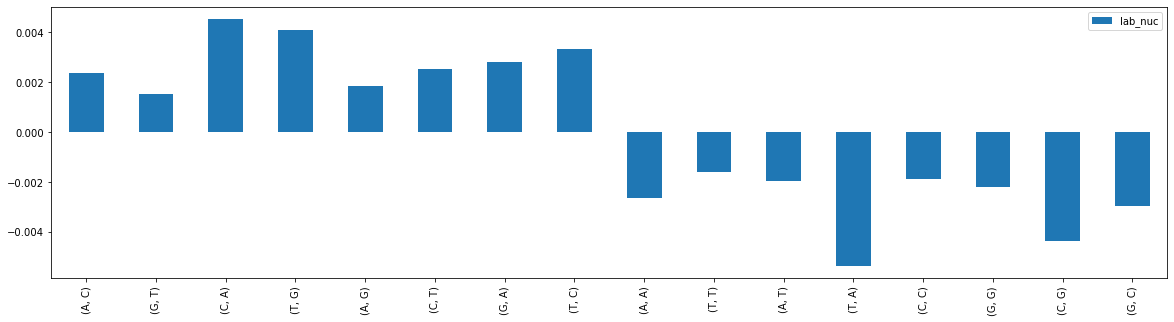

In [286]:
plot_utils.plot_2mer_df(pd.DataFrame(df2_diff, columns=[annot]))

In [22]:
nucs = []
nuc_reldiff = {}
nuc_diff = {}
kmers = []
kmer_reldiff = {}
kmer_diff = {}
for part1 in ['lab', 'pred']:
    for part2 in ['nuc', 'coh', 'pol']:
        annot = f'{part1}_{part2}'
        high_mask = window_yeast.loc[noN_mask, f'sep_{annot}'] == 'high'
        low_mask = window_yeast.loc[noN_mask, f'sep_{annot}'] == 'low'
        df = pd.concat(
            [utils.kmer_counts(window_one_hot_yeast[noN_mask][low_mask], k=2, includeN=False),
             utils.kmer_counts(window_one_hot_yeast[noN_mask][high_mask], k=2, includeN=False)],
            axis=1).rename(columns={0: f'{annot}_low', 1: f'{annot}_high'})
        kmers.append(df)
        kmer_reldiff[annot] = (df.loc[:, f'{annot}_high'] - df.loc[:, f'{annot}_low']) * 2 / df.sum(axis=1)
        kmer_diff[annot] = (df.loc[:, f'{annot}_high'] - df.loc[:, f'{annot}_low']) / df.sum(axis=0).iloc[0]
        df1 = pd.concat(
            [utils.kmer_counts(window_one_hot_yeast[noN_mask][low_mask], k=1, includeN=False),
             utils.kmer_counts(window_one_hot_yeast[noN_mask][high_mask], k=1, includeN=False)],
            axis=1).rename(columns={0: f'{annot}_low', 1: f'{annot}_high'})
        nucs.append(df1)
        nuc_reldiff[annot] = (df1.loc[:, f'{annot}_high'] - df1.loc[:, f'{annot}_low']) * 2 / df1.sum(axis=1)
        nuc_diff[annot] = (df1.loc[:, f'{annot}_high'] - df1.loc[:, f'{annot}_low']) / df1.sum(axis=0).iloc[0]

# for part1 in ['pred']:
#     for part2 in ['nuc', 'coh', 'pol']:
#         annot = f'{part1}_{part2}_rand'
#         high_mask = window_rand.loc[noN_mask_r, f'sep_{annot}'] == 'high'
#         low_mask = window_rand.loc[noN_mask_r, f'sep_{annot}'] == 'low'
#         df = pd.concat(
#             [utils.kmer_counts(window_one_hot_rand[noN_mask_r][low_mask], k=2, includeN=False),
#              utils.kmer_counts(window_one_hot_rand[noN_mask_r][high_mask], k=2, includeN=False)],
#             axis=1).rename(columns={0: f'{annot}_low', 1: f'{annot}_high'})
#         kmers.append(df)
#         kmer_reldiff[annot] = (df.loc[:, f'{annot}_high'] - df.loc[:, f'{annot}_low']) * 2 / df.sum(axis=1)
#         kmer_diff[annot] = (df.loc[:, f'{annot}_high'] - df.loc[:, f'{annot}_low']) / df.sum(axis=0).iloc[0]

kmers = pd.concat(kmers, axis=1)
kmer_reldiff = pd.DataFrame(kmer_reldiff)
kmer_diff = pd.DataFrame(kmer_diff)

nucs = pd.concat(nucs, axis=1)
nuc_reldiff = pd.DataFrame(nuc_reldiff)
nuc_diff = pd.DataFrame(nuc_diff)

kmers

lab_nuc_low  lab_nuc_high  lab_coh_low  lab_coh_high  lab_pol_low  \
A A       606932        599343       606511        599668       601109   
  C       290774        301307       296554        295515       293888   
  G       321124        333180       326980        327302       326217   
  T       505828        491983       493131        504680       505516   
C A       349972        377254       361606        365591       366310   
  C       222804        212928       215581        220155       219837   
  G       178669        150685       168679        160691       162576   
  T       317737        331981       325234        324496       323988   
G A       341808        357281       351081        347984       352314   
  C       216746        202261       209508        209481       208123   
  G       224056        211520       214711        220883       218898   
  T       291032        299399       296730        293725       290987   
T A       426597        391283       404235        413673       407040   
  C       338383        356699       349149        345961       350788   
  G       349843        374805       361555        363078       362717   
  T       605354        595750       606414        594776       597351   

     lab_pol_high  pred_nuc_low  pred_nuc_high  pred_coh_low  pred_coh_high  \
A A        605093        604337         601915        609239         596935   
  C        298186        288066         304021        297116         294968   
  G        328077        313624         340697        329096         325210   
  T        492326        512468         485328        494459         503364   
C A        360887        346894         380313        361326         365898   
  C        215887        226833         208883        214581         221147   
  G        166793        183982         145377        167575         161771   
  T        325759        313577         336143        323734         325993   
G A        346781        337513         361594        354862         344236   
  C        210871        217965         201030        209107         209872   
  G        216683        228076         207520        217111         218484   
  T        299439        287699         302734        294811         295626   
T A        410882        430466         387426        404548         413346   
  C        344335        338139         356937        346219         348887   
  G        361909        345777         378857        361996         362644   
  T        603751        612243         588884        601879         599278   

     pred_pol_low  pred_pol_high  
A A        598939         607225  
  C        293351         298686  
  G        328020         326292  
  T        510056         487779  
C A        369188         357991  
  C        219527         216189  
  G        160825         168535  
  T        322977         326767  
G A        354934         344157  
  C        206980         212023  
  G        218841         216757  
  T        289660         300786  
T A        407247         410678  
  C        352757         342355  
  G        362766         361878  
  T        591591         609561

In [18]:
nucs

,lab_nuc_low,lab_nuc_high,lab_coh_low,lab_coh_high,lab_pol_low,lab_pol_high,pred_nuc_low,pred_nuc_high,pred_coh_low,pred_coh_high,pred_pol_low,pred_pol_high
A,1742176,1743117,1740688,1744476,1744185,1741049,1735931,1749346,1747482,1737727,1747842,1737331
C,1079889,1083543,1081662,1081774,1083411,1080033,1082184,1081219,1077822,1085604,1083291,1080108
G,1084659,1081005,1082886,1082774,1081137,1084515,1082364,1083329,1086726,1078944,1081257,1084440
T,1737376,1736435,1738864,1735076,1735367,1738503,1743621,1730206,1732070,1741825,1731710,1742221


In [17]:
nuc_diff

,lab_nuc,lab_coh,lab_pol,pred_nuc,pred_coh,pred_pol
A,0.000167,0.000671,-0.000556,0.002377,-0.001728,-0.001862
C,0.000647,0.000020,-0.000599,-0.000171,0.001379,-0.000564
G,-0.000647,-0.000020,0.000599,0.000171,-0.001379,0.000564
T,-0.000167,-0.000671,0.000556,-0.002377,0.001728,0.001862


In [19]:
nuc_reldiff

,lab_nuc,lab_coh,lab_pol,pred_nuc,pred_coh,pred_pol
A,0.000540,0.002174,-0.001800,0.007698,-0.005598,-0.006032
C,0.003378,0.000104,-0.003123,-0.000892,0.007194,-0.002943
G,-0.003374,-0.000103,0.003120,0.000891,-0.007187,0.002939
T,-0.000542,-0.002181,0.001805,-0.007723,0.005616,0.006051


<AxesSubplot:>

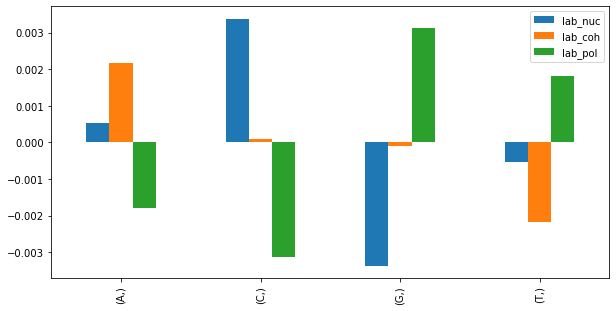

In [24]:
nuc_reldiff.loc[list('ACGT'), ['lab_nuc', 'lab_coh', 'lab_pol']].plot(kind='bar', figsize=(10, 5))

In [20]:
window_yeast['sep_pred_nuc'].value_counts()#, window_rand['sep_pred_nuc_rand'].value_counts()

low          56441
high         56441
discarded      224
Name: sep_pred_nuc, dtype: int64

(0.0, 0.3)

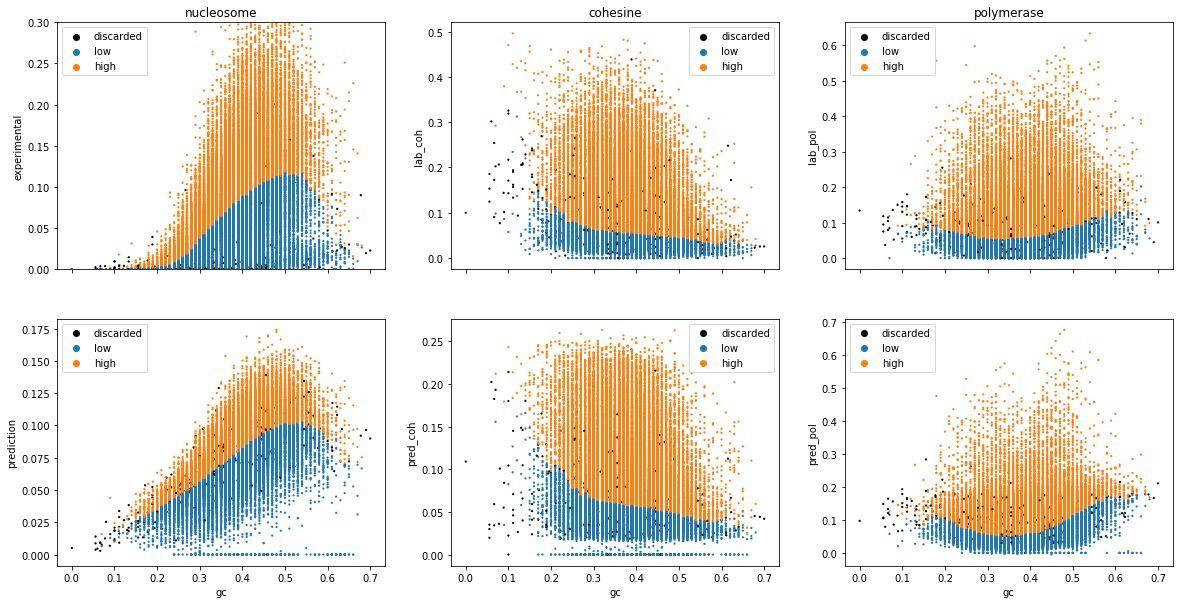

In [34]:
ys = [f'{part1}_{part2}' for part1 in ['lab', 'pred'] for part2 in ['nuc', 'coh', 'pol']]
mapping = {'lab': 'experimental', 'pred': 'prediction',
           'nuc': 'nucleosome', 'coh': 'cohesine', 'pol': 'polymerase'}
ylabels = [f'{mapping[part1]} {mapping[part2]}' for y in ys for part1, part2 in [tuple(y.split('_'))]]

fig, axes = plt.subplots(2, 3, figsize=(20, 10), sharex='col', facecolor='w')
for i, (y, ax) in enumerate(zip(ys, axes.flatten())):
    sns.scatterplot(ax=ax, data=window_yeast, x='gc', y=y,
                    hue=f'sep_{y}', hue_order=['discarded', 'low', 'high'], palette=['k'] + colors[:2],
                    ec=None, s=5)
    if i < 3:
        ax.set_title(mapping[y.split('_')[1]])
    if i % 3 == 0:
        ax.set_ylabel(mapping[y.split('_')[0]])
    ax.legend().set_title('')
axes[0, 0].set_ylim((0, 0.3))

In [35]:
df = kmer_diff.join(kmer_reldiff, lsuffix='_diff', rsuffix='_reldiff')
df = df.join(kmers / kmers.sum(axis=0))
df = df.sort_index()
kmer_order = [
    ('A', 'C'), ('G', 'T'), ('C', 'A'), ('T', 'G'),
    ('A', 'G'), ('C', 'T'), ('G', 'A'), ('T', 'C'),
    ('A', 'A'), ('T', 'T'), ('A', 'T'), ('T', 'A'),
    ('C', 'C'), ('G', 'G'), ('C', 'G'), ('G', 'C')]
df = df.loc[kmer_order]
df['SW'] = ['alt']*8 + ['same']*8

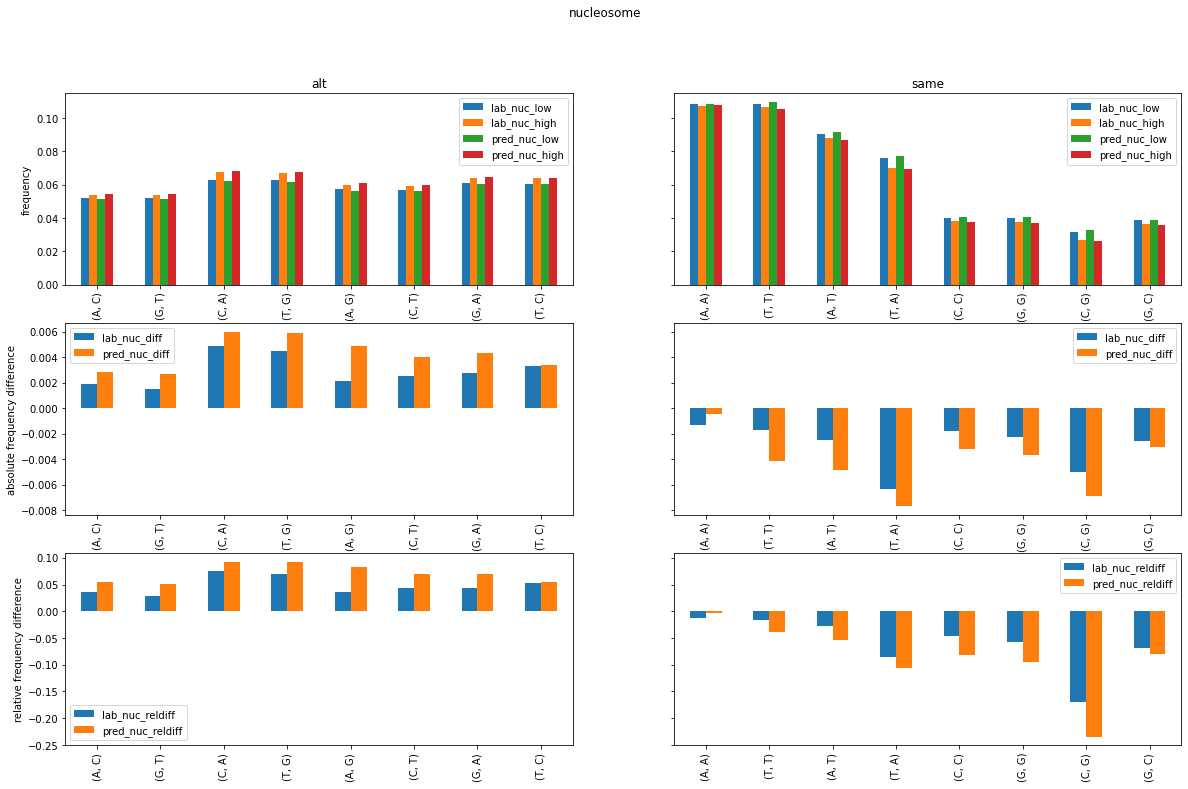

In [37]:
part2 = 'nuc'
fig, axes = plt.subplots(3, 2,
                         sharey='row',
                         figsize=(20, 12),
                         facecolor='w')
fig.suptitle(mapping[part2])
for i, (key, grp) in enumerate(df.groupby('SW')):
    grp.plot(kind='bar',
             y=[f'lab_{part2}_low', f'lab_{part2}_high', f'pred_{part2}_low', f'pred_{part2}_high'],
            #  color=['lightblue', 'blue', 'wheat', 'darkorange'],
             ax=axes[0, i],
             title=key)
    axes[0, i].set_ylabel('frequency')

    grp.plot(kind='bar',
             y=[f'lab_{part2}_diff', f'pred_{part2}_diff'],
             ax=axes[1, i])
    axes[1, i].set_ylabel('absolute frequency difference')

    grp.plot(kind='bar',
             y=[f'lab_{part2}_reldiff', f'pred_{part2}_reldiff'],
             ax=axes[2, i])
    axes[2, i].set_ylabel('relative frequency difference')

In [42]:
np.arange(24).reshape(2, 3, 4).sum(axis=(1, 2))

array([ 66, 210])

In [161]:
def sum_on_base(values, one_hots):
    res, count = np.zeros(5), np.zeros(5, dtype=int)
    for value, one_hot in zip(values, one_hots):
        arr = np.argmax(one_hot, axis=-1) + 4*(np.sum(one_hot, axis=-1) != 1)
        for i in range(5):
            mask = (arr == i)
            count[i] += mask.sum()
            res[i] += value[mask].sum()
    res /= count
    return res, count

def sum_on_2mer(values, one_hots):
    res, count = np.zeros((5, 5)), np.zeros((5, 5), dtype=int)
    for value, one_hot in zip(values, one_hots):
        arr = np.argmax(one_hot, axis=-1) + 4*(np.sum(one_hot, axis=-1) != 1)
        slide_arr = utils.sliding_window_view(arr, (2,)).reshape(-1, 2)
        slide_arr = 5*slide_arr[:, 0] + slide_arr[:, 1]
        slide_value = utils.moving_average(value, 2)
        for i in range(5):
            for j in range(5):
                mask = (slide_arr == 5*i + j)
                count[i, j] += mask.sum()
                res[i, j] += slide_value[mask].sum()
    res /= count
    return res, count

<AxesSubplot:>

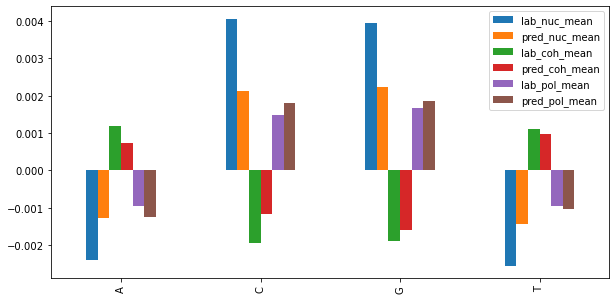

In [195]:
labels_nuc_yeast = {k: v for k, v in labels_nuc.items() if k[:3] == 'chr'}
preds_nuc_yeast = {k: v / thres_pred_nm for k, v in preds_nuc.items() if k[:3] == 'chr'}
mean_lab_nuc_yeast = np.sum([np.sum(v) for v in labels_nuc_yeast.values()]) / np.sum([len(v) for v in labels_nuc_yeast.values()])
mean_pred_nuc_yeast = np.sum([np.sum(v) for v in preds_nuc_yeast.values()]) / np.sum([len(v) for v in preds_nuc_yeast.values()])
labels_coh_yeast = {k: v for k, v in labels_coh.items() if k[:3] == 'chr'}
preds_coh_yeast = {k: v / thres_pred_cm for k, v in preds_coh.items() if k[:3] == 'chr'}
mean_lab_coh_yeast = np.sum([np.sum(v) for v in labels_coh_yeast.values()]) / np.sum([len(v) for v in labels_coh_yeast.values()])
mean_pred_coh_yeast = np.sum([np.sum(v) for v in preds_coh_yeast.values()]) / np.sum([len(v) for v in preds_coh_yeast.values()])
labels_pol_yeast = {k: v for k, v in labels_pol.items() if k[:3] == 'chr'}
preds_pol_yeast = {k: v / thres_pred_pm for k, v in preds_pol.items() if k[:3] == 'chr'}
mean_lab_pol_yeast = np.sum([np.sum(v) for v in labels_pol_yeast.values()]) / np.sum([len(v) for v in labels_pol_yeast.values()])
mean_pred_pol_yeast = np.sum([np.sum(v) for v in preds_pol_yeast.values()]) / np.sum([len(v) for v in preds_pol_yeast.values()])
df = pd.DataFrame(
    {'lab_nuc_mean': sum_on_base(labels_nuc_yeast.values(), one_hots_yeast.values())[0] - mean_lab_nuc_yeast,
     'pred_nuc_mean': sum_on_base(preds_nuc_yeast.values(), one_hots_yeast.values())[0] - mean_pred_nuc_yeast,
     'lab_coh_mean': sum_on_base(labels_coh_yeast.values(), one_hots_yeast.values())[0] - mean_lab_coh_yeast,
     'pred_coh_mean': sum_on_base(preds_coh_yeast.values(), one_hots_yeast.values())[0] - mean_pred_coh_yeast,
     'lab_pol_mean': sum_on_base(labels_pol_yeast.values(), one_hots_yeast.values())[0] - mean_lab_pol_yeast,
     'pred_pol_mean': sum_on_base(preds_pol_yeast.values(), one_hots_yeast.values())[0] - mean_pred_pol_yeast},
    index=list('ACGTN')
    )
df.loc[list('ACGT')].plot(kind='bar', figsize=(10, 5))

(<Figure size 720x360 with 1 Axes>, <AxesSubplot:>)

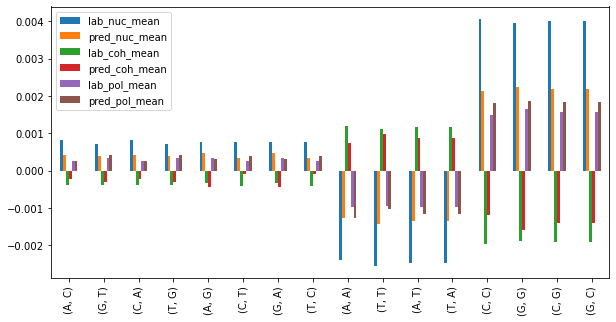

In [196]:
df2_expect = pd.DataFrame(
    0,
    columns=df.columns,
    index=pd.MultiIndex.from_product([list('ACGTN')]*2))
for tup in df2_expect.index:
    for nuc in tup:
        df2_expect.loc[tup, :] += df.loc[nuc, :]
df2_expect /= 2
plot_utils.plot_2mer_df(pd.DataFrame(df2_expect))

<AxesSubplot:>

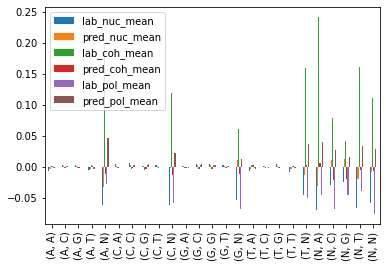

In [198]:
df2 = pd.DataFrame(
    {'lab_nuc_mean': sum_on_2mer(labels_nuc_yeast.values(), one_hots_yeast.values())[0].ravel() - mean_lab_nuc_yeast,
     'pred_nuc_mean': sum_on_2mer(preds_nuc_yeast.values(), one_hots_yeast.values())[0].ravel() - mean_pred_nuc_yeast,
     'lab_coh_mean': sum_on_2mer(labels_coh_yeast.values(), one_hots_yeast.values())[0].ravel() - mean_lab_coh_yeast,
     'pred_coh_mean': sum_on_2mer(preds_coh_yeast.values(), one_hots_yeast.values())[0].ravel() - mean_pred_coh_yeast,
     'lab_pol_mean': sum_on_2mer(labels_pol_yeast.values(), one_hots_yeast.values())[0].ravel() - mean_lab_pol_yeast,
     'pred_pol_mean': sum_on_2mer(preds_pol_yeast.values(), one_hots_yeast.values())[0].ravel() - mean_pred_pol_yeast},
    index=pd.MultiIndex.from_product([list('ACGTN')]*2)
    )
df2.plot(kind='bar')

(<Figure size 1440x360 with 1 Axes>, <AxesSubplot:>)

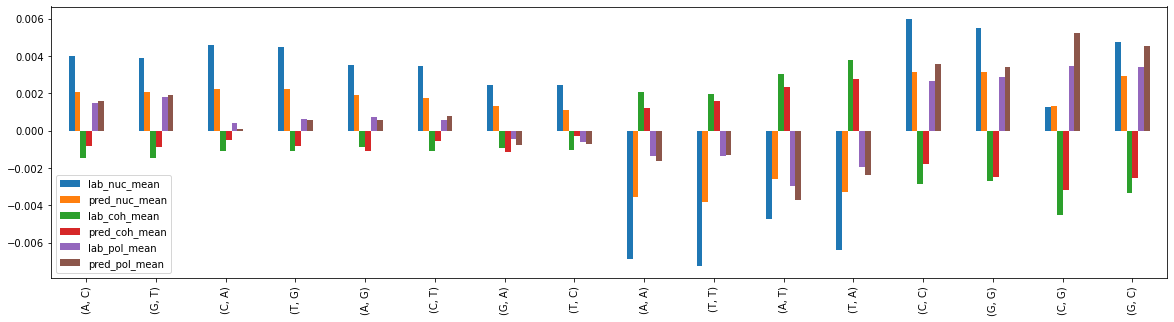

In [205]:
plot_utils.plot_2mer_df(df2)#, columns=['lab_nuc_mean','pred_nuc_mean'])

(<Figure size 1440x360 with 1 Axes>, <AxesSubplot:>)

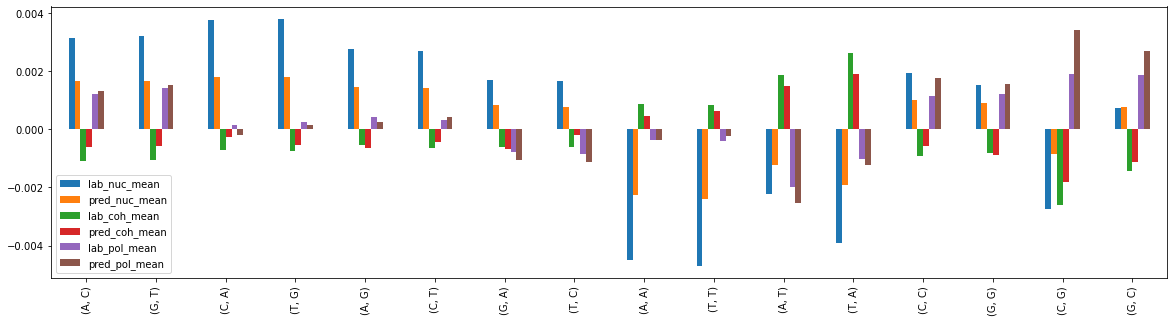

In [206]:
plot_utils.plot_2mer_df(df2 - df2_expect)#, columns=['lab_nuc_mean','pred_nuc_mean'])

In [233]:
print(pearsonr(np.concatenate(list(labels_coh_yeast.values())), np.concatenate(list(labels_nuc_yeast.values())).clip(None, 1)))
print(pearsonr(np.concatenate(list(labels_pol_yeast.values())), np.concatenate(list(labels_nuc_yeast.values())).clip(None, 1)))
print(pearsonr(np.concatenate(list(labels_coh_yeast.values())), np.concatenate(list(labels_pol_yeast.values()))))

(-0.038658624333554686, 0.0)
(0.041248236844136546, 0.0)
(-0.12608220643816037, 0.0)


In [20]:
labels_nuc_yeast = np.concatenate([v for k, v in labels_nuc.items() if k[:3]=='chr'])
preds_nuc_yeast = np.concatenate([v for k, v in preds_nuc.items() if k[:3]=='chr'])
pearsonr(preds_nuc_yeast, labels_nuc_yeast)

(0.3030616983144123, 0.0)

In [21]:
pearsonr(preds_nuc_yeast, labels_nuc_yeast.clip(None, 1))

(0.6338942207969737, 0.0)

In [14]:
pearsonr(preds_nuc['chr12'], labels_nuc['chr12'])

(0.1276960214349531, 0.0)

In [15]:
pearsonr(preds_nuc['chr12'], labels_nuc['chr12'].clip(None, 1))

(0.6086547693154676, 0.0)

Text(0, 0.5, 'absolute kmer frequency difference')

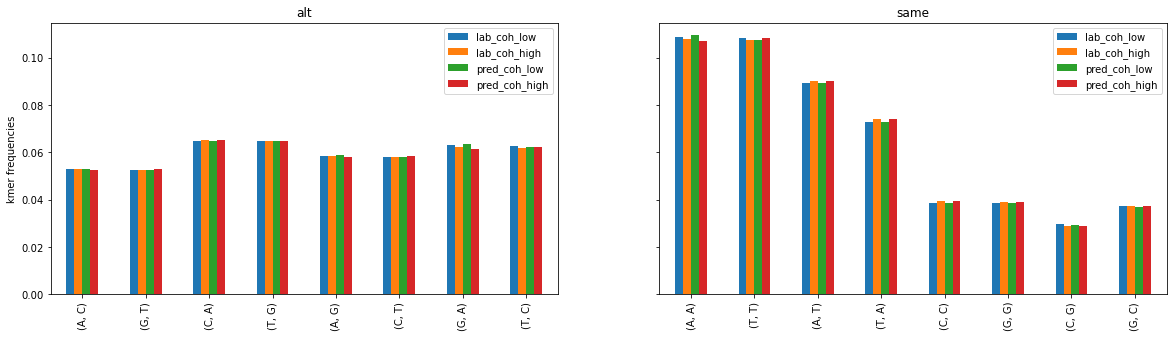

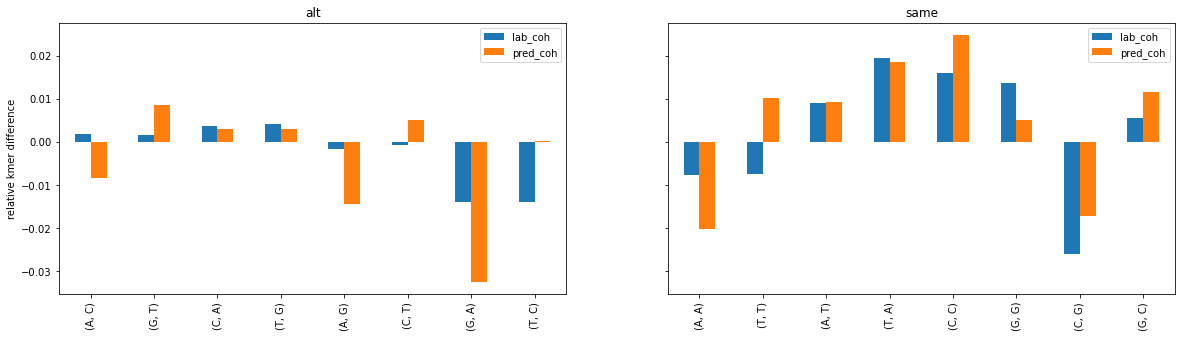

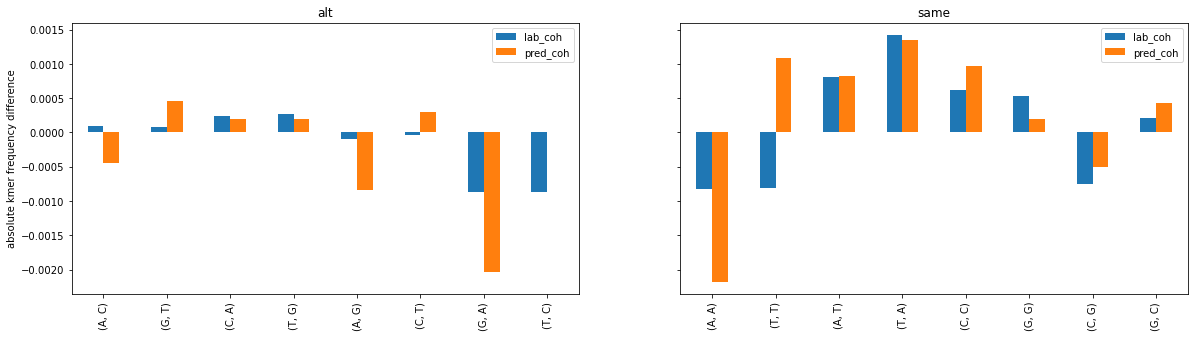

In [220]:
part2 = 'coh'
fig, axes = plot_utils.plot_2mer_df(kmers / kmers.sum(axis=0), columns=[f'lab_{part2}_low', f'lab_{part2}_high', f'pred_{part2}_low', f'pred_{part2}_high'], group='SW')
axes[0].set_ylabel('kmer frequencies')
fig, axes = plot_utils.plot_2mer_df(kmer_reldiff, columns=[f'lab_{part2}', f'pred_{part2}'], group='SW')
axes[0].set_ylabel('relative kmer difference')
fig, axes = plot_utils.plot_2mer_df(kmer_diff, columns=[f'lab_{part2}', f'pred_{part2}'], group='SW')
axes[0].set_ylabel('absolute kmer frequency difference')

Distributions of predictions and labels

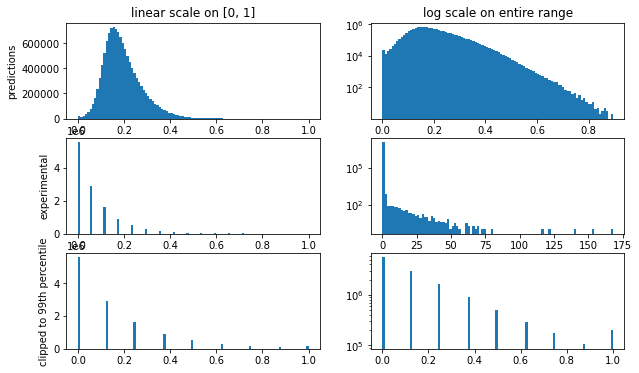

In [123]:
plt.figure(figsize=(10, 6))

plt.subplot(321)
plt.title('linear scale on [0, 1]')
plt.hist(all_preds_yeast, bins=100, range=(0, 1))
plt.ylabel('predictions')

plt.subplot(322)
plt.title('log scale on entire range')
plt.hist(all_preds_yeast, bins=100)
plt.yscale('log')

plt.subplot(323)
plt.hist(norm_yeast, bins=100, range=(0, 1))
plt.ylabel('experimental')

plt.subplot(324)
plt.hist(norm_yeast, bins=100)
plt.yscale('log')

plt.subplot(325)
plt.hist(clip_yeast, bins=100, range=(0, 1))
plt.ylabel('clipped to 99th percentile')

plt.subplot(326)
plt.hist(clip_yeast, bins=100)
plt.yscale('log')

plt.show()
plt.close()

#### Load models

Check model architectures

In [22]:
model = tf.keras.models.load_model(f'{data_dir}/{species}/models_etienne/weights_myco_pol2_2048_16.hdf5', custom_objects={'correlate' : correlate, 'mae_cor' : mae_cor})
model.summary()
print(model.layers[-1], model.layers[-1].activation)
del model

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 2048, 4)]    0                                            
__________________________________________________________________________________________________
conv1d_14 (Conv1D)              (None, 2048, 32)     1568        input_4[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_9 (MaxPooling1D)  (None, 256, 32)      0           conv1d_14[0][0]                  
__________________________________________________________________________________________________
batch_normalization_13 (BatchNo (None, 256, 32)      128         max_pooling1d_9[0][0]            
_______________________________________________________________________________________

Predict on genomes

In [19]:
species = 'SCerevisiae'
genomes = ['W303', 'Mmm_Linear_740kb', 'Pneu300']
model_files = [
    # (Path(data_dir, species, 'models_etienne', 'weights_myco_rep1.hdf5'), 'nucleosome'),
    # (Path(data_dir, species, 'models_etienne', 'weights_nucleosome_myco_rep2.hdf5'), 'nucleosome'),
    # (Path(data_dir, species, 'models_etienne', 'weights_nucleosome_myco_rep3.hdf5'), 'nucleosome'),
    # (Path(data_dir, species, 'models_etienne', 'weights_myco_rep1_cohesine.hdf5'), 'cohesine'),
    # (Path(data_dir, species, 'models_etienne', 'weights_myco_rep1_cohesine_2.hdf5'), 'cohesine'),
    # (Path(data_dir, species, 'models_etienne', 'weights_myco_rep1_cohesine_3.hdf5'), 'cohesine'),
    # (Path(data_dir, species, 'models_etienne', 'weights_myco_pol2_2048_16.hdf5'), 'pol'),
    # (Path(data_dir, species, 'models_etienne', 'weights_myco_pol2_2048_16_2.hdf5'), 'pol'),
    # (Path(data_dir, species, 'models_etienne', 'weights_myco_pol2_2048_16_3.hdf5'), 'pol'),
    ]
for model_file, annotation_type in model_files:
    for genome in genomes:
        if annotation_type == 'nucleosome':
            model = tf.keras.models.load_model(model_file, custom_objects={'correlate' : correlate, 'mae_cor' : mae_cor})
            order_suffix = '_ATGC'
        else:
            model = tf.keras.models.load_model(model_file, custom_objects={'correlate' : correlate})
            order_suffix = ''
        if genome == 'W303':
            genome_dir = 'W303'
        else:
            genome_dir = 'bacterie'
        all_preds = {}
        with np.load(Path(data_dir, species, 'genome', genome_dir, f'{genome}{order_suffix}.npz')) as f:
            for chr_id in f.keys():
                one_hot_chr = f[chr_id]
                try:
                    all_preds[chr_id] = predict(one_hot_chr, model, annotation_type)
                except ValueError:
                    print(f"Can't predict on {chr_id}, skipping...")
        del model
        np.savez(Path(data_dir, species, 'results', 'models_etienne', f'preds_{model_file.stem}_on_{genome}.npz'), **all_preds)

Can't predict on p2, skipping...


pearsonr: (0.683715419445692, 0.0)
0.07244701428360163 0.07515196


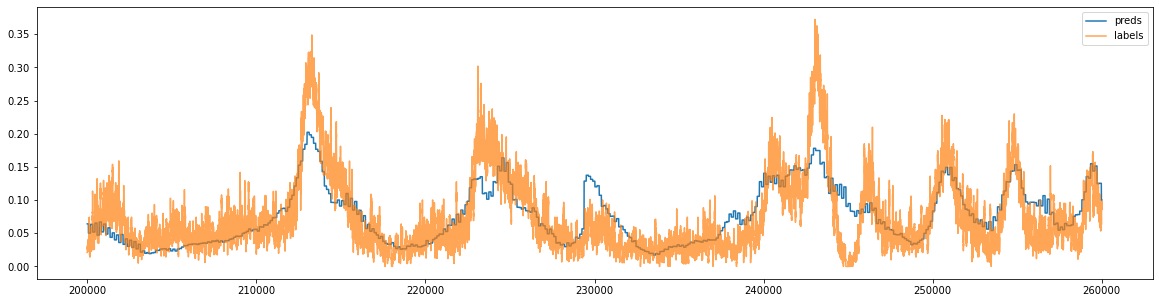

In [57]:
chr_id = 'chr16'
preds = preds_coh[chr_id] / thres_pred_cm
labels = labels_coh[chr_id] # * thres_coh_p
print('pearsonr:', pearsonr(preds, labels))
print(np.mean(preds), np.mean(labels))

start = 200_000
stop = start + 60_000
plt.figure(figsize=(20, 5))
plt.plot(np.arange(start, stop), preds[start:stop], label='preds')#, alpha=0.5, width=1)
plt.plot(np.arange(start, stop), labels[start:stop], label='labels', alpha=0.7)#, width=1)
# plt.plot(np.arange(start, stop), labels_coh_m[chr_id][start:stop], label='labels_m', alpha=0.7)#, width=1)
plt.legend()
plt.savefig('testing_savefig', bbox_inches='tight', facecolor='w')
plt.show()
plt.close()

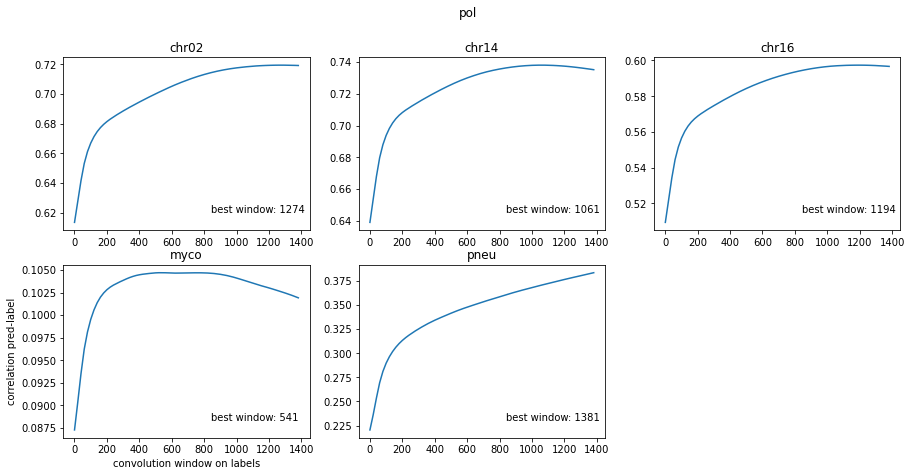

In [168]:
annot = 'pol'
if annot == 'nucleosome':
    preds = preds_nuc
    labels = labels_nuc
    ns = [i for i in range(1, 101)]
elif annot == 'cohesine':
    preds = preds_coh
    labels = labels_coh
    ns = [i for i in range(1, 701, 20)] + [i for i in range(701, 801)] + [i for i in range(801, 1001, 20)]
elif annot == 'pol':
    preds = preds_pol
    labels = labels_pol
    ns = [i for i in range(1, 1101, 20)] + [i for i in range(1101, 1301)] + [i for i in range(1301, 1401, 20)]
plt.figure(figsize=(15, 7))
plt.suptitle(annot)
for i, chr_id in enumerate(['chr02', 'chr14', 'chr16', 'myco', 'pneu']):
    corrs = []
    for n in ns:
        lab = np.convolve(labels[chr_id], np.ones(n), mode='same') / n
        corrs.append(pearsonr(preds[chr_id], lab)[0])
    plt.subplot(231+i)
    plt.plot(ns, corrs)
    plt.title(chr_id)
    if i == 3:
        plt.xlabel('convolution window on labels')
        plt.ylabel('correlation pred-label')
    plt.annotate(f'best window: {ns[np.argmax(corrs)]}', xy=(0.6, 0.1), xycoords="axes fraction")
plt.savefig(Path(data_dir, species, 'results', 'models_etienne', f'corr_{annot}_vs_conv_window.png'), bbox_inches='tight', facecolor='w')
plt.show()
plt.close()

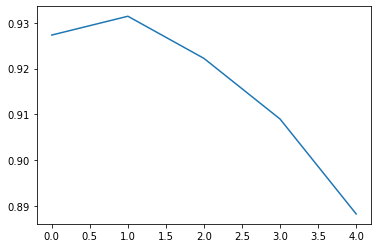

In [8]:
corrs = [pearsonr(pred_nucleosome, pred_nucleosome_rev)[0]]
for offset in range(1, 5):
    corrs.append(pearsonr(pred_nucleosome[offset:], pred_nucleosome_rev[:-offset])[0])
plt.plot(np.arange(len(corrs)), corrs)
plt.show()
plt.close()

Predictions on SynEC for Romain

In [122]:
with np.load(Path(data_dir, data, 'data', 'chr4_SynEC100.npz')) as f:
    for k in f.keys():
        one_hot_chr_ACGT = f[k]
        break
with np.load(Path(data_dir, data, 'data', 'chr4_SynEC100_ATGC.npz')) as f:
    for k in f.keys():
        one_hot_chr_ATGC = f[k]
        break
with np.load(Path(data_dir, data, 'data', 'chr4_SynEC_UAS_TATA-yeGFP-NLS.npz')) as f:
    for k in f.keys():
        one_hot_chr2_ACGT = f[k]
        break
with np.load(Path(data_dir, data, 'data', 'chr4_SynEC_UAS_TATA-yeGFP-NLS_ATGC.npz')) as f:
    for k in f.keys():
        one_hot_chr2_ATGC = f[k]
        break
one_hot_chr2_ACGT.shape

(125243, 4)

In [169]:
seq = utils.one_hot_decode(one_hot_chr_ACGT)
seq2 = utils.one_hot_decode(one_hot_chr2_ACGT)
ref = utils.one_hot_decode(one_hot_chr_ref_ACGT)

In [225]:
start = 3623
size = 15_045 - start
for i in range(len(ref) - size + 1):
    if seq2[start:start+size] == ref[i:i+size]:
        print(i)

836753


In [262]:
pos = 833_130
start = 65_020
offset = -8625
length = 100
# print(ref[pos+start : pos+start+length])
print(seq[start:start+length])
print(seq2[start+offset:start+offset+length])

CTGTATAAACCAGCGCCACAGAATAGAACCCACTGTACGAGTGATCTGGGTACGGCACTCGGAGCGTAGTAATGGACACCACACATTTCTGGAACCTTTG
CTGTATAAACCAGCGCCACAGAATAGAACCCACTGTACGAGTGATCTGGGTACGGCACTCGGAGCGTAGTAATGGACACCACACATTTCTGGAACCTTTG


In [240]:
i = 68852
while seq[-i-1] == seq2[-i-2]:
    i += 1
print(i)

68852


In [132]:
data = 'SCerevisiae'

model_nucleosome = tf.keras.models.load_model(f'{data_dir}/{data}/models/weights_myco_rep1.hdf5', custom_objects={'correlate' : correlate, 'mae_cor' : mae_cor})
pred_nucleosome = predict(one_hot_chr_ATGC, model_nucleosome, "nucleosome")
pred_nucleosome2 = predict(one_hot_chr2_ATGC, model_nucleosome, "nucleosome")
del model_nucleosome
# model_nucleosome2 = tf.keras.models.load_model(f'{data_dir}/{data}/models/weights_nucleosome_myco_rep2.hdf5', custom_objects={'correlate' : correlate, 'mae_cor' : mae_cor})
# pred_nucleosome2 = predict(one_hot_chr_ATGC, model_nucleosome2, "nucleosome")
# del model_nucleosome2
# model_nucleosome3 = tf.keras.models.load_model(f'{data_dir}/{data}/models/weights_nucleosome_myco_rep3.hdf5', custom_objects={'correlate' : correlate, 'mae_cor' : mae_cor})
# pred_nucleosome3 = predict(one_hot_chr_ATGC, model_nucleosome3, "nucleosome")
# del model_nucleosome3
# model_nucleosome_pneu = tf.keras.models.load_model(f'{data_dir}/{data}/models/weights_pneu_rep1.hdf5', custom_objects={'correlate' : correlate, 'mae_cor' : mae_cor})
# pred_nucleosome_pneu = predict(one_hot_chr_ATGC, model_nucleosome_pneu, "nucleosome")
# del model_nucleosome_pneu
# model_nucleosome_all = tf.keras.models.load_model(f'{data_dir}/{data}/models/weights_CNN_nucleosome_in_vivo_all_data.hdf5', custom_objects={'correlate' : correlate, 'mae_cor' : mae_cor})
# pred_nucleosome_all = predict(one_hot_chr_ATGC, model_nucleosome_all, "nucleosome")
# del model_nucleosome_all

model_cohesine = tf.keras.models.load_model(f'{data_dir}/{data}/models/weights_myco_rep1_cohesine.hdf5', custom_objects={'correlate': correlate})
pred_cohesine = predict(one_hot_chr_ACGT, model_cohesine, "cohesine", last_window=True)
pred_cohesine2 = predict(one_hot_chr2_ACGT, model_cohesine, "cohesine", last_window=True)
del model_cohesine

model_pol = tf.keras.models.load_model(f'{data_dir}/{data}/models/weights_myco_pol2_2048_16.hdf5', custom_objects={'correlate' : correlate})
pred_pol = predict(one_hot_chr_ACGT, model_pol, "pol", last_window=True)
pred_pol2 = predict(one_hot_chr2_ACGT, model_pol, "pol", last_window=True)
del model_pol

In [133]:
df = pd.DataFrame({
    'nucleosome': pred_nucleosome,
    'cohesine': pred_cohesine,
    'pol2': pred_pol})
df2 = pd.DataFrame({
    'nucleosome': pred_nucleosome2,
    'cohesine': pred_cohesine2,
    'pol2': pred_pol2})

In [136]:
df.to_csv('../shared_folder/SCerevisiae/results/preds_chr4_SynEC100_full.csv')
df2.to_csv('../shared_folder/SCerevisiae/results/preds_chr4_SynEC_UAS_TATA-yeGFP-NLS_full.csv')

Testing model loading

In [264]:
preds = {}
for file in Path('..', 'shared_folder', 'SCerevisiae', 'models').glob('*.hdf5'):
    requires_mae_cor = False
    pred = None
    try:
        model = tf.keras.models.load_model(file, custom_objects={'correlate': correlate})
    except:
        model = tf.keras.models.load_model(file, custom_objects={'correlate' : correlate, 'mae_cor' : mae_cor})
        requires_mae_cor = True
    try:
        pred = predict(one_hot_chr_ref_ACGT, model, "cohesine")
        annotation_type = "cohesine"
    except:
        try:
            pred = predict(one_hot_chr_ref_ACGT, model, "pol")
            annotation_type = "pol"
        except:
            try:
                pred = predict(one_hot_chr_ref_ATGC, model, "nucleosome")
                annotation_type = "nucleosome"
            except:
                annotation_type = None        
    del model
    preds[file] = pred
    print(file, requires_mae_cor, annotation_type)
    # if pred is not None:
    #     start = 54_000
    #     stop = 59_000
    #     fig, ax = plt.subplots(figsize=(15, 3))
    #     ax.plot(np.arange(start, stop), pred[start:stop], linewidth=0.2)
    #     ax.set_ylim(0, 3)
    #     ax.fill_between(np.arange(start, stop), pred[start:stop], 0)
    

../shared_folder/SCerevisiae/models/weights_myco_rep1_cohesine_3.hdf5 False cohesine
../shared_folder/SCerevisiae/models/weights_myco_pol2_2048_16_2.hdf5 False pol
../shared_folder/SCerevisiae/models/weights_gal_pol2_2048_16.hdf5 False pol
../shared_folder/SCerevisiae/models/weights_CNN_nucleosome_in_vivo_all_data.hdf5 True nucleosome
../shared_folder/SCerevisiae/models/weights_Bassenji_32768_256.hdf5 False cohesine
../shared_folder/SCerevisiae/models/weights_myco_pol2.hdf5 False cohesine
../shared_folder/SCerevisiae/models/weights_pneu_rep1_transcription.hdf5 True nucleosome
../shared_folder/SCerevisiae/models/weights_nucleosome_myco_rep3.hdf5 True nucleosome
../shared_folder/SCerevisiae/models/weights_myco_rep1_cohesine_2.hdf5 False cohesine
../shared_folder/SCerevisiae/models/weights_myco_pol2_2048_16_3.hdf5 False pol
../shared_folder/SCerevisiae/models/weights_pneu_rep1_cohesine_2.hdf5 False cohesine
../shared_folder/SCerevisiae/models/weights_gal_pol2.hdf5 False cohesine
../shared

Predict

In [192]:
smooth_pred_nucleosome = utils.smooth(pred_nucleosome, 201, mode='gaussian', sigma=10)

In [9]:
pred_nucleosome_etienne = np.load(Path(data_dir, data, 'results', 'etienne_nucleosome_pneu_rep1_chr16.npy'))
pred_nucleosome_etienne.shape # 986200
# preds_etienne[-1010:-990]

(986200,)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


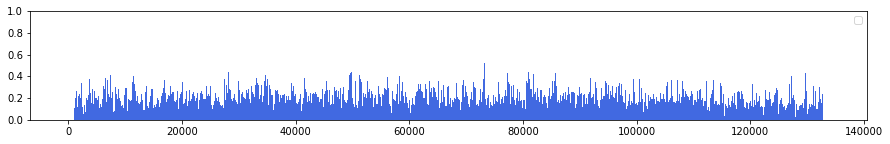

In [48]:
start = 0 #210_000
end = len(df) #220_000
plt.figure(figsize=(15, 4))
# plt.bar(np.arange(start, end), height=pred_nucleosome[start:end], width=1, alpha=1, color=(0, 0, 1), label='pred_myco')
plt.bar(np.arange(start, end), height=df['nucleosome'], width=1, color='royalblue')
# plt.bar(np.arange(start, end), height=pred_nucleosome_etienne[start:end], width=1, alpha=0.3, color=(0, 1, 0), label='pred_etienne')
plt.ylim(0, 1)
plt.legend()
plt.show()
plt.close()

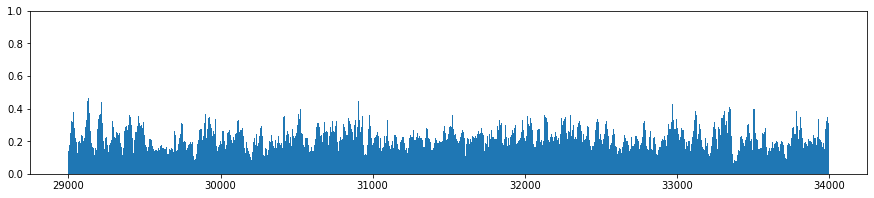

In [181]:
start = 29_000
stop = 34_000
plt.figure(figsize=(15, 3))
plt.bar(np.arange(start, stop), height=df['nucleosome'][start:stop], width=1)
plt.ylim(0, 1)
plt.show()
plt.close()

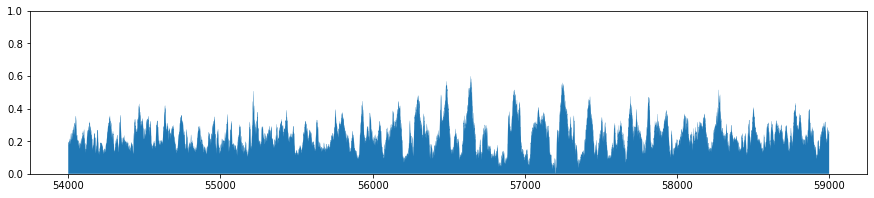

In [185]:
start = 54_000
stop = 59_000
fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(np.arange(start, stop), df['nucleosome'][start:stop], linewidth=0.2)
ax.set_ylim(0, 1)
ax.fill_between(np.arange(start, stop), df['nucleosome'][start:stop], 0)
fig.savefig(f'../shared_folder/SCerevisiae/results/pred_chr4_SynEC100_nucleosome_zoom', bbox_inches='tight')

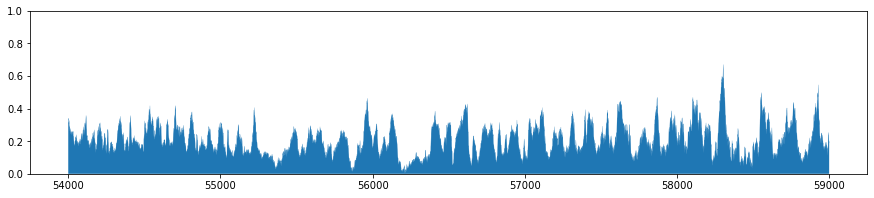

In [186]:
start = 54_000
stop = 59_000
fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(np.arange(start, stop), df2['nucleosome'][start:stop], linewidth=0.2)
ax.set_ylim(0, 1)
ax.fill_between(np.arange(start, stop), df2['nucleosome'][start:stop], 0)
fig.savefig(f'../shared_folder/SCerevisiae/results/pred_chr4_SynEC_UAS_TATA-yeGFP-NLS_nucleosome_zoom', bbox_inches='tight')

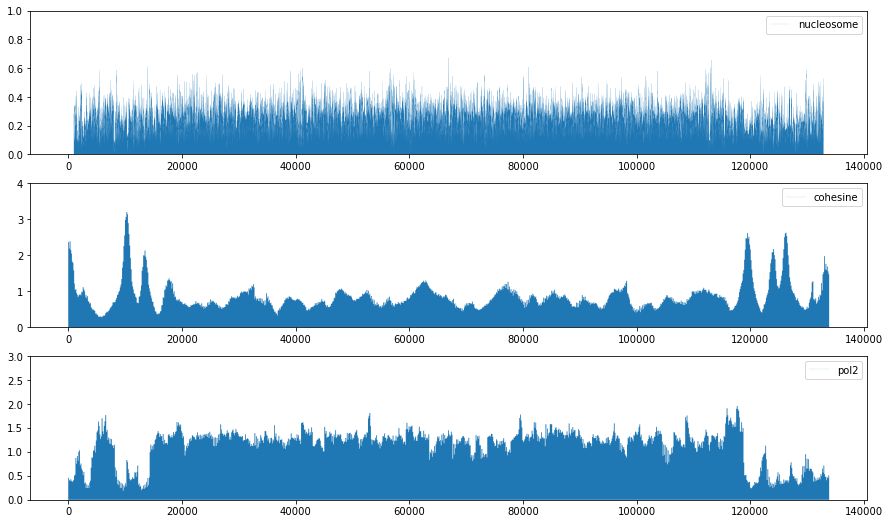

In [135]:
fig, axes = plt.subplots(nrows=3, figsize=(15, 9))
df.plot(y='nucleosome', use_index=True, ylim=(0, 1), ax=axes[0], linewidth=0.1)
axes[0].fill_between(df.index, df['nucleosome'], 0)
df.plot(y='cohesine', use_index=True, ylim=(0, 4), ax=axes[1], linewidth=0.1)
axes[1].fill_between(df.index, df['cohesine'], 0)
df.plot(y='pol2', use_index=True, ylim=(0, 3), ax=axes[2], linewidth=0.1)
axes[2].fill_between(df.index, df['pol2'], 0)
fig.savefig(f'../shared_folder/SCerevisiae/results/preds_chr4_SynEC100_full', bbox_inches='tight')

(0.9999999999998332, 0.0)


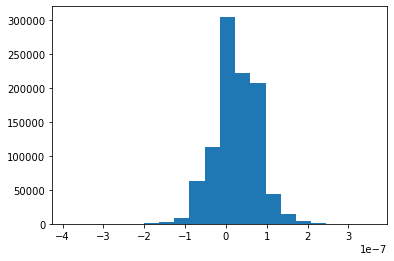

In [20]:
print(pearsonr(pred_nucleosome_pneu, pred_nucleosome_etienne))
diffs = pred_nucleosome_pneu - pred_nucleosome_etienne
plt.hist(diffs, bins=20)
plt.show()
plt.close()

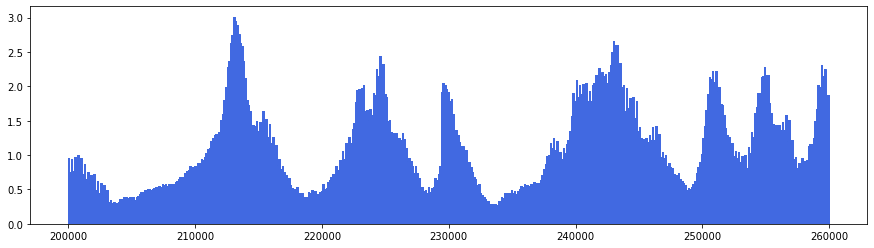

In [35]:
start = 200_000
end = 260_000
plt.figure(figsize=(15, 4))
plt.bar(np.arange(start, end), height=pred_cohesine[start:end], width=1, edgecolor='royalblue')
plt.show()
plt.close()

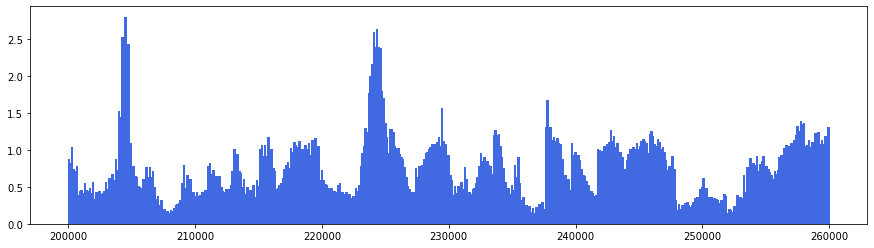

In [32]:
start = 200_000
end = 260_000
plt.figure(figsize=(15, 4))
plt.bar(np.arange(start, end), height=pred_pol[start:end], width=1, edgecolor='royalblue')
plt.show()
plt.close()

## Kinetic Monte Carlo

In [ ]:
# initialisation :
# use ATGC content from SCerevisiae
# build 1000 sequences of length N
# mutation and selection: 
# make every 3*N single nucleotide mutation
# selection probability of 1/norm * exp(-delta_energy / T)
# 10**4 steps
# save each configuration and keep best
# energy :
# create a 2001 + N sequence repeating the length N sequence, centered on it
# distance to target density E_reg is d(x, y) = 1 - corr(x, y) + 1/N * sum(abs(x_i - y_i))
# GC content constraint E_GC is abs(GC_synt - GC_nat) GC_nat=0.38
# E_mut penalizes sequences already seen
# E_rev, like E_reg but on reverse strand
# total energy is exp(-(a*E_GC + b*E_reg + c*E_rev + d*E_mut)/T)